In [ ]:
from google.colab import drive
import os

# Check if the mount point exists and is not empty, then remove its contents
mountpoint = '/content/drive'

drive.mount(mountpoint)

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, MobileNetV2, EfficientNetB0
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced"
save_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
os.makedirs(save_dir, exist_ok=True)
img_size = (224, 224)
batch_size = 32
num_classes = 2  # Electrical-damage vs Physical-Damage

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 142 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


In [ ]:
def build_model(base_model_class, name):
    base_model = base_model_class(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3)
    )
    for layer in base_model.layers:
        layer.trainable = False  # freeze pretrained layers

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
models_to_train = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "InceptionV3": InceptionV3,
    "MobileNetV2": MobileNetV2,
    "EfficientNetB0": EfficientNetB0
}

for name, model_class in models_to_train.items():
    print(f"\nTraining {name}...")
    model = build_model(model_class, name)

    ckpt_path = os.path.join(save_dir, f"Defective_{name}.keras")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=25,
        callbacks=callbacks,
        verbose=1
    )

    # Save the model and history
    model.save(ckpt_path)
    import pickle
    history_path = os.path.join(save_dir, f"Defective_{name}_history.pkl")
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"{name} training complete! Saved to:", ckpt_path)


Training VGG16...
Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4917 - loss: 0.7380 - val_accuracy: 0.8000 - val_loss: 0.6457
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step - accuracy: 0.5400 - loss: 0.7429 - val_accuracy: 0.8000 - val_loss: 0.6432
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step - accuracy: 0.5587 - loss: 0.6690 - val_accuracy: 0.8333 - val_loss: 0.6408
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step - accuracy: 0.5446 - loss: 0.7166 - val_accuracy: 0.8333 - val_loss: 0.6385
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - accuracy: 0.5486 - loss: 0.7227 - val_accuracy: 0.8333 - val_loss: 0.6364
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - accuracy: 0.5539 - loss: 0.7368 - val_accuracy: 0.8000 - val_loss: 0.6342
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - accuracy: 0.5559 - loss: 0.6854 - val_accuracy: 0.8000 - val_loss: 0.6320
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - accuracy: 0.5097 - loss: 0.7402 - val_accuracy: 0.

In [ ]:
import os
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Your save directory (update this path)
save_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced"
img_size = (224, 224)
batch_size = 32


# Assuming you already have a test generator defined:
# test_gen = test_datagen.flow_from_directory(...)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

models = ["VGG16", "ResNet50", "InceptionV3", "MobileNetV2", "EfficientNetB0"]

for name in models:
    print(f"\nEvaluating {name}...")

    # Load model
    ckpt_path = os.path.join(save_dir, f"Defective_{name}.keras")
    model = tf.keras.models.load_model(ckpt_path)

    # Load training history
    history_path = os.path.join(save_dir, f"Defective_{name}_history.pkl")
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    # Get final (or best) training/validation accuracy
    train_acc = history['accuracy'][-1]
    val_acc = max(history['val_accuracy'])

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)

    print(f"Results for {name}:")
    print(f"Training Accuracy:   {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy:       {test_acc:.4f}")

Found 34 images belonging to 2 classes.

Evaluating VGG16...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5496 - loss: 0.6576
Results for VGG16:
Training Accuracy:   0.6901
Validation Accuracy: 0.8333
Test Accuracy:       0.5588

Evaluating ResNet50...
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.7402 - loss: 0.6421
Results for ResNet50:
Training Accuracy:   0.5352
Validation Accuracy: 0.7000
Test Accuracy:       0.7353

Evaluating InceptionV3...
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.8499 - loss: 0.3907
Results for InceptionV3:
Training Accuracy:   0.8310
Validation Accuracy: 0.9333
Test Accuracy:       0.8529

Evaluating MobileNetV2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - accuracy: 0.7598 - loss: 0.5830
Results for MobileNetV2:
Training Accuracy:   0.7394
Validation Accuracy: 0.9000
Test Accuracy:       0.7647

Evaluating EfficientNetB0...


2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 10s/step - accuracy: 0.4896 - loss: 0.6934
Results for EfficientNetB0:
Training Accuracy:   0.5000
Validation Accuracy: 0.5000
Test Accuracy:       0.5000


Found 34 images belonging to 2 classes.

Evaluating VGG16...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5496 - loss: 0.6576
Results for VGG16:
Training Accuracy:   0.6901
Validation Accuracy: 0.8333
Test Accuracy:       0.5588

Evaluating ResNet50...
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7402 - loss: 0.6421
Results for ResNet50:
Training Accuracy:   0.5352
Validation Accuracy: 0.7000
Test Accuracy:       0.7353

Evaluating InceptionV3...
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.8499 - loss: 0.3907
Results for InceptionV3:
Training Accuracy:   0.8310
Validation Accuracy: 0.9333
Test Accuracy:       0.8529

Evaluating MobileNetV2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7598 - loss: 0.5830
Results for MobileNetV2:
Training Accuracy:   0.7394
Validation Accuracy: 0.9000
Test Accuracy:       0.7647

Evaluating EfficientNetB0...


2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.4896 - loss: 0.6934
Results for EfficientNetB0:
Training Accuracy:   0.5000
Validation Accuracy: 0.5000
Test Accuracy:       0.5000


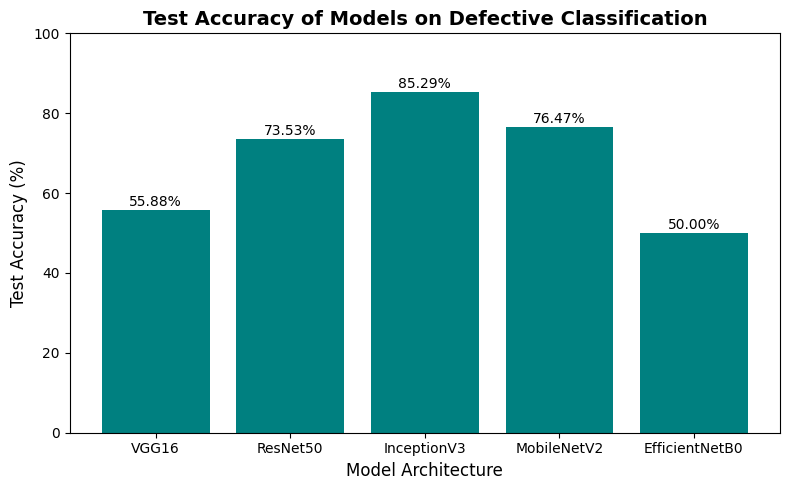

In [ ]:
import os
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# CONFIGURATION
save_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced"
img_size = (224, 224)
batch_size = 32
# DATA GENERATOR
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# MODEL EVALUATION
models = ["VGG16", "ResNet50", "InceptionV3", "MobileNetV2", "EfficientNetB0"]
test_accuracies = []

for name in models:
    print(f"\nEvaluating {name}...")

    # Load model
    ckpt_path = os.path.join(save_dir, f"Defective_{name}.keras")
    model = tf.keras.models.load_model(ckpt_path)

    # Load training history
    history_path = os.path.join(save_dir, f"Defective_{name}_history.pkl")
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    # Get final (or best) training/validation accuracy
    train_acc = history['accuracy'][-1]
    val_acc = max(history['val_accuracy'])

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    test_accuracies.append(test_acc * 100)

    print(f"Results for {name}:")
    print(f"Training Accuracy:   {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy:       {test_acc:.4f}")
# PLOT RESULTS
plt.figure(figsize=(8, 5))
plt.bar(models, test_accuracies, color="teal")
plt.title("Test Accuracy of Models on Defective Classification", fontsize=14, fontweight='bold')
plt.xlabel("Model Architecture", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.ylim(0, 100)
# Add accuracy values on top of bars
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


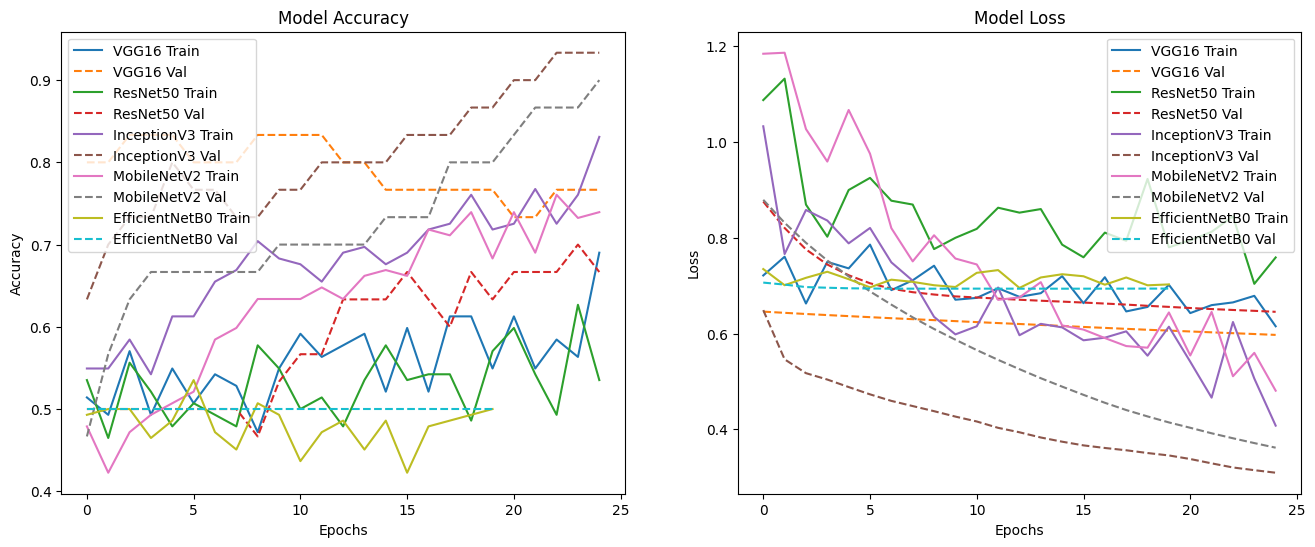

In [ ]:
import matplotlib.pyplot as plt
import pickle
import os

histories = {}
for name in models_to_train.keys():
    history_path = os.path.join(save_dir, f"Defective_{name}_history.pkl")
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            histories[name] = pickle.load(f)
    else:
        print(f"History not found for {name} at {history_path}")


plt.figure(figsize=(16,6))
# Accuracy
plt.subplot(1,2,1)
for name, hist in histories.items():
    plt.plot(hist['accuracy'], label=f'{name} Train')
    plt.plot(hist['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
for name, hist in histories.items():
    plt.plot(hist['loss'], label=f'{name} Train')
    plt.plot(hist['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import load_model
ensemble_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
ensemble_models = []
for f in os.listdir(ensemble_dir):
    if f.startswith("Defective_") and f.endswith(".keras"):
        path = os.path.join(ensemble_dir, f)
        print("Loading:", path)
        model = load_model(path)
        ensemble_models.append(model)
print(f"Loaded {len(ensemble_models)} models into the ensemble.")


Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_VGG16.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_EfficientNetB0.keras
Loaded 5 models into the ensemble.


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_defect_type(img_path, ensemble_models):
    """
    Predict defect type (Electrical or Physical damage)
    using ensemble of multi-class models.
    """
    # Load & preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Collect predictions from all models (each outputs [p_electrical, p_physical])
    preds = [model.predict(img_array, verbose=0)[0] for model in ensemble_models]
    avg_pred = np.mean(preds, axis=0)  # average across ensemble

    # Get class with max probability
    class_idx = np.argmax(avg_pred)
    defect_classes = ["Electrical-damage", "Physical-damage"]
    final_label = defect_classes[class_idx]

    print(f"Raw average probabilities: Electrical={avg_pred[0]:.4f}, Physical={avg_pred[1]:.4f}")
    print(f"Ensemble Prediction: {final_label}")

    return final_label


In [ ]:
img_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Electrical-damage/Electrical (30).jpg"
result = predict_defect_type(img_path, defect_models)

Raw average probabilities: Electrical=0.6943, Physical=0.3057
🧩 Ensemble Prediction: Electrical-damage


In [ ]:
img_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Electrical-damage/Electrical (50).jpg"
result = predict_defect_type(img_path, defect_models)

Raw average probabilities: Electrical=0.6751, Physical=0.3249
🧩 Ensemble Prediction: Electrical-damage


In [ ]:
img_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Physical-Damage/aug_14_Physical (36).jpg"
result = predict_defect_type(img_path, defect_models)

Raw average probabilities: Electrical=0.3063, Physical=0.6937
🧩 Ensemble Prediction: Physical-damage


In [ ]:
img_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Physical-Damage/Physical (51).jpg"
result = predict_defect_type(img_path, defect_models)

Raw average probabilities: Electrical=0.3735, Physical=0.6265
🧩 Ensemble Prediction: Physical-damage


In [ ]:
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced"
save_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Directories
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced"
save_dir = os.path.join(base_dir, "model_results")

# Load trained models
model_names = ["VGG16", "ResNet50", "InceptionV3", "MobileNetV2", "EfficientNetB0"]
ensemble_models = [
    tf.keras.models.load_model(os.path.join(save_dir, f"Defective_{name}.keras"))
    for name in model_names
]


Found 34 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



🧩 Ensemble Test Accuracy: 76.47%


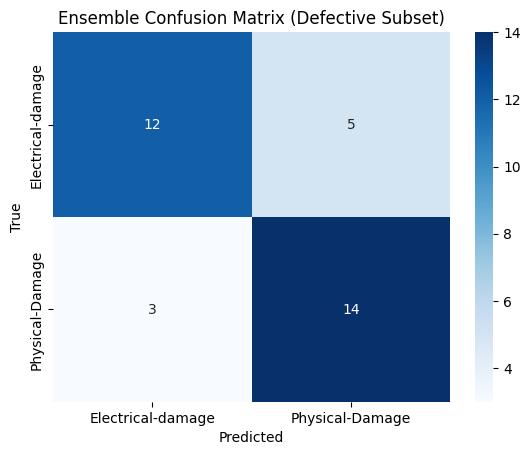


Classification Report:
                   precision    recall  f1-score   support

Electrical-damage       0.80      0.71      0.75        17
  Physical-Damage       0.74      0.82      0.78        17

         accuracy                           0.76        34
        macro avg       0.77      0.76      0.76        34
     weighted avg       0.77      0.76      0.76        34



In [ ]:
img_size = (224, 224)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Get true labels
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Get predictions from each model
all_preds = []

for model in ensemble_models:
    preds = model.predict(test_gen, verbose=0)
    all_preds.append(preds)

# Average predictions across models (soft voting)
avg_preds = np.mean(all_preds, axis=0)
y_pred = np.argmax(avg_preds, axis=1)

# Calculate accuracy
ensemble_accuracy = np.mean(y_true == y_pred)
print(f"\n🧩 Ensemble Test Accuracy: {ensemble_accuracy * 100:.2f}%")

# Optional: display confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix (Defective Subset)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
import numpy as np

def ensemble_predict(models, generator):
    preds = [m.predict(generator, verbose=0) for m in models]
    avg_preds = np.mean(preds, axis=0)
    return avg_preds


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


                   precision    recall  f1-score   support

Electrical-damage       0.80      0.71      0.75        17
  Physical-Damage       0.74      0.82      0.78        17

         accuracy                           0.76        34
        macro avg       0.77      0.76      0.76        34
     weighted avg       0.77      0.76      0.76        34



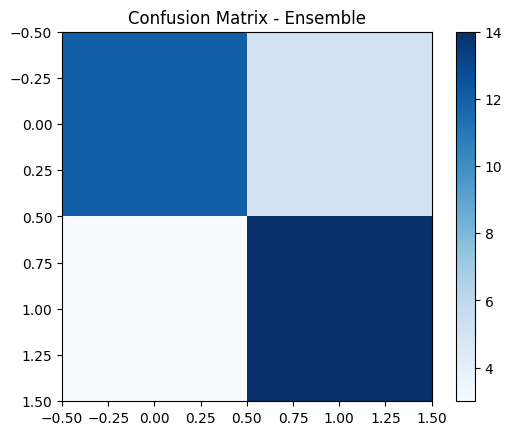

In [ ]:
avg_preds = ensemble_predict(ensemble_models, test_gen)

# Convert probabilities to class labels
y_pred = np.argmax(avg_preds, axis=1)
y_true = test_gen.classes

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix - Ensemble')
plt.colorbar()
plt.show()


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# === CONFIGURATION ===
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"

IMG_SIZE = (224, 224)
# --- Define focal loss used during training ---
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

# Register custom function
from tensorflow.keras.saving import register_keras_serializable
register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)

# === LOAD MODELS ===
def load_ensemble_models(model_dir, prefix_filter=None):
    models = []
    for f in os.listdir(model_dir):
        if f.endswith(".keras") and (prefix_filter is None or prefix_filter in f):
            path = os.path.join(model_dir, f)
            print("Loading:", path)
            models.append(load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed}))
    print(f"Loaded {len(models)} models from {model_dir}")
    return models
binary_models = load_ensemble_models(binary_models_dir)
defect_models = load_ensemble_models(defect_models_dir, prefix_filter="Defective_")
# === ENSEMBLE PREDICT ===
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred
# === IMAGE PREPROCESS ===
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x
# === FINAL PIPELINE ===
def classify_image(img_path):
    img_array = prepare_image(img_path)
    # Stage 1: Binary classification
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]  # assuming output shape (1, 1)
    print(f"\nBinary probability (defective): {binary_prob:.3f}")
    if binary_prob < 0.5:
        binary_label = "Defective"
    else:
        binary_label = "Non-Defective"
    # Stage 2: Defect type classification (only if defective)
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        final_label = f"Defective – {defect_label}"
        print(f"Defect probabilities: {defect_pred}")
    else:
        final_label = "Non-Defective"
    print(f"\nFinal Prediction: {final_label}")
    return final_label


Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_EfficientNetB0.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_VGG16.keras
Loading: /cont

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved op

Loaded 21 models from /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_VGG16.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_EfficientNetB0.keras
Loaded 5 models from /content/drive/MyDrive/Project/solarPanelDef

In [ ]:
from sklearn.metrics import accuracy_score
import glob

# Paths
binary_test_dirs = [
    "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/SplitBalanced_batch_1/test",
    "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/SplitBalanced_batch_2/test",
    "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/SplitBalanced_batch_3/test",
    "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/SplitBalanced_batch_4/test"
]
defective_test_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test"

# Collect test images (for stage-2 ensemble)
image_paths = []
true_labels = []
for cls in ["Electrical-damage", "Physical-damage"]:
    paths = glob.glob(os.path.join(defective_test_dir, cls, "*.jpg"))  # or *.png
    image_paths.extend(paths)
    true_labels.extend([cls]*len(paths))

pred_labels = []
for p in image_paths:
    label = classify_image(p)
    pred_labels.append(label.split("–")[-1].strip() if "Defective" in label else "Non-Defective")

acc = accuracy_score(true_labels, pred_labels)
print(f"\n🧩 Ensemble Test Accuracy on defective test set: {acc*100:.2f}%")



Binary probability (defective): 0.375
Defect probabilities: [[0.62006223 0.3799377 ]]

Final Prediction: Defective – Electrical-damage

Binary probability (defective): 0.358
Defect probabilities: [[0.5831219  0.41687813]]

Final Prediction: Defective – Electrical-damage

Binary probability (defective): 0.451
Defect probabilities: [[0.5996839  0.40031615]]

Final Prediction: Defective – Electrical-damage

Binary probability (defective): 0.415
Defect probabilities: [[0.7017163  0.29828367]]

Final Prediction: Defective – Electrical-damage

Binary probability (defective): 0.391
Defect probabilities: [[0.6750877  0.32491225]]

Final Prediction: Defective – Electrical-damage

Binary probability (defective): 0.545

Final Prediction: Non-Defective

Binary probability (defective): 0.339
Defect probabilities: [[0.6943181  0.30568194]]

Final Prediction: Defective – Electrical-damage

Binary probability (defective): 0.400
Defect probabilities: [[0.48960155 0.51039845]]

Final Prediction: Defect

In [ ]:
!ls /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/

Electrical-damage  Physical-Damage


In [ ]:
# Example test image
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Electrical-damage/Electrical (30).jpg"
label = classify_image(test_image)



Binary probability (defective): 0.339
Defect probabilities: [[0.694318   0.30568197]]

Final Prediction: Defective – Electrical-damage


In [ ]:
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Physical-Damage/aug_31_Physical (57).jpg"
label = classify_image(test_image)


Binary probability (defective): 0.487
Defect probabilities: [[0.37990257 0.62009746]]

Final Prediction: Defective – Physical-damage


In [ ]:
import os

#  Define where to save
save_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/combinedDefScript.py"

#  Make sure the folder exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Your full pipeline script as a string
script_content = """
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

# === CONFIGURATION ===
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
IMG_SIZE = (224, 224)

# --- Define focal loss used during training ---
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

# Register custom function
register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)

# === LOAD MODELS ===
def load_ensemble_models(model_dir, prefix_filter=None):
    models = []
    for f in os.listdir(model_dir):
        if f.endswith(".keras") and (prefix_filter is None or prefix_filter in f):
            path = os.path.join(model_dir, f)
            print("Loading:", path)
            models.append(load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed}))
    print(f"Loaded {len(models)} models from {model_dir}")
    return models

binary_models = load_ensemble_models(binary_models_dir)
defect_models = load_ensemble_models(defect_models_dir, prefix_filter="Defective_")

# === ENSEMBLE PREDICT ===
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred

# === IMAGE PREPROCESS ===
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# === FINAL PIPELINE ===
def classify_image(img_path):
    img_array = prepare_image(img_path)
    # Stage 1: Binary classification
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]  # assuming output shape (1, 1)
    print(f"\\nBinary probability (defective): {binary_prob:.3f}")
    if binary_prob < 0.5:
        binary_label = "Defective"
    else:
        binary_label = "Non-Defective"

    # Stage 2: Defect type classification (only if defective)
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        final_label = f"Defective – {defect_label}"
        print(f"Defect probabilities: {defect_pred}")
    else:
        final_label = "Non-Defective"

    print(f"\\nFinal Prediction: {final_label}")
    return final_label


if __name__ == "__main__":
    test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Electrical-damage/Electrical (30).jpg"
    classify_image(test_image)
"""

# Write it to your Drive
with open(save_path, "w") as f:
    f.write(script_content)

print(f"Script saved successfully at: {save_path}")


Script saved successfully at: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/combinedDefScript.py


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# --- directories for test data (adjust if different) ---
binary_test_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/binaryClassification/test"
defect_test_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def get_test_gen(test_dir):
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

def ensemble_predict_probs(models, generator):
    """Return averaged class probabilities for a generator."""
    preds = [m.predict(generator, verbose=0) for m in models]
    return np.mean(preds, axis=0)

# ---- 1) Binary stage accuracy ----
binary_gen = get_test_gen(binary_test_dir)  # expects subfolders: Defective, Non-Defective
binary_probs = ensemble_predict(binary_models, binary_gen)

# Handle binary output that might be shape (N,1) or (N,2)
if binary_probs.shape[1] == 1:
    # single sigmoid: prob of 'positive' class (you used prob<0.5 ⇒ Defective)
    # Convert to two-class probs: [p_defective, p_nondefective]
    p_nondef = binary_probs[:, 0]
    p_def = 1.0 - p_nondef
    binary_probs_2 = np.stack([p_def, p_nondef], axis=1)
else:
    binary_probs_2 = binary_probs

y_true_bin = binary_gen.classes
y_pred_bin = np.argmax(binary_probs_2, axis=1)

print("\n=== Binary Stage (Defective vs Non-Defective) ===")
print(f"Accuracy: {accuracy_score(y_true_bin, y_pred_bin)*100:.2f}%")
print("Label map:", binary_gen.class_indices)
print(classification_report(y_true_bin, y_pred_bin, target_names=list(binary_gen.class_indices.keys())))
print("Confusion matrix:\n", confusion_matrix(y_true_bin, y_pred_bin))

# ---- 2) Defect stage accuracy (Electrical vs Physical) ----
defect_gen = get_test_gen(defect_test_dir)  # expects subfolders: Electrical-damage, Physical-damage
defect_probs = ensemble_predict_probs(defect_models, defect_gen)
y_true_def = defect_gen.classes
y_pred_def = np.argmax(defect_probs, axis=1)

print("\n=== Defect Stage (Electrical vs Physical) ===")
print(f"Accuracy: {accuracy_score(y_true_def, y_pred_def)*100:.2f}%")
print("Label map:", defect_gen.class_indices)
print(classification_report(y_true_def, y_pred_def, target_names=list(defect_gen.class_indices.keys())))
print("Confusion matrix:\n", confusion_matrix(y_true_def, y_pred_def))


Found 89 images belonging to 2 classes.



=== Binary Stage (Defective vs Non-Defective) ===
Accuracy: 94.38%
Label map: {'defective': 0, 'non_defective': 1}
               precision    recall  f1-score   support

    defective       0.84      0.89      0.86        18
non_defective       0.97      0.96      0.96        71

     accuracy                           0.94        89
    macro avg       0.91      0.92      0.91        89
 weighted avg       0.95      0.94      0.94        89

Confusion matrix:
 [[16  2]
 [ 3 68]]
Found 34 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



=== Defect Stage (Electrical vs Physical) ===
Accuracy: 76.47%
Label map: {'Electrical-damage': 0, 'Physical-Damage': 1}
                   precision    recall  f1-score   support

Electrical-damage       0.80      0.71      0.75        17
  Physical-Damage       0.74      0.82      0.78        17

         accuracy                           0.76        34
        macro avg       0.77      0.76      0.76        34
     weighted avg       0.77      0.76      0.76        34

Confusion matrix:
 [[12  5]
 [ 3 14]]


In [ ]:
test_dir_binary = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/SplitBalanced_batch_1/test"
test_dir_defective = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test"


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === CONFIG ===
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits"
model_save_root = os.path.join(base_dir, "model_results")
os.makedirs(model_save_root, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25  # increase if you want more training

# === Model dictionary ===
base_models = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0,
    "MobileNetV2": MobileNetV2
}

# === Function to build a model ===
def build_model(model_name):
    base_model = base_models[model_name](weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# === Loop through each batch ===
for batch in ["batch_1_split", "batch_2_split", "batch_3_split"]:
    print(f"\nTraining on {batch} ...")
    batch_path = os.path.join(base_dir, batch)

    # Train/Val/Test directories
    train_dir = os.path.join(batch_path, "train")
    val_dir = os.path.join(batch_path, "val")
    test_dir = os.path.join(batch_path, "test")

    # Data generators
    train_gen = ImageDataGenerator(rescale=1./255)
    val_gen = ImageDataGenerator(rescale=1./255)
    test_gen = ImageDataGenerator(rescale=1./255)

    train_data = train_gen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
    val_data = val_gen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
    test_data = test_gen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

    # Folder to save results for this batch
    batch_model_dir = os.path.join(model_save_root, batch)
    os.makedirs(batch_model_dir, exist_ok=True)

    # === Train each model ===
    for model_name in base_models.keys():
        print(f"\nTraining {model_name} on {batch} ...")
        model = build_model(model_name)

        save_path = os.path.join(batch_model_dir, f"{batch}_{model_name}.keras")

        checkpoint = ModelCheckpoint(save_path, monitor="val_accuracy", save_best_only=True, verbose=1)
        early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=EPOCHS,
            callbacks=[checkpoint, early_stop],
            verbose=1
        )

        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_data, verbose=0)
        print(f"{model_name} Test Accuracy: {test_acc:.4f}")

print("\nAll batches and models trained successfully!")


Training on batch_1_split ...
Found 270 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 60 images belonging to 2 classes.

Training ResNet50 on batch_1_split ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5958 - loss: 0.7111
Epoch 1: val_accuracy improved from -inf to 0.48214, saving model to /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split/batch_1_split_ResNet50.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.6051 - loss: 0.6991 - val_accuracy: 0.4821 - val_loss: 0.7463
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9710 - loss: 0.1275
Epoch 2: val_accuracy did not improve from 0.48214
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9720 - loss: 0.1246 - val_accuracy: 0.4643 - val_loss: 0.7348
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 1.0000 - loss: 0.0245
Epoch 3: val_accuracy improved from 0.48214 to 0.50000, saving model to /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split/batch_1_split_ResNet50.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 

In [ ]:
import os
import gc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =========================================================
# CONFIG
# =========================================================
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits"
model_save_root = os.path.join(base_dir, "model_results")
os.makedirs(model_save_root, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25  # adjust as needed

# =========================================================
# DEFINE BASE MODELS
# =========================================================
base_models = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0,
    "MobileNetV2": MobileNetV2
}

# =========================================================
# FUNCTION: Build model
# =========================================================
def build_model(model_name):
    base_model = base_models[model_name](weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# =========================================================
# FUNCTION: Clear GPU Memory
# =========================================================
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# =========================================================
# TRAINING LOOP
# =========================================================
for batch in ["batch_1_split", "batch_2_split", "batch_3_split"]:
    print(f"\nTraining on {batch} ...")
    batch_path = os.path.join(base_dir, batch)

    train_dir = os.path.join(batch_path, "train")
    val_dir = os.path.join(batch_path, "val")
    test_dir = os.path.join(batch_path, "test")

    # Data generators
    datagen = ImageDataGenerator(rescale=1./255)
    train_data = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
    val_data = datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
    test_data = datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

    # Folder to save models for this batch
    batch_model_dir = os.path.join(model_save_root, batch)
    os.makedirs(batch_model_dir, exist_ok=True)

    # Train each model
    for model_name in base_models.keys():
        save_path = os.path.join(batch_model_dir, f"{batch}_{model_name}.keras")

        # Skip already completed models
        if os.path.exists(save_path):
            print(f"Skipping {model_name} for {batch} (already trained).")
            continue

        print(f"\nTraining {model_name} on {batch} ...")
        model = build_model(model_name)

        checkpoint = ModelCheckpoint(save_path, monitor="val_accuracy", save_best_only=True, verbose=1)
        early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

        # Train model
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=EPOCHS,
            callbacks=[checkpoint, early_stop],
            verbose=1
        )

        # Evaluate model
        test_loss, test_acc = model.evaluate(test_data, verbose=0)
        print(f"{model_name} Test Accuracy: {test_acc:.4f}")

        # Free memory
        clear_memory()

print("\nAll batches and models trained successfully!")


Could not set GPU memory growth: Physical devices cannot be modified after being initialized

Training on batch_1_split ...
Found 270 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Skipping ResNet50 for batch_1_split (already trained).
Skipping VGG16 for batch_1_split (already trained).
Skipping InceptionV3 for batch_1_split (already trained).
Skipping EfficientNetB0 for batch_1_split (already trained).
Skipping MobileNetV2 for batch_1_split (already trained).

Training on batch_2_split ...
Found 270 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Skipping ResNet50 for batch_2_split (already trained).
Skipping VGG16 for batch_2_split (already trained).
Skipping InceptionV3 for batch_2_split (already trained).
Skipping EfficientNetB0 for batch_2_split (already trained).
Skipping MobileNetV2 for batch_2_split (already trained).

Training on batch_3_split ...
Foun

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6420 - loss: 0.6230
Epoch 1: val_accuracy improved from -inf to 0.62222, saving model to /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_3_split/batch_3_split_InceptionV3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 11s/step - accuracy: 0.6499 - loss: 0.6157 - val_accuracy: 0.6222 - val_loss: 1.2750
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.9709 - loss: 0.2506
Epoch 2: val_accuracy did not improve from 0.62222
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9682 - loss: 0.2481 - val_accuracy: 0.6222 - val_loss: 1.5812
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9914 - loss: 0.1050
Epoch 3: val_accuracy did not improve from 0.62222
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9913 - loss: 0.1035 - val_accuracy: 0.6222 - val_loss: 1.7418
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 1.0000 - loss: 0.0566
Epoch

In [ ]:
import os
import gc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =========================================================
# CONFIG
# =========================================================
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits"
batch = "batch_3_split"
model_name = "ResNet50"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25

batch_path = os.path.join(base_dir, batch)
train_dir = os.path.join(batch_path, "train")
val_dir = os.path.join(batch_path, "val")
test_dir = os.path.join(batch_path, "test")

model_save_root = os.path.join(base_dir, "model_results", batch)
os.makedirs(model_save_root, exist_ok=True)

# =========================================================
# BUILD MODEL
# =========================================================
def build_resnet50():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# =========================================================
# CLEAR MEMORY
# =========================================================
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# =========================================================
# DATA GENERATORS
# =========================================================
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)
val_data = datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)
test_data = datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False
)

# =========================================================
# TRAIN
# =========================================================
print(f"\nTraining {model_name} on {batch} ...")
save_path = os.path.join(model_save_root, f"{batch}_{model_name}.keras")

checkpoint = ModelCheckpoint(save_path, monitor="val_accuracy", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

model = build_resnet50()

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# =========================================================
# EVALUATE
# =========================================================
test_loss, test_acc = model.evaluate(test_data, verbose=0)
print(f"\nFinal Test Accuracy for {model_name} on {batch}: {test_acc * 100:.2f}%")

# Clean up
clear_memory()


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Found 217 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 49 images belonging to 2 classes.

🚀 Training ResNet50 on batch_3_split ...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5849 - loss: 0.8067 
Epoch 1: val_accuracy improved from -inf to 0.62222, saving model to /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_3_split/batch_3_split_ResNet50.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 119s 14s/step - accuracy: 0.5953 - loss: 0.7900 - val_accuracy: 0.6222 - val_loss: 0.7537
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9832 - loss: 0.1313 
Epoch 2: val_accuracy did not improve from 0.62222
7/7 ━━━━━━━━━━━━━━━━━━━━ 73s 10s/step - accuracy: 0.9830 - loss: 0.1286 - val_accuracy: 0.6222 - val_loss: 0.8604
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 1.0000 - loss: 0.0327
Epoch 3: val_accuracy did not improve from 0.62222
7/7 ━━━━━━━━━━━━━━━━━━━━ 73s 10s/step - accuracy: 1.0000 - loss: 0.0325 - val_accuracy: 0.6222 - val_loss: 0.9662
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9986 - loss: 0.0224 
Epo

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 731.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 160.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 147.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# ==============================
# CONFIG (matches your audit)
# ==============================
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits"
model_save_root = os.path.join(base_dir, "model_results")

batches = ["batch_1_split", "batch_2_split", "batch_3_split"]
model_names = ["ResNet50", "VGG16", "InceptionV3", "EfficientNetB0", "MobileNetV2"]

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ==============================
# DATA: test loaders
# ==============================
def get_test_gen(test_dir):
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="binary", shuffle=False
    )

# ==============================
# EVALUATE
# ==============================
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# your existing loop setup here
results = []

for batch in ["batch_1_split", "batch_2_split", "batch_3_split"]:
    print(f"\n=== Evaluating on {batch} ===")
    test_dir = os.path.join(base_dir, batch, "test")
    if not os.path.isdir(test_dir):
        print(f"⚠️ No test dir at {test_dir} — skipping.")
        continue

    test_data = get_test_gen(test_dir)

    for m in model_names:
        model_path = os.path.join(model_save_root, f"{batch}_{m}.keras")

        if not os.path.exists(model_path):
            print(f"Missing: {model_path} — skipping.")
            continue

        print(f"Loading: {model_path}")
        try:
            model = load_model(model_path)
        except Exception as e:
            print(f" Could not load {model_path}. Skipping due to error: {e}")
            continue  # skip this model safely

        try:
            loss, acc = model.evaluate(test_data, verbose=0)
            print(f"{batch} / {m} — Test Accuracy: {acc:.4f}")
            results.append({"Batch": batch, "Model": m, "Test_Accuracy": float(acc)})
        except Exception as e:
            print(f"Evaluation failed for {batch}/{m}: {e}")
            continue



=== Evaluating on batch_1_split ===
Found 60 images belonging to 2 classes.
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_ResNet50.keras


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


batch_1_split / ResNet50 — Test Accuracy: 0.5000
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_VGG16.keras
batch_1_split / VGG16 — Test Accuracy: 0.8000
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_InceptionV3.keras
batch_1_split / InceptionV3 — Test Accuracy: 0.8500
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_EfficientNetB0.keras
batch_1_split / EfficientNetB0 — Test Accuracy: 0.5000
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_MobileNetV2.keras
batch_1_split / MobileNetV2 — Test Accuracy: 0.5500

=== Evaluating on batch_2_split ===
Found 60 images belonging to 2 classes.
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorga


========== MODEL × BATCH TEST ACCURACIES ==========

        Batch          Model  Test_Accuracy
batch_1_split EfficientNetB0       0.500000
batch_2_split EfficientNetB0       0.500000
batch_3_split EfficientNetB0       0.612245
batch_1_split    InceptionV3       0.850000
batch_2_split    InceptionV3       0.916667
batch_3_split    InceptionV3       0.857143
batch_1_split    MobileNetV2       0.550000
batch_2_split    MobileNetV2       0.633333
batch_3_split    MobileNetV2       0.612245
batch_1_split       ResNet50       0.500000
batch_2_split       ResNet50       0.516667
batch_3_split       ResNet50       0.612245
batch_1_split          VGG16       0.800000
batch_2_split          VGG16       0.900000
batch_3_split          VGG16       0.836735


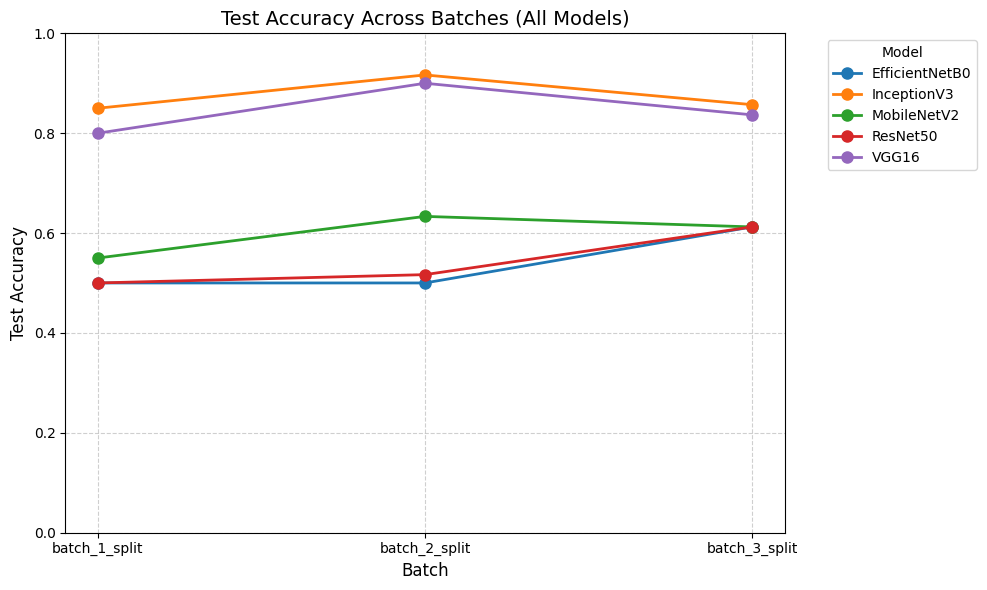


========== AVERAGE MODEL PERFORMANCE ==========
         Model  Test_Accuracy
   InceptionV3       0.874603
         VGG16       0.845578
   MobileNetV2       0.598526
      ResNet50       0.542971
EfficientNetB0       0.537415

🏆 Best Overall Model: InceptionV3  with Mean Accuracy = 0.8746


In [ ]:
# ==============================
# COMBINED PLOT: ALL MODELS ACROSS BATCHES
# ==============================
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)

if df_results.empty:
    print("\nNo evaluation results found — check model loading or paths.")
else:
    print("\n========== MODEL × BATCH TEST ACCURACIES ==========\n")
    print(df_results.sort_values(["Model","Batch"]).to_string(index=False))

    # Pivot so rows = Batch, columns = Model
    pivot_df = df_results.pivot(index="Batch", columns="Model", values="Test_Accuracy")

    # --- Plot ---
    plt.figure(figsize=(10, 6))
    for model in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[model], marker='o', linewidth=2, markersize=8, label=model)

    plt.title("Test Accuracy Across Batches (All Models)", fontsize=14)
    plt.xlabel("Batch", fontsize=12)
    plt.ylabel("Test Accuracy", fontsize=12)
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Optional: print average accuracy for each model
    model_avg = df_results.groupby("Model")["Test_Accuracy"].mean().reset_index().sort_values("Test_Accuracy", ascending=False)
    print("\n========== AVERAGE MODEL PERFORMANCE ==========")
    print(model_avg.to_string(index=False))
    best_model = model_avg.iloc[0]
    print(f"\n Best Overall Model: {best_model['Model']}  "
          f"with Mean Accuracy = {best_model['Test_Accuracy']:.4f}")



========== FINAL TEST ACCURACIES ==========

        Batch          Model  Test_Accuracy
batch_1_split EfficientNetB0       0.500000
batch_1_split    InceptionV3       0.850000
batch_1_split    MobileNetV2       0.550000
batch_1_split       ResNet50       0.500000
batch_1_split          VGG16       0.800000
batch_2_split EfficientNetB0       0.500000
batch_2_split    InceptionV3       0.916667
batch_2_split    MobileNetV2       0.633333
batch_2_split       ResNet50       0.516667
batch_2_split          VGG16       0.900000
batch_3_split EfficientNetB0       0.612245
batch_3_split    InceptionV3       0.857143
batch_3_split    MobileNetV2       0.612245
batch_3_split       ResNet50       0.612245
batch_3_split          VGG16       0.836735

========== BATCH PERFORMANCE SUMMARY ==========
        Batch  Test_Accuracy
batch_1_split       0.640000
batch_2_split       0.693333
batch_3_split       0.706122

🏆 Best Batch: batch_3_split  with Avg Accuracy = 0.7061


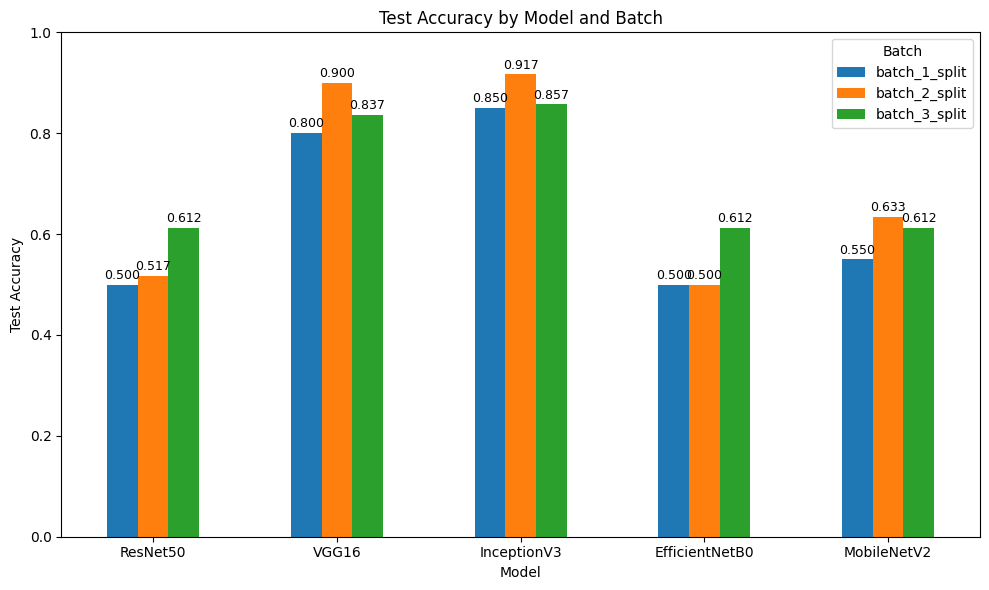

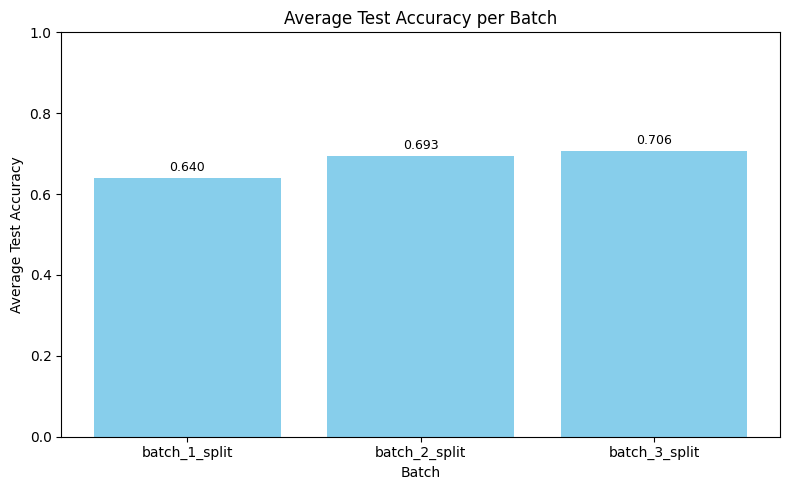

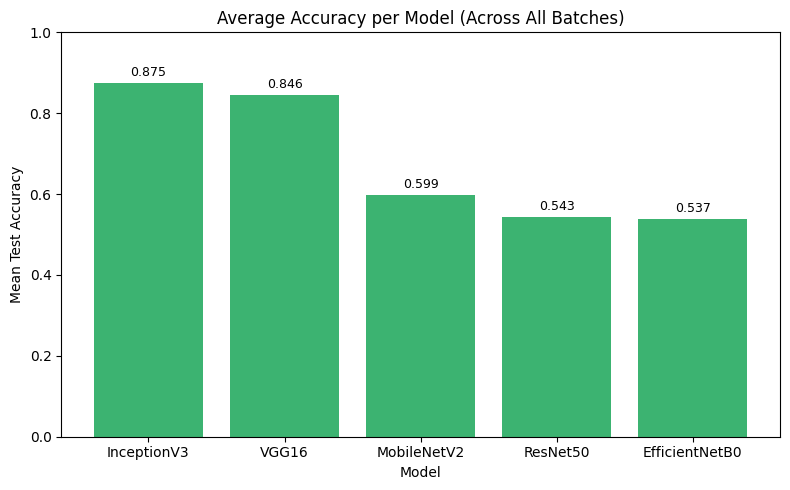

In [ ]:
# ==============================
# RESULTS SUMMARY + PLOTS (with numbers)
# ==============================
import pandas as pd
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)

if df_results.empty:
    print("\nNo evaluation results found — check model loading or paths.")
else:
    print("\n========== FINAL TEST ACCURACIES ==========\n")
    print(df_results.sort_values(["Batch","Model"]).to_string(index=False))

    # ===== Average Accuracy per Batch =====
    batch_avg = df_results.groupby("Batch")["Test_Accuracy"].mean().reset_index()
    best_batch = batch_avg.loc[batch_avg["Test_Accuracy"].idxmax()]

    print("\n========== BATCH PERFORMANCE SUMMARY ==========")
    print(batch_avg.to_string(index=False))
    print("===============================================")
    print(f"\nBest Batch: {best_batch['Batch']}  "
          f"with Avg Accuracy = {best_batch['Test_Accuracy']:.4f}")

    # ===== Plot 1: Grouped bar (Model × Batch) with numbers =====
    pivot = df_results.pivot(index="Model", columns="Batch", values="Test_Accuracy").reindex(model_names)
    ax = pivot.plot(kind="bar", figsize=(10, 6))
    ax.set_title("Test Accuracy by Model and Batch")
    ax.set_xlabel("Model")
    ax.set_ylabel("Test Accuracy")
    ax.set_ylim(0, 1)
    ax.legend(title="Batch")
    plt.xticks(rotation=0)

    # Add text labels (numbers) above each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9, padding=2)

    plt.tight_layout()
    plt.show()

    # ===== Plot 2: Average batch performance (with numbers) =====
    plt.figure(figsize=(8,5))
    bars = plt.bar(batch_avg["Batch"], batch_avg["Test_Accuracy"], color="skyblue")
    plt.title("Average Test Accuracy per Batch")
    plt.xlabel("Batch")
    plt.ylabel("Average Test Accuracy")
    plt.ylim(0, 1)
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h + 0.01, f"{h:.3f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

    # ===== Plot 3: Average Accuracy per Model (with numbers) =====
    plt.figure(figsize=(8,5))
    best_models = df_results.groupby("Model")["Test_Accuracy"].mean().reset_index().sort_values("Test_Accuracy", ascending=False)
    bars = plt.bar(best_models["Model"], best_models["Test_Accuracy"], color="mediumseagreen")
    plt.title("Average Accuracy per Model (Across All Batches)")
    plt.xlabel("Model")
    plt.ylabel("Mean Test Accuracy")
    plt.ylim(0, 1)
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h + 0.01, f"{h:.3f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Convert to DataFrame
df_results = pd.DataFrame(results)

if df_results.empty:
    print("\n⚠️ No results found — check model paths or evaluation logs.")
else:
    # Compute average test accuracy per batch
    batch_avg = df_results.groupby("Batch")["Test_Accuracy"].mean().reset_index()

    # Find best batch (highest mean accuracy)
    best_row = batch_avg.loc[batch_avg["Test_Accuracy"].idxmax()]

    print("\n========== BATCH PERFORMANCE SUMMARY ==========")
    print(batch_avg.to_string(index=False))
    print("===============================================")
    print(f"\nBest Batch: {best_row['Batch']} with Avg Test Accuracy = {best_row['Test_Accuracy']:.4f}")



========== BATCH PERFORMANCE SUMMARY ==========
        Batch  Test_Accuracy
batch_1_split       0.640000
batch_2_split       0.693333
batch_3_split       0.706122

🏆 Best Batch: batch_3_split with Avg Test Accuracy = 0.7061


In [ ]:
!ls "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results"


batch_1_split_EfficientNetB0.keras  batch_2_split_ResNet50.keras
batch_1_split_InceptionV3.keras     batch_2_split_VGG16.keras
batch_1_split_MobileNetV2.keras     batch_3_split_EfficientNetB0.keras
batch_1_split_ResNet50.keras	    batch_3_split_InceptionV3.keras
batch_1_split_VGG16.keras	    batch_3_split_MobileNetV2.keras
batch_2_split_EfficientNetB0.keras  batch_3_split_ResNet50.keras
batch_2_split_InceptionV3.keras     batch_3_split_VGG16.keras
batch_2_split_MobileNetV2.keras


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# CONFIG
model_root = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results"
IMG_SIZE = (224, 224)

# --- focal_loss_fixed definition (if needed) ---
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

custom_objects = {"focal_loss_fixed": focal_loss_fixed}

# -------- Robust loader (recursively scan) ----------
def load_all_models(root_dir, prefix_filter=None, custom_objects=None):
    loaded = []
    failed = []
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"Model root not found: {root_dir}")

    # scan for .keras files recursively
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for fname in sorted(filenames):
            if not fname.endswith(".keras"):
                continue
            if prefix_filter and prefix_filter not in fname:
                continue
            path = os.path.join(dirpath, fname)
            try:
                print(f"Loading model: {path}")
                # pass custom_objects only if provided
                m = load_model(path, custom_objects=custom_objects or {})
                loaded.append((path, m))
            except Exception as e:
                print(f"ERROR loading {path}: {e}")
                failed.append((path, str(e)))
    print(f"\nLoaded {len(loaded)} models, failed to load {len(failed)} models.")
    if failed:
        print("Failed files (first 5):")
        for p, err in failed[:5]:
            print(" -", p, "->", err)
    return loaded

# Load models
loaded_pairs = load_all_models(model_root, custom_objects=custom_objects)
ensemble_models = [m for (_, m) in loaded_pairs]  # list of model objects

# ====== helper: prepare image =========
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# ====== robust ensemble predict: handle different output shapes ========
def _model_positive_prob(pred_array):
    """
    Convert model output array (shape (1,), (1,1), (1,2), (1,n)) to a scalar
    probability of the 'positive' class (assumed class index 1 for softmax).
    Heuristics:
     - shape (1,) or (1,1): treat element as prob of positive class (sigmoid)
     - shape (1,2): treat second element as prob(positive) (softmax)
     - shape (1,n>2): pick max index and return its prob OR return second idx if known mapping
    """
    arr = np.asarray(pred_array)
    if arr.ndim == 1:
        # (n,) -> assume single sample, n==1 or n==2
        if arr.size == 1:
            return float(arr[0])   # sigmoid prob
        elif arr.size == 2:
            return float(arr[1])   # softmax: second element is positive class
        else:
            # fallback: return max prob index
            return float(np.max(arr))
    elif arr.ndim == 2:
        # (1, n)
        n = arr.shape[1]
        if n == 1:
            return float(arr[0,0])
        elif n == 2:
            return float(arr[0,1])
        else:
            # fallback: return max probability of the row
            return float(np.max(arr[0]))
    else:
        # unexpected shape: flatten and use first element
        return float(arr.flatten()[0])

def ensemble_predict(models, img_array, verbose=False):
    if not models:
        raise ValueError("No models provided to ensemble_predict.")
    probs = []
    for i, m in enumerate(models):
        try:
            pred = m.predict(img_array, verbose=0)
            pos = _model_positive_prob(pred)
            probs.append(pos)
            if verbose:
                print(f" Model {i} ({getattr(m, 'name', 'model')}): raw_out_shape={np.shape(pred)}, pos_prob={pos:.4f}")
        except Exception as e:
            print(f" Prediction error for model {i}: {e} -- skipping this model")
            continue
    if not probs:
        raise RuntimeError("No successful predictions from any model in the ensemble.")
    avg = float(np.mean(probs))
    return avg, probs

# === final classifier function for clean vs non-clean ===
def classify_clean_vs_nonclean(img_path, models=ensemble_models, threshold=0.5, verbose=False):
    x = prepare_image(img_path)
    avg, all_probs = ensemble_predict(models, x, verbose=verbose)
    if verbose:
        print("Individual probs:", [round(p,4) for p in all_probs])
        print("Average prob:", round(avg,4))
    label = "Non-Clean" if avg >= threshold else "Clean"
    return label, avg, all_probs


Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_EfficientNetB0.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_InceptionV3.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_MobileNetV2.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_ResNet50.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split_VGG16.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_2_split_EfficientNetB0.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetec

Found 60 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 49 images belonging to 2 classes.

✅ Total test images collected: 169



🎯 Ensemble Test Accuracy (Non-Defective subset): 75.15%

Classification Report:
              precision    recall  f1-score   support

       Clean       0.68      1.00      0.81        90
   Non-Clean       1.00      0.47      0.64        79

    accuracy                           0.75       169
   macro avg       0.84      0.73      0.72       169
weighted avg       0.83      0.75      0.73       169



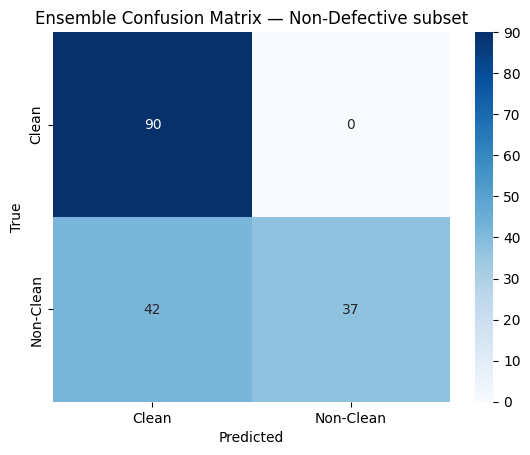

In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt

# =========================================================
# CONFIG
# =========================================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits"
batches = ["batch_1_split", "batch_2_split", "batch_3_split"]

# =========================================================
# CREATE TEST GENERATOR (combined test sets)
# =========================================================
datagen = ImageDataGenerator(rescale=1./255)

test_images = []
test_labels = []

for batch in batches:
    test_dir = os.path.join(base_dir, batch, "test")
    gen = datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='binary',
        shuffle=False
    )
    # Collect all filepaths and labels
    for i, path in enumerate(gen.filepaths):
        test_images.append(path)
        test_labels.append(gen.classes[i])

test_labels = np.array(test_labels)
print(f"\nTotal test images collected: {len(test_images)}")

# =========================================================
# PREDICT FUNCTION (use ensemble of 15 models)
# =========================================================
def predict_single_image(img_path, models):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    probs = []
    for m in models:
        try:
            p = m.predict(x, verbose=0)
            if p.ndim == 2:
                p = p[0, 0]  # handle shape (1,1)
            elif p.ndim == 1:
                p = p[0]
            probs.append(p)
        except Exception as e:
            print(f"Prediction failed for {getattr(m,'name','model')}: {e}")
    if len(probs) == 0:
        return 0.5  # neutral fallback
    return np.mean(probs)

# =========================================================
# RUN ENSEMBLE ON TEST SET
# =========================================================
y_pred_probs = []
for path in test_images:
    y_pred_probs.append(predict_single_image(path, ensemble_models))

y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs >= 0.5).astype(int)

# =========================================================
# METRICS
# =========================================================
acc = accuracy_score(test_labels, y_pred)
print(f"\n🎯 Ensemble Test Accuracy (Non-Defective subset): {acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=["Clean", "Non-Clean"]))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Clean", "Non-Clean"],
            yticklabels=["Clean", "Non-Clean"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Ensemble Confusion Matrix — Non-Defective subset")
plt.show()


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_1_split/test/Clean/Clean (150).jpg"
result = classify_clean_vs_nonclean(test_image)



Individual model predictions:
[np.float32(0.363), np.float32(0.003), np.float32(0.0005), np.float32(0.4837), np.float32(0.0643), np.float32(0.4617), np.float32(0.018), np.float32(0.0004), np.float32(0.5077), np.float32(0.0781), np.float32(0.1266), np.float32(0.0), np.float32(0.3974), np.float32(0.1748)]

Average ensemble prediction: 0.1914
Ensemble Prediction: Clean


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_3_split/test/Clean/Clean (28).jpg"
result = classify_clean_vs_nonclean(test_image)



Individual model predictions:
[np.float32(0.2981), np.float32(0.2484), np.float32(0.0017), np.float32(0.4842), np.float32(0.2471), np.float32(0.4626), np.float32(0.0148), np.float32(0.0003), np.float32(0.5081), np.float32(0.0036), np.float32(0.3266), np.float32(0.0), np.float32(0.3964), np.float32(0.1158)]

Average ensemble prediction: 0.2220
Ensemble Prediction: Clean


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_3_split/test/NonClean/Bird (74).jpg"
result = classify_clean_vs_nonclean(test_image)



Individual model predictions:
[np.float32(0.3541), np.float32(0.9901), np.float32(0.9999), np.float32(0.4865), np.float32(0.2287), np.float32(0.463), np.float32(0.9893), np.float32(0.9888), np.float32(0.5101), np.float32(0.4138), np.float32(0.9594), np.float32(0.9914), np.float32(0.3978), np.float32(0.1395)]

Average ensemble prediction: 0.6366
Ensemble Prediction: Non-Clean


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_3_split/test/NonClean/Dust (97).jpg"
result = classify_clean_vs_nonclean(test_image)



Individual model predictions:
[np.float32(0.3347), np.float32(0.994), np.float32(0.9865), np.float32(0.4839), np.float32(0.1191), np.float32(0.4699), np.float32(0.9501), np.float32(0.9621), np.float32(0.507), np.float32(0.0474), np.float32(0.8875), np.float32(0.6487), np.float32(0.3972), np.float32(0.4036)]

Average ensemble prediction: 0.5851
Ensemble Prediction: Non-Clean


In [ ]:
print(train_data.class_indices)


{'Clean': 0, 'NonClean': 1}


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

# === CONFIGURATION ===
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
nondef_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results"
IMG_SIZE = (224, 224)

# --- Define focal loss (if used during training) ---
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)

# === LOAD MODELS ===
def load_ensemble_models(model_dir):
    models = []
    keras_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".keras")])
    if not keras_files:
        raise FileNotFoundError(f"No .keras models found in {model_dir}")

    for f in keras_files:
        path = os.path.join(model_dir, f)
        print(f"Loading model: {path}")
        try:
            model = load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed})
            models.append(model)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    print(f"Loaded {len(models)} models from {model_dir}")
    return models


# Load model ensembles for all 3 stages
print("\n--- Loading Binary Models ---")
binary_models = load_ensemble_models(binary_models_dir)

print("\n--- Loading Defect Type Models ---")
defect_models = load_ensemble_models(defect_models_dir)

print("\n--- Loading Non-Defective Models ---")
nondef_models = load_ensemble_models(nondef_models_dir)

# === UTILITY FUNCTIONS ===
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred

def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# === FINAL PIPELINE ===
def classify_image(img_path):
    print(f"\nAnalyzing image: {os.path.basename(img_path)}")
    img_array = prepare_image(img_path)

    # === STAGE 1: Binary (Defective / Non-Defective) ===
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]  # sigmoid output
    print(f"Binary probability (Non-Defective): {binary_prob:.3f}")

    if binary_prob < 0.5:
        binary_label = "Defective"
    else:
        binary_label = "Non-Defective"

    # === STAGE 2A: Defect classification ===
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        print(f"Defect probabilities: {defect_pred}")
        final_label = f"Defective → {defect_label}"

    # === STAGE 2B: Non-defective classification ===
    else:
        nondef_pred = ensemble_predict(nondef_models, img_array)
        nondef_prob = nondef_pred[0][0]
        print(f"Non-Defective probability (Non-Clean): {nondef_prob:.3f}")

        if nondef_prob >= 0.5:
            nondef_label = "Non-Clean"
        else:
            nondef_label = "Clean"

        final_label = f"Non-Defective → {nondef_label}"

    print(f"\nFINAL PREDICTION: {final_label}")
    return final_label



--- Loading Binary Models ---
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_EfficientNetB0.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_InceptionV3.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_MobileNetV2.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_ResNet50.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_EfficientNetB0.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved op

Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_InceptionV3.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_MobileNetV2.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_ResNet50.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_VGG16.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_EfficientNetB0.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_InceptionV3.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/Spl

In [ ]:
# ===========================================================
# PIPELINE TEST EVALUATION (Binary + Defect + Nondef)
# ===========================================================
import os
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# --- Define where your test sets are ---
binary_test_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses"
defect_test_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test"
nondef_base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits"
nondef_batches = ["batch_1_split", "batch_2_split", "batch_3_split"]

# --- Collect test images and ground truth ---
test_images, true_labels = [], []

# DEFECTIVE TEST IMAGES
for cls in os.listdir(defect_test_dir):
    cls_dir = os.path.join(defect_test_dir, cls)
    if os.path.isdir(cls_dir):
        for f in os.listdir(cls_dir):
            if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                test_images.append(os.path.join(cls_dir, f))
                if "electrical" in cls.lower():
                    true_labels.append("Defective → Electrical-damage")
                else:
                    true_labels.append("Defective → Physical-damage")

# NON-DEFECTIVE TEST IMAGES
for b in nondef_batches:
    test_dir = os.path.join(nondef_base_dir, b, "test")
    if os.path.exists(test_dir):
        for cls in os.listdir(test_dir):
            cls_dir = os.path.join(test_dir, cls)
            if os.path.isdir(cls_dir):
                for f in os.listdir(cls_dir):
                    if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                        test_images.append(os.path.join(cls_dir, f))
                        if "clean" in cls.lower():
                            true_labels.append("Non-Defective → Clean")
                        else:
                            true_labels.append("Non-Defective → Non-Clean")

# --- Run predictions ---
pred_labels = []
for path in test_images:
    try:
        pred = classify_image(path)
        pred_labels.append(pred)
    except Exception as e:
        print(f"Error on {path}: {e}")
        pred_labels.append("Error")

# --- Compute accuracies ---
def to_binary(label):
    if label.startswith("Defective"):
        return "Defective"
    elif label.startswith("Non-Defective"):
        return "Non-Defective"
    return label

binary_true = [to_binary(l) for l in true_labels]
binary_pred = [to_binary(l) for l in pred_labels]

# Overall pipeline accuracy
overall_acc = accuracy_score(true_labels, pred_labels)
binary_acc = accuracy_score(binary_true, binary_pred)

# Subset accuracies
defective_idx = [i for i, l in enumerate(true_labels) if l.startswith("Defective")]
nondef_idx = [i for i, l in enumerate(true_labels) if l.startswith("Non-Defective")]

def_acc = accuracy_score([true_labels[i] for i in defective_idx],
                         [pred_labels[i] for i in defective_idx]) if defective_idx else 0
nondef_acc = accuracy_score([true_labels[i] for i in nondef_idx],
                            [pred_labels[i] for i in nondef_idx]) if nondef_idx else 0

# --- Print results ---
print("\n=================== PIPELINE TEST RESULTS ===================")
print(f"Total test samples: {len(test_images)}")
print(f"Overall Final Accuracy: {overall_acc*100:.2f}%")
print(f"Binary Stage Accuracy (Defective vs Non-Defective): {binary_acc*100:.2f}%")
print(f"Defective Subset Accuracy (Electrical vs Physical): {def_acc*100:.2f}%")
print(f"Non-Defective Subset Accuracy (Clean vs Non-Clean): {nondef_acc*100:.2f}%")
print("==============================================================")



Analyzing image: Electrical (78).jpg
Binary probability (Non-Defective): 0.375
Defect probabilities: [[0.6200624 0.3799376]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (82).jpg
Binary probability (Non-Defective): 0.358
Defect probabilities: [[0.5831219  0.41687813]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (73).JPG
Binary probability (Non-Defective): 0.388
Defect probabilities: [[0.476386 0.523614]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (51).jpg
Binary probability (Non-Defective): 0.451
Defect probabilities: [[0.59968376 0.40031624]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (41).jpg
Binary probability (Non-Defective): 0.415
Defect probabilities: [[0.7017163  0.29828376]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (50).jpg
Binary probability (Non-Defective): 0.391
Defect probabilities: [[0.6750877 0.3249123

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def evaluate_ensemble(models, test_dir, target_size=(224,224), class_mode="binary", batch_size=32):
    if not models:
        print("⚠️ No models passed to evaluate_ensemble().")
        return None

    print(f"\n=== Evaluating Ensemble on: {test_dir} ===")
    datagen = ImageDataGenerator(rescale=1./255)
    test_gen = datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=False
    )
    if test_gen.n == 0:
        print("⚠️ No images found in test_dir.")
        return None

    # Predict with each model (reset generator each time)
    preds_list = []
    for i, m in enumerate(models, 1):
        test_gen.reset()
        p = m.predict(test_gen, verbose=0)
        preds_list.append(p)

    preds = np.mean(preds_list, axis=0)

    # Build y_true / y_pred
    y_true = test_gen.classes
    if class_mode == "binary":
        # handle shape (N,1) or (N,)
        y_pred = (preds.ravel() > 0.5).astype(int)
    else:
        y_pred = np.argmax(preds, axis=1)

    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Ensemble Accuracy: {acc:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    return acc


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_1_split/test/Clean/Clean (150).jpg"
result = classify_image(test_image)



Analyzing image: Clean (150).jpg


Binary probability (Non-Defective): 0.625
Non-Defective probability (Non-Clean): 0.191

FINAL PREDICTION: Non-Defective → Clean


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_3_split/test/NonClean/Bird (74).jpg"
result = classify_image(test_image)



Analyzing image: Bird (74).jpg
Binary probability (Non-Defective): 0.666
Non-Defective probability (Non-Clean): 0.637

FINAL PREDICTION: Non-Defective → Non-Clean


In [ ]:
import os

base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean"

# Valid image extensions
exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

counts = {}
total = 0

for category in sorted(os.listdir(base_dir)):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path):
        num_images = sum(1 for f in os.listdir(category_path) if f.endswith(exts))
        counts[category] = num_images
        total += num_images

print("Image counts per Non-Clean category:")
for k, v in counts.items():
    print(f"  {k}: {v} images")

print(f"\nTotal Non-Clean images: {total}")


📊 Image counts per Non-Clean category:
  Bird-drop: 191 images
  Dusty: 190 images
  Snow-Covered: 123 images

Total Non-Clean images: 504


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
from PIL import Image

# Paths
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean"
augmented_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented"
os.makedirs(augmented_dir, exist_ok=True)

# Image generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

IMG_SIZE = (224, 224)
target_count = 191
exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

for cls in sorted(os.listdir(base_dir)):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    files = [f for f in os.listdir(cls_path) if f.endswith(exts)]
    count = len(files)
    save_dir = os.path.join(augmented_dir, cls)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nProcessing '{cls}' — {count} original images")

    # Copy originals safely
    for f in files:
        src = os.path.join(cls_path, f)
        img = Image.open(src)
        if img.mode != "RGB":
            img = img.convert("RGB")
        img.save(os.path.join(save_dir, f))

    # Augment if needed
    if count < target_count:
        num_needed = target_count - count
        print(f"  Augmenting {num_needed} more images...")

        i = 0
        while i < num_needed:
            img_path = os.path.join(cls_path, files[i % count])
            img = load_img(img_path, target_size=IMG_SIZE)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            aug_iter = datagen.flow(x, batch_size=1)
            aug_img = next(aug_iter)[0].astype('uint8')

            # Convert to RGB before saving
            aug_img_pil = Image.fromarray(aug_img)
            if aug_img_pil.mode != "RGB":
                aug_img_pil = aug_img_pil.convert("RGB")

            save_path = os.path.join(save_dir, f"aug_{i+1}_{files[i % count]}")
            aug_img_pil.save(save_path, "JPEG")
            i += 1

    print(f"Done: {len(os.listdir(save_dir))} images total")

print("\nAugmentation complete! All classes have 191 images.")



Processing 'Bird-drop' — 191 original images
Done: 191 images total

Processing 'Dusty' — 190 original images
  Augmenting 1 more images...
Done: 191 images total

Processing 'Snow-Covered' — 123 original images
  Augmenting 68 more images...
Done: 191 images total

Augmentation complete! All classes have 191 images.


In [ ]:
import os
import shutil
import random

# Base and output directories
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented"
output_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split"

splits = ["train", "val", "test"]
ratios = [0.7, 0.15, 0.15]

# Create split directories
for split in splits:
    for cls in os.listdir(base_dir):
        src = os.path.join(base_dir, cls)
        if not os.path.isdir(src):
            continue
        dst = os.path.join(output_dir, split, cls)
        os.makedirs(dst, exist_ok=True)

# Supported extensions
exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

# Split per class
for cls in sorted(os.listdir(base_dir)):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = [f for f in os.listdir(cls_path) if f.endswith(exts)]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * ratios[0])
    n_val = int(n_total * ratios[1])
    n_test = n_total - n_train - n_val

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    print(f"\nClass '{cls}': {n_total} images")
    print(f" → Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    # Copy files
    for split, file_list in zip(splits, [train_imgs, val_imgs, test_imgs]):
        for f in file_list:
            src = os.path.join(cls_path, f)
            dst = os.path.join(output_dir, split, cls, f)
            shutil.copy2(src, dst)

print("\nDataset successfully split into 70/15/15!")
print(f"Saved to: {output_dir}")



Class 'Bird-drop': 191 images
 → Train: 133, Val: 28, Test: 30

Class 'Dusty': 191 images
 → Train: 133, Val: 28, Test: 30

Class 'Non-Clean_Split': 0 images
 → Train: 0, Val: 0, Test: 0

Class 'Snow-Covered': 191 images
 → Train: 133, Val: 28, Test: 30

Dataset successfully split into 70/15/15!
Saved to: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# ==========================
# CONFIG
# ==========================
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split"
model_save_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models"
os.makedirs(model_save_dir, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 25
LR = 1e-4

# ==========================
# DATA GENERATORS
# ==========================
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen_val_test = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
val_gen = datagen_val_test.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
test_gen = datagen_val_test.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\nClass indices:", train_gen.class_indices)

# ==========================
# MODEL TRAINING FUNCTION
# ==========================
def build_and_train(model_name, base_model_fn):
    print(f"\nTraining {model_name}...")

    # Base model
    base_model = base_model_fn(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False  # Freeze base layers

    # Custom head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(3, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=LR),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Callbacks
    checkpoint_path = os.path.join(model_save_dir, f"{model_name}.keras")
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_accuracy", mode="max"),
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max")
    ]

    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    loss, acc = model.evaluate(test_gen, verbose=0)
    print(f"{model_name} Test Accuracy: {acc:.4f}")

    return model_name, acc

# ==========================
# MODEL LIST
# ==========================
models_to_train = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0,
    "MobileNetV2": MobileNetV2
}

results = {}
for name, fn in models_to_train.items():
    model_name, acc = build_and_train(name, fn)
    results[model_name] = acc

# ==========================
# FINAL RESULTS
# ==========================
print("\n====================== RESULTS ======================")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")
print("=====================================================")
print(f"Models saved to: {model_save_dir}")


Found 399 images belonging to 3 classes.
Found 84 images belonging to 3 classes.
Found 90 images belonging to 3 classes.

Class indices: {'Bird-drop': 0, 'Dusty': 1, 'Snow-Covered': 2}

Training ResNet50...
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 918ms/step - accuracy: 0.3398 - loss: 1.4630 - val_accuracy: 0.3333 - val_loss: 1.2367
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - accuracy: 0.3571 - loss: 1.2729 - val_accuracy: 0.3333 - val_loss: 1.1413
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.3307 - loss: 1.2207 - val_accuracy: 0.2857 - val_loss: 1.1207
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.3085 - loss: 1.2244 - val_accuracy: 0.2619 - val_loss: 1.1157
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.2576 - loss: 1.2420 - val_accuracy: 0.3095 - val_loss: 1.1134
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.3217 - loss: 1.1904 - val_accuracy: 0.3095 - val_loss: 1.1106
ResNet50 Test Accur

Found 90 images belonging to 3 classes.

Class indices: {'Bird-drop': 0, 'Dusty': 1, 'Snow-Covered': 2}

Evaluating EfficientNetB0.keras ...
✅ EfficientNetB0 — Test Accuracy: 0.2444

Evaluating InceptionV3.keras ...
✅ InceptionV3 — Test Accuracy: 0.7778

Evaluating MobileNetV2.keras ...
✅ MobileNetV2 — Test Accuracy: 0.8111

Evaluating ResNet50.keras ...
✅ ResNet50 — Test Accuracy: 0.3444

Evaluating VGG16.keras ...
✅ VGG16 — Test Accuracy: 0.6889

====================== FINAL RESULTS ======================
EfficientNetB0: 0.2444
InceptionV3: 0.7778
MobileNetV2: 0.8111
ResNet50: 0.3444
VGG16: 0.6889


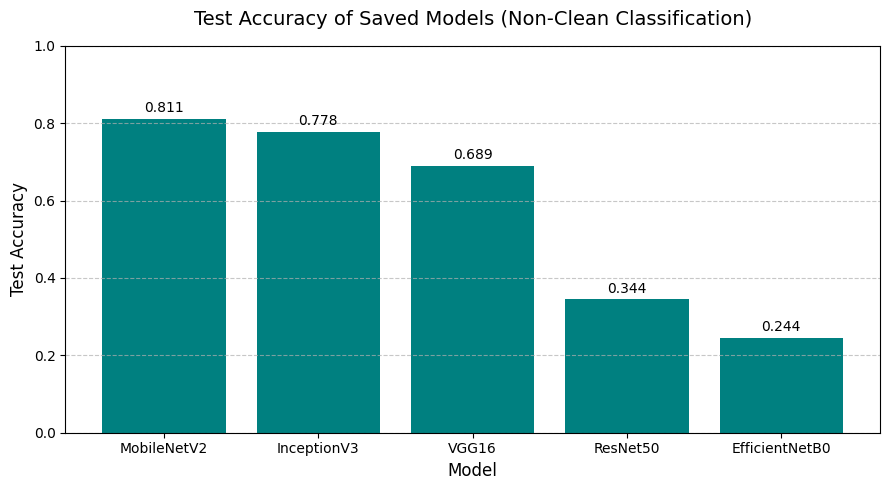

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==========================
# CONFIG
# ==========================
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split"
model_dir = os.path.join(base_dir, "Non-Clean_Models")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# ==========================
# LOAD TEST DATA
# ==========================
test_dir = os.path.join(base_dir, "test")
datagen = ImageDataGenerator(rescale=1./255)
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
print("\nClass indices:", test_gen.class_indices)

# ==========================
# EVALUATE ALL SAVED MODELS
# ==========================
results = {}
for file in sorted(os.listdir(model_dir)):
    if file.endswith(".keras"):
        model_path = os.path.join(model_dir, file)
        print(f"\nEvaluating {file} ...")
        try:
            model = load_model(model_path)
            loss, acc = model.evaluate(test_gen, verbose=0)
            model_name = os.path.splitext(file)[0]
            results[model_name] = acc
            print(f"✅ {model_name} — Test Accuracy: {acc:.4f}")
        except Exception as e:
            print(f"⚠️ Skipping {file} due to error: {e}")

# ==========================
# RESULTS SUMMARY
# ==========================
if not results:
    print("\n⚠️ No models evaluated. Check model_dir path or file format.")
else:
    print("\n====================== FINAL RESULTS ======================")
    for name, acc in results.items():
        print(f"{name}: {acc:.4f}")
    print("===========================================================")

    # ==========================
    # PLOT TEST ACCURACIES
    # ==========================
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
    model_names = list(sorted_results.keys())
    accuracies = list(sorted_results.values())

    plt.figure(figsize=(9,5))
    bars = plt.bar(model_names, accuracies, color="teal")
    plt.title("Test Accuracy of Saved Models (Non-Clean Classification)", fontsize=14, pad=15)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Test Accuracy", fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add numeric accuracy labels on bars
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h + 0.01, f"{h:.3f}", ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    plt.show()


In [ ]:
!find "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split" -type d -name ".ipynb_checkpoints" -exec rm -rf {} +
!find "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split" -type f -name "desktop.ini" -delete


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# === CONFIG ===
model_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models"
IMG_SIZE = (224, 224)

# === LOAD MODELS ===
def load_ensemble_models(model_dir):
    models = []
    for f in sorted(os.listdir(model_dir)):
        if f.endswith(".keras"):
            path = os.path.join(model_dir, f)
            print("Loading:", path)
            models.append(load_model(path))
    print(f"Loaded {len(models)} models from {model_dir}")
    return models

# === IMAGE PREPROCESSING ===
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# === ENSEMBLE PREDICTION ===
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred

# === CLASSIFY FUNCTION ===
def classify_image(img_path, models):
    print(f"\n🔍 Analyzing image: {os.path.basename(img_path)}")
    img_array = prepare_image(img_path)
    pred = ensemble_predict(models, img_array)

    class_labels = ['Bird-drop', 'Dusty', 'Snow-Covered']
    predicted_class = class_labels[np.argmax(pred)]
    probs = {class_labels[i]: float(pred[0][i]) for i in range(len(class_labels))}

    print(f"Prediction: {predicted_class}")
    print("Probabilities:", probs)
    return predicted_class, probs

# === MAIN TEST ===
if __name__ == "__main__":
    # Load ensemble
    models = load_ensemble_models(model_dir)

    # Test with one image

Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/EfficientNetB0.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/VGG16.keras
Loaded 5 models from /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models


Loading /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/EfficientNetB0.keras
Loading /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/InceptionV3.keras
Loading /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/MobileNetV2.keras
Loading /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/ResNet50.keras
Loading /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/VGG16.keras
Loaded 5 models.
Found 90 test images across 3 classes.

Ensemble Test Accuracy: 82.22%

Classification Report:
              precision    recall  f1-score   support

   Bird-drop       0.77      

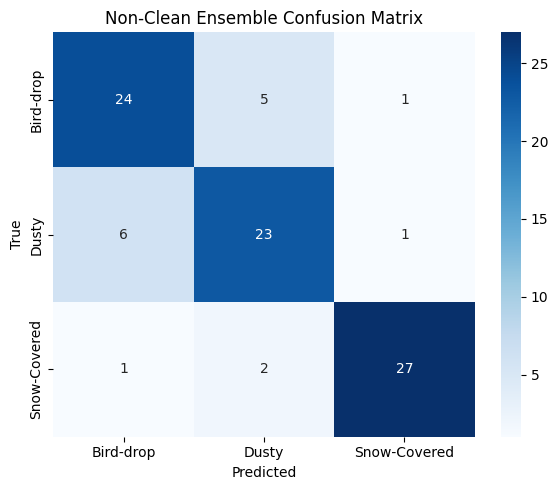

Saved confusion matrix to /content/nonclean_ensemble_cm.png
Saved per-image results to /content/nonclean_ensemble_results.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# === CONFIG ===
model_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models"
# derive test_dir as sibling "test" to the parent of model_dir
parent_dir = os.path.dirname(model_dir)  # .../Non-Clean_Split
test_dir = os.path.join(parent_dir, "test")
IMG_SIZE = (224, 224)
CLASS_LABELS = ['Bird-drop', 'Dusty', 'Snow-Covered']  # from your train_gen.class_indices

OUT_CSV = "/content/nonclean_ensemble_results.csv"
OUT_CM = "/content/nonclean_ensemble_cm.png"

# === load models ===
models = []
for f in sorted(os.listdir(model_dir)):
    if f.endswith(".keras"):
        p = os.path.join(model_dir, f)
        try:
            print("Loading", p)
            models.append(load_model(p))
        except Exception as e:
            print("Failed to load", p, "->", e)
print(f"Loaded {len(models)} models.")

if len(models) == 0:
    raise RuntimeError("No models loaded. Check model_dir path and .keras files.")

# === helpers ===
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    return x

def model_positive_probs(pred):
    """Normalize model output to shape (1, num_classes) probabilities."""
    arr = np.asarray(pred)
    # If shape (1,n) or (n,) -> return row or expand
    if arr.ndim == 2:
        return arr  # (1,n)
    if arr.ndim == 1:
        # (n,) -> make (1,n)
        return arr.reshape(1, -1)
    # unexpected shape: flatten and try to split into classes
    flat = arr.flatten()
    if flat.size == 1:
        # single sigmoid -> interpret as prob for positive class; but we need vector of length 3
        # fallback: return neutral/uniform distribution (avoid crash)
        return np.ones((1, len(CLASS_LABELS))) / len(CLASS_LABELS)
    # else make 1 x n
    return flat.reshape(1, -1)

def ensemble_predict(models, img_array):
    probs_list = []
    for m in models:
        try:
            p = m.predict(img_array, verbose=0)
            p_norm = model_positive_probs(p)
            # If model outputs fewer/more classes, try to adapt:
            if p_norm.shape[1] == len(CLASS_LABELS):
                probs_list.append(p_norm[0])
            else:
                # If model has 1 output (sigmoid) or 2 outputs, try mapping heuristics:
                # - If 1 output: treat as probability of class index 1 -> distribute conservatively
                # - If 2 outputs: map second value to some class (not reliable). Here: expand to uniform fallback.
                # Best option: skip mismatched models (warn) to avoid corrupting average.
                print(f"Warning: model {getattr(m,'name',None)} outputs {p_norm.shape[1]} probs (expected {len(CLASS_LABELS)}). Skipping it in ensemble.")
        except Exception as e:
            print("Prediction error for model:", e)
    if len(probs_list) == 0:
        raise RuntimeError("No compatible model outputs (expected softmax over 3 classes).")
    avg = np.mean(probs_list, axis=0)  # averaged vector length = num_classes
    return avg

# === collect test images and true labels ===
image_paths = []
true_labels = []

for cls in sorted(os.listdir(test_dir)):
    cls_dir = os.path.join(test_dir, cls)
    if not os.path.isdir(cls_dir):
        continue
    for fname in sorted(os.listdir(cls_dir)):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_paths.append(os.path.join(cls_dir, fname))
            true_labels.append(cls)

print(f"Found {len(image_paths)} test images across {len(set(true_labels))} classes.")

# === run ensemble predictions ===
preds = []
pred_probs = []
for p in image_paths:
    x = prepare_image(p)
    avg = ensemble_predict(models, x)  # vector of length 3
    pred_idx = int(np.argmax(avg))
    preds.append(CLASS_LABELS[pred_idx])
    pred_probs.append({CLASS_LABELS[i]: float(avg[i]) for i in range(len(CLASS_LABELS))})

# === metrics ===
acc = accuracy_score(true_labels, preds)
print(f"\nEnsemble Test Accuracy: {acc*100:.2f}%\n")

print("Classification Report:")
print(classification_report(true_labels, preds, target_names=CLASS_LABELS))

# confusion matrix
cm = confusion_matrix(true_labels, preds, labels=CLASS_LABELS)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Non-Clean Ensemble Confusion Matrix")
plt.tight_layout()
plt.savefig(OUT_CM, dpi=200)
plt.show()
print(f"Saved confusion matrix to {OUT_CM}")

# === save per-image csv ===
rows = []
for path, t, pr, prob in zip(image_paths, true_labels, preds, pred_probs):
    rows.append({
        "filepath": path,
        "true_label": t,
        "pred_label": pr,
        "prob_Bird-drop": prob["Bird-drop"],
        "prob_Dusty": prob["Dusty"],
        "prob_Snow-Covered": prob["Snow-Covered"]
    })
df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
print(f"Saved per-image results to {OUT_CSV}")


In [ ]:
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/test/Dusty/Dust (140).jpg"
classify_image(test_image, models)



🔍 Analyzing image: Dust (140).jpg
Prediction: Dusty
Probabilities: {'Bird-drop': 0.2251347005367279, 'Dusty': 0.5115109086036682, 'Snow-Covered': 0.2633543610572815}


('Dusty',
 {'Bird-drop': 0.2251347005367279,
  'Dusty': 0.5115109086036682,
  'Snow-Covered': 0.2633543610572815})

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 722.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 145.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 131.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

# =====================================================
# CONFIGURATION
# =====================================================
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
nondef_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results"
nonclean_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models"

IMG_SIZE = (224, 224)

# =====================================================
# CUSTOM LOSS (if used)
# =====================================================
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)

# =====================================================
# MODEL LOADER
# =====================================================
def load_ensemble_models(model_dir):
    """
    Loads all valid .keras or .h5 models from the given directory.
    Skips any missing or corrupted files gracefully.
    """
    import traceback

    models = []
    valid_exts = (".keras", ".h5")

    if not os.path.exists(model_dir):
        print(f"Directory not found: {model_dir}")
        return models

    files = sorted([f for f in os.listdir(model_dir) if f.endswith(valid_exts)])
    if not files:
        print(f"No .keras or .h5 models found in: {model_dir}")
        return models

    for f in files:
        path = os.path.join(model_dir, f)
        try:
            print(f"Loading: {path}")
            model = load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed})
            models.append(model)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")
            traceback.print_exc(limit=1)

    print(f"Successfully loaded {len(models)} model(s) from {model_dir}")
    return models


print("\n--- Loading Models ---")
binary_models = load_ensemble_models(binary_models_dir)
defect_models = load_ensemble_models(defect_models_dir)
nondef_models = load_ensemble_models(nondef_models_dir)
nonclean_models = load_ensemble_models(nonclean_models_dir)

# =====================================================
# UTILITY FUNCTIONS
# =====================================================
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred

def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# =====================================================
# FINAL MULTI-STAGE CLASSIFICATION PIPELINE
# =====================================================
def classify_image(img_path):
    print(f"\nAnalyzing image: {os.path.basename(img_path)}")
    img_array = prepare_image(img_path)

    # --- STAGE 1: Defective or Non-Defective ---
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]
    print(f"Binary probability (Non-Defective): {binary_prob:.3f}")
    binary_label = "Defective" if binary_prob < 0.5 else "Non-Defective"

    # --- STAGE 2A: If Defective, classify defect type ---
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        print(f"Defect probabilities: {defect_pred}")
        final_label = f"Defective → {defect_label}"

    # --- STAGE 2B: If Non-Defective, check Clean vs Non-Clean ---
    else:
        nondef_pred = ensemble_predict(nondef_models, img_array)
        nondef_prob = nondef_pred[0][0]
        print(f"Non-Defective probability (Non-Clean): {nondef_prob:.3f}")
        nondef_label = "Non-Clean" if nondef_prob >= 0.5 else "Clean"

        if nondef_label == "Clean":
            final_label = "Non-Defective → Clean"
        else:
            # --- STAGE 2C: If Non-Clean, classify which type ---
            nonclean_pred = ensemble_predict(nonclean_models, img_array)
            class_labels = ["Bird-drop", "Dusty", "Snow-Covered"]
            sub_idx = np.argmax(nonclean_pred)
            sub_label = class_labels[sub_idx]
            print(f"Non-Clean probabilities: {nonclean_pred}")
            final_label = f"Non-Defective → Non-Clean → {sub_label}"

    print(f"\nFINAL PREDICTION: {final_label}")
    return final_label


# =====================================================
# TEST RUN
# =====================================================


--- Loading Models ---
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_EfficientNetB0.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_EfficientNetB0.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batc

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved op

Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_VGG16.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_EfficientNetB0.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_MobileNetV2.keras
Loadi

In [ ]:
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/test/Dusty/Dust (140).jpg"
classify_image(test_image)



Analyzing image: Dust (140).jpg


Binary probability (Non-Defective): 0.682
Non-Defective probability (Non-Clean): 0.501
Non-Clean probabilities: [[0.2251347  0.5115109  0.26335436]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty


'Non-Defective → Non-Clean → Dusty'

In [ ]:
save_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/final_inference_script.py"
script_content = """import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
nondef_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results"
nonclean_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models"
IMG_SIZE = (224, 224)
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))
register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)
def load_ensemble_models(model_dir):
    import traceback
    models = []
    valid_exts = (".keras", ".h5")
    if not os.path.exists(model_dir):
        print(f"Directory not found: {model_dir}")
        return models
    files = sorted([f for f in os.listdir(model_dir) if f.endswith(valid_exts)])
    if not files:
        print(f"No .keras or .h5 models found in: {model_dir}")
        return models
    for f in files:
        path = os.path.join(model_dir, f)
        try:
            print(f"Loading: {path}")
            model = load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed})
            models.append(model)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")
            traceback.print_exc(limit=1)
    print(f"Successfully loaded {len(models)} model(s) from {model_dir}")
    return models
print("\n--- Loading Models ---")
binary_models = load_ensemble_models(binary_models_dir)
defect_models = load_ensemble_models(defect_models_dir)
nondef_models = load_ensemble_models(nondef_models_dir)
nonclean_models = load_ensemble_models(nonclean_models_dir)
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x
def classify_image(img_path):
    print(f"\nAnalyzing image: {os.path.basename(img_path)}")
    img_array = prepare_image(img_path)
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]
    print(f"Binary probability (Non-Defective): {binary_prob:.3f}")
    binary_label = "Defective" if binary_prob < 0.5 else "Non-Defective"
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        print(f"Defect probabilities: {defect_pred}")
        final_label = f"Defective → {defect_label}"
    else:
        nondef_pred = ensemble_predict(nondef_models, img_array)
        nondef_prob = nondef_pred[0][0]
        print(f"Non-Defective probability (Non-Clean): {nondef_prob:.3f}")
        nondef_label = "Non-Clean" if nondef_prob >= 0.5 else "Clean"

        if nondef_label == "Clean":
            final_label = "Non-Defective → Clean"
        else:
            nonclean_pred = ensemble_predict(nonclean_models, img_array)
            class_labels = ["Bird-drop", "Dusty", "Snow-Covered"]
            sub_idx = np.argmax(nonclean_pred)
            sub_label = class_labels[sub_idx]
            print(f"Non-Clean probabilities: {nonclean_pred}")
            final_label = f"Non-Defective → Non-Clean → {sub_label}"

    print(f"\nFINAL PREDICTION: {final_label}")
    return final_label"""

with open(save_path, "w") as f:
    f.write(script_content)

print(f"Script saved successfully to: {save_path}")


Script saved successfully to: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/final_inference_script.py



🔍 Evaluating full pipeline on all test images...



Testing Bird-drop:   0%|          | 0/193 [00:00<?, ?it/s]


Analyzing image: Bird (128).jpg


Binary probability (Non-Defective): 0.583
Non-Defective probability (Non-Clean): 0.500


Testing Bird-drop:   1%|          | 1/193 [01:26<4:36:58, 86.56s/it]

Non-Clean probabilities: [[0.3559014  0.2458665  0.39823207]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Bird (166).jpg
Binary probability (Non-Defective): 0.615
Non-Defective probability (Non-Clean): 0.626


Testing Bird-drop:   1%|          | 2/193 [01:32<2:04:31, 39.12s/it]

Non-Clean probabilities: [[0.47377557 0.24905562 0.2771688 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (20).jpg
Binary probability (Non-Defective): 0.588
Non-Defective probability (Non-Clean): 0.536


Testing Bird-drop:   2%|▏         | 3/193 [01:37<1:14:49, 23.63s/it]

Non-Clean probabilities: [[0.55339396 0.20941904 0.23718707]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (180).jpg
Binary probability (Non-Defective): 0.559


Testing Bird-drop:   2%|▏         | 4/193 [01:42<50:46, 16.12s/it]  

Non-Defective probability (Non-Clean): 0.325

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (13).jpg
Binary probability (Non-Defective): 0.595


Testing Bird-drop:   3%|▎         | 5/193 [01:46<37:35, 12.00s/it]

Non-Defective probability (Non-Clean): 0.474

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (188).jpg
Binary probability (Non-Defective): 0.629


Testing Bird-drop:   3%|▎         | 6/193 [01:51<29:33,  9.48s/it]

Non-Defective probability (Non-Clean): 0.435

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (23).JPG
Binary probability (Non-Defective): 0.592
Non-Defective probability (Non-Clean): 0.654


Testing Bird-drop:   4%|▎         | 7/193 [01:56<25:03,  8.08s/it]

Non-Clean probabilities: [[0.55734086 0.19219498 0.25046414]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (4).jpg
Binary probability (Non-Defective): 0.610


Testing Bird-drop:   4%|▍         | 8/193 [02:01<21:30,  6.97s/it]

Non-Defective probability (Non-Clean): 0.452

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (134).JPG
Binary probability (Non-Defective): 0.589


Testing Bird-drop:   5%|▍         | 9/193 [02:06<19:12,  6.26s/it]

Non-Defective probability (Non-Clean): 0.464

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (12).jpg
Binary probability (Non-Defective): 0.563
Non-Defective probability (Non-Clean): 0.546


Testing Bird-drop:   5%|▌         | 10/193 [02:11<18:06,  5.94s/it]

Non-Clean probabilities: [[0.50359255 0.2355477  0.2608598 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (127).jpg
Binary probability (Non-Defective): 0.594
Non-Defective probability (Non-Clean): 0.506


Testing Bird-drop:   6%|▌         | 11/193 [02:16<17:24,  5.74s/it]

Non-Clean probabilities: [[0.46005815 0.28097254 0.25896928]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (118).jpg
Binary probability (Non-Defective): 0.621
Non-Defective probability (Non-Clean): 0.632


Testing Bird-drop:   6%|▌         | 12/193 [02:21<16:54,  5.60s/it]

Non-Clean probabilities: [[0.40617666 0.3202424  0.27358094]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (104).jpg
Binary probability (Non-Defective): 0.528
Non-Defective probability (Non-Clean): 0.525


Testing Bird-drop:   7%|▋         | 13/193 [02:27<16:32,  5.52s/it]

Non-Clean probabilities: [[0.5600227  0.18641493 0.25356233]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (38).jpg
Binary probability (Non-Defective): 0.594


Testing Bird-drop:   7%|▋         | 14/193 [02:32<16:26,  5.51s/it]

Non-Defective probability (Non-Clean): 0.471

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (106).jpg
Binary probability (Non-Defective): 0.628
Non-Defective probability (Non-Clean): 0.739


Testing Bird-drop:   8%|▊         | 15/193 [02:37<16:09,  5.45s/it]

Non-Clean probabilities: [[0.2365619  0.44214386 0.32129425]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (24).JPG
Binary probability (Non-Defective): 0.587
Non-Defective probability (Non-Clean): 0.640


Testing Bird-drop:   8%|▊         | 16/193 [02:43<15:56,  5.40s/it]

Non-Clean probabilities: [[0.4696148  0.2811113  0.24927394]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (177).jpg
Binary probability (Non-Defective): 0.541


Testing Bird-drop:   9%|▉         | 17/193 [02:47<15:13,  5.19s/it]

Non-Defective probability (Non-Clean): 0.354

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (113).jpg
Binary probability (Non-Defective): 0.607
Non-Defective probability (Non-Clean): 0.649


Testing Bird-drop:   9%|▉         | 18/193 [02:53<15:14,  5.22s/it]

Non-Clean probabilities: [[0.2920317  0.4269395  0.28102875]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (10).jpg
Binary probability (Non-Defective): 0.610


Testing Bird-drop:  10%|▉         | 19/193 [02:57<14:36,  5.04s/it]

Non-Defective probability (Non-Clean): 0.452

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (41).jpg
Binary probability (Non-Defective): 0.467


Testing Bird-drop:  10%|█         | 20/193 [03:10<21:29,  7.46s/it]

Defect probabilities: [[0.57061267 0.4293874 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Bird (110).jpg
Binary probability (Non-Defective): 0.605
Non-Defective probability (Non-Clean): 0.546


Testing Bird-drop:  11%|█         | 21/193 [03:16<19:41,  6.87s/it]

Non-Clean probabilities: [[0.5017397  0.2561187  0.24214157]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (140).jpg
Binary probability (Non-Defective): 0.591


Testing Bird-drop:  11%|█▏        | 22/193 [03:21<17:38,  6.19s/it]

Non-Defective probability (Non-Clean): 0.443

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (30).jpg
Binary probability (Non-Defective): 0.573
Non-Defective probability (Non-Clean): 0.550


Testing Bird-drop:  12%|█▏        | 23/193 [03:26<16:41,  5.89s/it]

Non-Clean probabilities: [[0.55410033 0.21325572 0.23264399]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (105).jpg
Binary probability (Non-Defective): 0.601
Non-Defective probability (Non-Clean): 0.689


Testing Bird-drop:  12%|█▏        | 24/193 [03:31<16:05,  5.71s/it]

Non-Clean probabilities: [[0.43073258 0.29779705 0.27147037]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (185).jpg
Binary probability (Non-Defective): 0.582


Testing Bird-drop:  13%|█▎        | 25/193 [03:36<15:03,  5.38s/it]

Non-Defective probability (Non-Clean): 0.395

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (121).jpg
Binary probability (Non-Defective): 0.557
Non-Defective probability (Non-Clean): 0.710


Testing Bird-drop:  13%|█▎        | 26/193 [03:41<15:04,  5.42s/it]

Non-Clean probabilities: [[0.40444022 0.31580546 0.27975434]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (190).jpg
Binary probability (Non-Defective): 0.557
Non-Defective probability (Non-Clean): 0.541


Testing Bird-drop:  14%|█▍        | 27/193 [03:46<14:48,  5.35s/it]

Non-Clean probabilities: [[0.5454589  0.20485894 0.2496821 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (183).jpg
Binary probability (Non-Defective): 0.518
Non-Defective probability (Non-Clean): 0.638


Testing Bird-drop:  15%|█▍        | 28/193 [03:52<14:40,  5.34s/it]

Non-Clean probabilities: [[0.43852425 0.2677835  0.2936923 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (15).JPG
Binary probability (Non-Defective): 0.596
Non-Defective probability (Non-Clean): 0.507


Testing Bird-drop:  15%|█▌        | 29/193 [03:57<14:32,  5.32s/it]

Non-Clean probabilities: [[0.47775865 0.25083607 0.27140528]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (107).jpg
Binary probability (Non-Defective): 0.621
Non-Defective probability (Non-Clean): 0.632


Testing Bird-drop:  16%|█▌        | 30/193 [04:02<14:21,  5.29s/it]

Non-Clean probabilities: [[0.40617666 0.3202424  0.27358094]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (171).JPG
Binary probability (Non-Defective): 0.638
Non-Defective probability (Non-Clean): 0.707


Testing Bird-drop:  16%|█▌        | 31/193 [04:07<14:12,  5.26s/it]

Non-Clean probabilities: [[0.22270675 0.29136628 0.48592696]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Bird (169).jpg
Binary probability (Non-Defective): 0.569


Testing Bird-drop:  17%|█▋        | 32/193 [04:12<13:39,  5.09s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (19).jpg
Binary probability (Non-Defective): 0.595


Testing Bird-drop:  17%|█▋        | 33/193 [04:17<13:11,  4.95s/it]

Non-Defective probability (Non-Clean): 0.447

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (114).jpg
Binary probability (Non-Defective): 0.569
Non-Defective probability (Non-Clean): 0.631


Testing Bird-drop:  18%|█▊        | 34/193 [04:22<13:23,  5.05s/it]

Non-Clean probabilities: [[0.36099154 0.3628427  0.27616575]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (21).jpg
Binary probability (Non-Defective): 0.609
Non-Defective probability (Non-Clean): 0.539


Testing Bird-drop:  18%|█▊        | 35/193 [04:27<13:29,  5.12s/it]

Non-Clean probabilities: [[0.5264087  0.23256883 0.24102247]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (161).jpg
Binary probability (Non-Defective): 0.673
Non-Defective probability (Non-Clean): 0.662


Testing Bird-drop:  19%|█▊        | 36/193 [04:32<13:28,  5.15s/it]

Non-Clean probabilities: [[0.19465132 0.5110463  0.29430237]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (37).jpg
Binary probability (Non-Defective): 0.467


Testing Bird-drop:  19%|█▉        | 37/193 [04:36<12:05,  4.65s/it]

Defect probabilities: [[0.57061267 0.4293874 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Bird (40).jpg
Binary probability (Non-Defective): 0.610


Testing Bird-drop:  20%|█▉        | 38/193 [04:41<11:58,  4.64s/it]

Non-Defective probability (Non-Clean): 0.452

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (49).jpg
Binary probability (Non-Defective): 0.595


Testing Bird-drop:  20%|██        | 39/193 [04:45<11:52,  4.63s/it]

Non-Defective probability (Non-Clean): 0.376

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (5).jpg
Binary probability (Non-Defective): 0.578
Non-Defective probability (Non-Clean): 0.688


Testing Bird-drop:  21%|██        | 40/193 [04:50<12:18,  4.82s/it]

Non-Clean probabilities: [[0.43950325 0.2920653  0.26843145]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (167).JPG
Binary probability (Non-Defective): 0.558
Non-Defective probability (Non-Clean): 0.508


Testing Bird-drop:  21%|██        | 41/193 [04:56<12:30,  4.94s/it]

Non-Clean probabilities: [[0.53894603 0.19727948 0.26377448]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (125).jpg
Binary probability (Non-Defective): 0.589
Non-Defective probability (Non-Clean): 0.538


Testing Bird-drop:  22%|██▏       | 42/193 [05:01<12:37,  5.02s/it]

Non-Clean probabilities: [[0.44530487 0.29830062 0.25639448]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (46).jpg
Binary probability (Non-Defective): 0.596


Testing Bird-drop:  22%|██▏       | 43/193 [05:06<12:36,  5.04s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (137).JPG
Binary probability (Non-Defective): 0.555


Testing Bird-drop:  23%|██▎       | 44/193 [05:11<12:11,  4.91s/it]

Non-Defective probability (Non-Clean): 0.496

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (27).JPG
Binary probability (Non-Defective): 0.572
Non-Defective probability (Non-Clean): 0.506


Testing Bird-drop:  23%|██▎       | 45/193 [05:16<12:23,  5.03s/it]

Non-Clean probabilities: [[0.42708817 0.21927562 0.3536362 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (122).jpg
Binary probability (Non-Defective): 0.616
Non-Defective probability (Non-Clean): 0.547


Testing Bird-drop:  24%|██▍       | 46/193 [05:21<12:26,  5.08s/it]

Non-Clean probabilities: [[0.47125635 0.26483184 0.26391178]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (189).jpg
Binary probability (Non-Defective): 0.600


Testing Bird-drop:  24%|██▍       | 47/193 [05:26<12:00,  4.94s/it]

Non-Defective probability (Non-Clean): 0.404

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (135).jpg
Binary probability (Non-Defective): 0.603


Testing Bird-drop:  25%|██▍       | 48/193 [05:30<11:41,  4.84s/it]

Non-Defective probability (Non-Clean): 0.408

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (18).jpg
Binary probability (Non-Defective): 0.621
Non-Defective probability (Non-Clean): 0.605


Testing Bird-drop:  25%|██▌       | 49/193 [05:36<11:56,  4.97s/it]

Non-Clean probabilities: [[0.40871477 0.35206804 0.23921719]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (159).jpg
Binary probability (Non-Defective): 0.581


Testing Bird-drop:  26%|██▌       | 50/193 [05:40<11:35,  4.86s/it]

Non-Defective probability (Non-Clean): 0.409

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (197).jpg
Binary probability (Non-Defective): 0.584


Testing Bird-drop:  26%|██▋       | 51/193 [05:45<11:23,  4.81s/it]

Non-Defective probability (Non-Clean): 0.459

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (117).jpg
Binary probability (Non-Defective): 0.597


Testing Bird-drop:  27%|██▋       | 52/193 [05:50<11:22,  4.84s/it]

Non-Defective probability (Non-Clean): 0.460

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (175).jpg
Binary probability (Non-Defective): 0.518
Non-Defective probability (Non-Clean): 0.638


Testing Bird-drop:  27%|██▋       | 53/193 [05:55<11:36,  4.98s/it]

Non-Clean probabilities: [[0.43852425 0.2677835  0.2936923 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (109).jpg
Binary probability (Non-Defective): 0.557
Non-Defective probability (Non-Clean): 0.710


Testing Bird-drop:  28%|██▊       | 54/193 [06:00<11:41,  5.05s/it]

Non-Clean probabilities: [[0.40444022 0.31580546 0.27975434]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (196).jpg
Binary probability (Non-Defective): 0.512
Non-Defective probability (Non-Clean): 0.667


Testing Bird-drop:  28%|██▊       | 55/193 [06:06<11:46,  5.12s/it]

Non-Clean probabilities: [[0.4116692  0.26395756 0.32437325]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (28).jpg
Binary probability (Non-Defective): 0.639
Non-Defective probability (Non-Clean): 0.643


Testing Bird-drop:  29%|██▉       | 56/193 [06:11<11:44,  5.15s/it]

Non-Clean probabilities: [[0.43438396 0.297949   0.26766706]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (160).jpg
Binary probability (Non-Defective): 0.585


Testing Bird-drop:  30%|██▉       | 57/193 [06:15<11:21,  5.01s/it]

Non-Defective probability (Non-Clean): 0.421

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (182).jpg
Binary probability (Non-Defective): 0.597


Testing Bird-drop:  30%|███       | 58/193 [06:20<11:00,  4.89s/it]

Non-Defective probability (Non-Clean): 0.372

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (136).JPG
Binary probability (Non-Defective): 0.552


Testing Bird-drop:  31%|███       | 59/193 [06:25<10:43,  4.80s/it]

Non-Defective probability (Non-Clean): 0.317

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (31).JPG
Binary probability (Non-Defective): 0.409


Testing Bird-drop:  31%|███       | 60/193 [06:28<09:46,  4.41s/it]

Defect probabilities: [[0.6540647  0.34593529]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Bird (102).jpg
Binary probability (Non-Defective): 0.549


Testing Bird-drop:  32%|███▏      | 61/193 [06:33<09:57,  4.53s/it]

Non-Defective probability (Non-Clean): 0.499

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (34).jpg
Binary probability (Non-Defective): 0.563
Non-Defective probability (Non-Clean): 0.609


Testing Bird-drop:  32%|███▏      | 62/193 [06:38<10:22,  4.75s/it]

Non-Clean probabilities: [[0.49894285 0.23853727 0.2625199 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (149).jpg
Binary probability (Non-Defective): 0.561


Testing Bird-drop:  33%|███▎      | 63/193 [06:43<10:12,  4.71s/it]

Non-Defective probability (Non-Clean): 0.245

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (141).jpg
Binary probability (Non-Defective): 0.586


Testing Bird-drop:  33%|███▎      | 64/193 [06:47<10:03,  4.68s/it]

Non-Defective probability (Non-Clean): 0.319

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (3).jpg
Binary probability (Non-Defective): 0.540


Testing Bird-drop:  34%|███▎      | 65/193 [06:52<09:56,  4.66s/it]

Non-Defective probability (Non-Clean): 0.322

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (11).jpg
Binary probability (Non-Defective): 0.574


Testing Bird-drop:  34%|███▍      | 66/193 [06:57<10:04,  4.76s/it]

Non-Defective probability (Non-Clean): 0.351

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (123).jpg
Binary probability (Non-Defective): 0.455


Testing Bird-drop:  35%|███▍      | 67/193 [07:01<09:15,  4.41s/it]

Defect probabilities: [[0.5900452 0.4099548]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Bird (119).jpg
Binary probability (Non-Defective): 0.514


Testing Bird-drop:  35%|███▌      | 68/193 [07:06<09:29,  4.56s/it]

Non-Defective probability (Non-Clean): 0.443

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (14).JPG
Binary probability (Non-Defective): 0.515


Testing Bird-drop:  36%|███▌      | 69/193 [07:10<09:30,  4.60s/it]

Non-Defective probability (Non-Clean): 0.382

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (163).jpg
Binary probability (Non-Defective): 0.583


Testing Bird-drop:  36%|███▋      | 70/193 [07:15<09:37,  4.69s/it]

Non-Defective probability (Non-Clean): 0.351

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (165).jpg
Binary probability (Non-Defective): 0.619
Non-Defective probability (Non-Clean): 0.619


Testing Bird-drop:  37%|███▋      | 71/193 [07:20<09:54,  4.87s/it]

Non-Clean probabilities: [[0.44364843 0.29325253 0.2630991 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (116).jpg
Binary probability (Non-Defective): 0.605
Non-Defective probability (Non-Clean): 0.546


Testing Bird-drop:  37%|███▋      | 72/193 [07:26<10:05,  5.00s/it]

Non-Clean probabilities: [[0.5017397  0.2561187  0.24214157]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (1).jpeg
Binary probability (Non-Defective): 0.604


Testing Bird-drop:  38%|███▊      | 73/193 [07:30<09:49,  4.91s/it]

Non-Defective probability (Non-Clean): 0.441

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (100).jpg
Binary probability (Non-Defective): 0.664
Non-Defective probability (Non-Clean): 0.594


Testing Bird-drop:  38%|███▊      | 74/193 [07:36<09:58,  5.03s/it]

Non-Clean probabilities: [[0.27052903 0.4359692  0.29350176]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (162).jpg
Binary probability (Non-Defective): 0.578


Testing Bird-drop:  39%|███▉      | 75/193 [07:40<09:41,  4.93s/it]

Non-Defective probability (Non-Clean): 0.419

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (108).jpg
Binary probability (Non-Defective): 0.595


Testing Bird-drop:  39%|███▉      | 76/193 [07:45<09:25,  4.83s/it]

Non-Defective probability (Non-Clean): 0.474

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (178).jpg
Binary probability (Non-Defective): 0.617
Non-Defective probability (Non-Clean): 0.521


Testing Bird-drop:  40%|███▉      | 77/193 [07:50<09:39,  5.00s/it]

Non-Clean probabilities: [[0.55859256 0.20873705 0.23267038]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (174).jpg
Binary probability (Non-Defective): 0.594


Testing Bird-drop:  40%|████      | 78/193 [07:55<09:24,  4.91s/it]

Non-Defective probability (Non-Clean): 0.471

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (36).jpg
Binary probability (Non-Defective): 0.577
Non-Defective probability (Non-Clean): 0.671


Testing Bird-drop:  41%|████      | 79/193 [08:00<09:32,  5.03s/it]

Non-Clean probabilities: [[0.49027342 0.2545071  0.2552195 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (187).jpg
Binary probability (Non-Defective): 0.514


Testing Bird-drop:  41%|████▏     | 80/193 [08:05<09:13,  4.90s/it]

Non-Defective probability (Non-Clean): 0.442

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (131).jpg
Binary probability (Non-Defective): 0.620
Non-Defective probability (Non-Clean): 0.514


Testing Bird-drop:  42%|████▏     | 81/193 [08:11<09:28,  5.08s/it]

Non-Clean probabilities: [[0.39355367 0.34561685 0.2608295 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (35).jpg
Binary probability (Non-Defective): 0.622
Non-Defective probability (Non-Clean): 0.564


Testing Bird-drop:  42%|████▏     | 82/193 [08:16<09:24,  5.09s/it]

Non-Clean probabilities: [[0.46960196 0.24777348 0.28262454]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (22).jpg
Binary probability (Non-Defective): 0.596


Testing Bird-drop:  43%|████▎     | 83/193 [08:20<09:03,  4.94s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (173).jpg
Binary probability (Non-Defective): 0.597


Testing Bird-drop:  44%|████▎     | 84/193 [08:25<08:50,  4.87s/it]

Non-Defective probability (Non-Clean): 0.492

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (48).jpg
Binary probability (Non-Defective): 0.619
Non-Defective probability (Non-Clean): 0.624


Testing Bird-drop:  44%|████▍     | 85/193 [08:30<08:59,  5.00s/it]

Non-Clean probabilities: [[0.4465558  0.29104018 0.26240402]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (170).JPG
Binary probability (Non-Defective): 0.565


Testing Bird-drop:  45%|████▍     | 86/193 [08:35<08:45,  4.91s/it]

Non-Defective probability (Non-Clean): 0.294

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (195).jpg
Binary probability (Non-Defective): 0.584


Testing Bird-drop:  45%|████▌     | 87/193 [08:40<08:30,  4.82s/it]

Non-Defective probability (Non-Clean): 0.476

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (143).jpg
Binary probability (Non-Defective): 0.615


Testing Bird-drop:  46%|████▌     | 88/193 [08:44<08:21,  4.78s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (129).jpg
Binary probability (Non-Defective): 0.610
Non-Defective probability (Non-Clean): 0.510


Testing Bird-drop:  46%|████▌     | 89/193 [08:50<08:40,  5.00s/it]

Non-Clean probabilities: [[0.32851472 0.41058102 0.26090425]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (179).JPG
Binary probability (Non-Defective): 0.439


Testing Bird-drop:  47%|████▋     | 90/193 [08:53<07:51,  4.58s/it]

Defect probabilities: [[0.53911823 0.46088177]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Bird (139).jpg
Binary probability (Non-Defective): 0.603


Testing Bird-drop:  47%|████▋     | 91/193 [08:58<07:47,  4.59s/it]

Non-Defective probability (Non-Clean): 0.408

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (150).jpg
Binary probability (Non-Defective): 0.595


Testing Bird-drop:  48%|████▊     | 92/193 [09:03<07:46,  4.62s/it]

Non-Defective probability (Non-Clean): 0.447

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (111).jpg
Binary probability (Non-Defective): 0.551
Non-Defective probability (Non-Clean): 0.632


Testing Bird-drop:  48%|████▊     | 93/193 [09:08<08:14,  4.94s/it]

Non-Clean probabilities: [[0.41161704 0.3233548  0.26502815]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (164).jpg
Binary probability (Non-Defective): 0.562


Testing Bird-drop:  49%|████▊     | 94/193 [09:13<07:59,  4.84s/it]

Non-Defective probability (Non-Clean): 0.399

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (101).jpg
Binary probability (Non-Defective): 0.540
Non-Defective probability (Non-Clean): 0.599


Testing Bird-drop:  49%|████▉     | 95/193 [09:18<08:10,  5.01s/it]

Non-Clean probabilities: [[0.40418467 0.31210282 0.28371254]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (47).jpg
Binary probability (Non-Defective): 0.559


Testing Bird-drop:  50%|████▉     | 96/193 [09:23<07:54,  4.89s/it]

Non-Defective probability (Non-Clean): 0.365

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (115).jpg
Binary probability (Non-Defective): 0.600
Non-Defective probability (Non-Clean): 0.594


Testing Bird-drop:  50%|█████     | 97/193 [09:29<08:12,  5.13s/it]

Non-Clean probabilities: [[0.33127424 0.42689872 0.24182701]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (176).jpg
Binary probability (Non-Defective): 0.596


Testing Bird-drop:  51%|█████     | 98/193 [09:33<07:52,  4.97s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (184).jpg
Binary probability (Non-Defective): 0.596


Testing Bird-drop:  51%|█████▏    | 99/193 [09:38<07:39,  4.89s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (198).JPG
Binary probability (Non-Defective): 0.625


Testing Bird-drop:  52%|█████▏    | 100/193 [09:43<07:29,  4.83s/it]

Non-Defective probability (Non-Clean): 0.200

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (168).jpg
Binary probability (Non-Defective): 0.574


Testing Bird-drop:  52%|█████▏    | 101/193 [09:47<07:23,  4.82s/it]

Non-Defective probability (Non-Clean): 0.351

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (146).jpg
Binary probability (Non-Defective): 0.567
Non-Defective probability (Non-Clean): 0.666


Testing Bird-drop:  53%|█████▎    | 102/193 [09:53<07:31,  4.96s/it]

Non-Clean probabilities: [[0.49063665 0.25093174 0.25843158]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (145).jpg
Binary probability (Non-Defective): 0.581
Non-Defective probability (Non-Clean): 0.502


Testing Bird-drop:  53%|█████▎    | 103/193 [09:58<07:33,  5.04s/it]

Non-Clean probabilities: [[0.5359753  0.22147985 0.24254486]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (181).jpg
Binary probability (Non-Defective): 0.612


Testing Bird-drop:  54%|█████▍    | 104/193 [10:03<07:16,  4.91s/it]

Non-Defective probability (Non-Clean): 0.460

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (124).jpg
Binary probability (Non-Defective): 0.583


Testing Bird-drop:  54%|█████▍    | 105/193 [10:07<07:03,  4.82s/it]

Non-Defective probability (Non-Clean): 0.351

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (144).jpg
Binary probability (Non-Defective): 0.597


Testing Bird-drop:  55%|█████▍    | 106/193 [10:12<06:55,  4.78s/it]

Non-Defective probability (Non-Clean): 0.372

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (42).jpg
Binary probability (Non-Defective): 0.569


Testing Bird-drop:  55%|█████▌    | 107/193 [10:16<06:46,  4.73s/it]

Non-Defective probability (Non-Clean): 0.238

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (112).jpg
Binary probability (Non-Defective): 0.573
Non-Defective probability (Non-Clean): 0.550


Testing Bird-drop:  56%|█████▌    | 108/193 [10:22<06:56,  4.90s/it]

Non-Clean probabilities: [[0.55410033 0.21325572 0.23264399]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (3).jpeg
Binary probability (Non-Defective): 0.580


Testing Bird-drop:  56%|█████▋    | 109/193 [10:27<06:58,  4.99s/it]

Non-Defective probability (Non-Clean): 0.323

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (39).jpg
Binary probability (Non-Defective): 0.615


Testing Bird-drop:  57%|█████▋    | 110/193 [10:32<06:44,  4.87s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (148).jpg
Binary probability (Non-Defective): 0.574


Testing Bird-drop:  58%|█████▊    | 111/193 [10:36<06:35,  4.82s/it]

Non-Defective probability (Non-Clean): 0.392

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (2).JPG
Binary probability (Non-Defective): 0.570
Non-Defective probability (Non-Clean): 0.571


Testing Bird-drop:  58%|█████▊    | 112/193 [10:41<06:39,  4.93s/it]

Non-Clean probabilities: [[0.47314376 0.255885   0.2709712 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (133).jpg
Binary probability (Non-Defective): 0.574


Testing Bird-drop:  59%|█████▊    | 113/193 [10:46<06:33,  4.92s/it]

Non-Defective probability (Non-Clean): 0.351

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (25).jpg
Binary probability (Non-Defective): 0.666
Non-Defective probability (Non-Clean): 0.637


Testing Bird-drop:  59%|█████▉    | 114/193 [10:52<06:37,  5.04s/it]

Non-Clean probabilities: [[0.32485706 0.4187097  0.25643328]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (16).JPG
Binary probability (Non-Defective): 0.571


Testing Bird-drop:  60%|█████▉    | 115/193 [10:56<06:24,  4.93s/it]

Non-Defective probability (Non-Clean): 0.284

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (194).jpg
Binary probability (Non-Defective): 0.557
Non-Defective probability (Non-Clean): 0.541


Testing Bird-drop:  60%|██████    | 116/193 [11:02<06:28,  5.04s/it]

Non-Clean probabilities: [[0.5454589  0.20485894 0.2496821 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (120).jpg
Binary probability (Non-Defective): 0.595


Testing Bird-drop:  61%|██████    | 117/193 [11:06<06:13,  4.91s/it]

Non-Defective probability (Non-Clean): 0.437

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (103).jpg
Binary probability (Non-Defective): 0.577
Non-Defective probability (Non-Clean): 0.584


Testing Bird-drop:  61%|██████    | 118/193 [11:13<06:59,  5.60s/it]

Non-Clean probabilities: [[0.56696707 0.17531176 0.25772116]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (147).jpg
Binary probability (Non-Defective): 0.597


Testing Bird-drop:  62%|██████▏   | 119/193 [11:18<06:34,  5.33s/it]

Non-Defective probability (Non-Clean): 0.372

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (193).jpg
Binary probability (Non-Defective): 0.637


Testing Bird-drop:  62%|██████▏   | 120/193 [11:23<06:13,  5.11s/it]

Non-Defective probability (Non-Clean): 0.489

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (126).jpg
Binary probability (Non-Defective): 0.609


Testing Bird-drop:  63%|██████▎   | 121/193 [11:28<06:03,  5.05s/it]

Non-Defective probability (Non-Clean): 0.499

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (172).jpg
Binary probability (Non-Defective): 0.636
Non-Defective probability (Non-Clean): 0.560


Testing Bird-drop:  63%|██████▎   | 122/193 [11:33<06:01,  5.09s/it]

Non-Clean probabilities: [[0.4251098  0.27934656 0.29554367]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (26).JPG
Binary probability (Non-Defective): 0.608
Non-Defective probability (Non-Clean): 0.630


Testing Bird-drop:  64%|██████▎   | 123/193 [11:38<06:00,  5.15s/it]

Non-Clean probabilities: [[0.45957392 0.2831626  0.2572635 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (17).jpg
Binary probability (Non-Defective): 0.636
Non-Defective probability (Non-Clean): 0.560


Testing Bird-drop:  64%|██████▍   | 124/193 [11:43<05:56,  5.17s/it]

Non-Clean probabilities: [[0.4251098  0.27934656 0.29554367]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (142).jpg
Binary probability (Non-Defective): 0.586


Testing Bird-drop:  65%|██████▍   | 125/193 [11:48<05:41,  5.03s/it]

Non-Defective probability (Non-Clean): 0.319

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (32).JPG
Binary probability (Non-Defective): 0.558


Testing Bird-drop:  65%|██████▌   | 126/193 [11:53<05:28,  4.90s/it]

Non-Defective probability (Non-Clean): 0.491

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (186).jpg
Binary probability (Non-Defective): 0.574


Testing Bird-drop:  66%|██████▌   | 127/193 [11:57<05:19,  4.84s/it]

Non-Defective probability (Non-Clean): 0.388

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (192).jpg
Binary probability (Non-Defective): 0.512
Non-Defective probability (Non-Clean): 0.667


Testing Bird-drop:  66%|██████▋   | 128/193 [12:03<05:21,  4.95s/it]

Non-Clean probabilities: [[0.4116692  0.26395756 0.32437325]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (45).jpg
Binary probability (Non-Defective): 0.610


Testing Bird-drop:  67%|██████▋   | 129/193 [12:07<05:11,  4.87s/it]

Non-Defective probability (Non-Clean): 0.464

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (132).jpg
Binary probability (Non-Defective): 0.584


Testing Bird-drop:  67%|██████▋   | 130/193 [12:12<05:01,  4.79s/it]

Non-Defective probability (Non-Clean): 0.476

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (29).jpg
Binary probability (Non-Defective): 0.627


Testing Bird-drop:  68%|██████▊   | 131/193 [12:17<05:10,  5.00s/it]

Non-Defective probability (Non-Clean): 0.477

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (33).jpg
Binary probability (Non-Defective): 0.533


Testing Bird-drop:  68%|██████▊   | 132/193 [12:22<05:05,  5.00s/it]

Non-Defective probability (Non-Clean): 0.273

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (44).jpg
Binary probability (Non-Defective): 0.581
Non-Defective probability (Non-Clean): 0.502


Testing Bird-drop:  69%|██████▉   | 133/193 [12:28<05:03,  5.06s/it]

Non-Clean probabilities: [[0.5359753  0.22147985 0.24254486]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (138).JPG
Binary probability (Non-Defective): 0.612


Testing Bird-drop:  69%|██████▉   | 134/193 [12:32<04:50,  4.92s/it]

Non-Defective probability (Non-Clean): 0.394

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (130).jpg
Binary probability (Non-Defective): 0.589
Non-Defective probability (Non-Clean): 0.538


Testing Bird-drop:  70%|██████▉   | 135/193 [12:37<04:50,  5.01s/it]

Non-Clean probabilities: [[0.44530487 0.29830062 0.25639448]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (191).jpg
Binary probability (Non-Defective): 0.584


Testing Bird-drop:  70%|███████   | 136/193 [12:42<04:40,  4.91s/it]

Non-Defective probability (Non-Clean): 0.459

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (43).jpg
Binary probability (Non-Defective): 0.588


Testing Bird-drop:  71%|███████   | 137/193 [12:47<04:29,  4.82s/it]

Non-Defective probability (Non-Clean): 0.499

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (67).jpg
Binary probability (Non-Defective): 0.686
Non-Defective probability (Non-Clean): 0.646


Testing Bird-drop:  72%|███████▏  | 138/193 [12:52<04:36,  5.02s/it]

Non-Clean probabilities: [[0.20439067 0.49548903 0.3001203 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (99).jpg
Binary probability (Non-Defective): 0.577
Non-Defective probability (Non-Clean): 0.584


Testing Bird-drop:  72%|███████▏  | 139/193 [12:57<04:34,  5.08s/it]

Non-Clean probabilities: [[0.56696707 0.17531176 0.25772116]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (62).jpg
Binary probability (Non-Defective): 0.559


Testing Bird-drop:  73%|███████▎  | 140/193 [13:02<04:24,  4.99s/it]

Non-Defective probability (Non-Clean): 0.334

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (65).jpg
Binary probability (Non-Defective): 0.611


Testing Bird-drop:  73%|███████▎  | 141/193 [13:07<04:19,  5.00s/it]

Non-Defective probability (Non-Clean): 0.472

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (6).jpg
Binary probability (Non-Defective): 0.597


Testing Bird-drop:  74%|███████▎  | 142/193 [13:12<04:10,  4.91s/it]

Non-Defective probability (Non-Clean): 0.372

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (60).jpg
Binary probability (Non-Defective): 0.615
Non-Defective probability (Non-Clean): 0.626


Testing Bird-drop:  74%|███████▍  | 143/193 [13:17<04:09,  5.00s/it]

Non-Clean probabilities: [[0.47377557 0.24905562 0.2771688 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (87).jpg
Binary probability (Non-Defective): 0.492


Testing Bird-drop:  75%|███████▍  | 144/193 [13:21<03:47,  4.64s/it]

Defect probabilities: [[0.4333891 0.5666109]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Bird (71).jpg
Binary probability (Non-Defective): 0.614


Testing Bird-drop:  75%|███████▌  | 145/193 [13:25<03:42,  4.63s/it]

Non-Defective probability (Non-Clean): 0.382

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (52).jpg
Binary probability (Non-Defective): 0.562


Testing Bird-drop:  76%|███████▌  | 146/193 [13:30<03:37,  4.62s/it]

Non-Defective probability (Non-Clean): 0.399

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (58).jpg
Binary probability (Non-Defective): 0.562


Testing Bird-drop:  76%|███████▌  | 147/193 [13:35<03:33,  4.64s/it]

Non-Defective probability (Non-Clean): 0.399

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (57).jpg
Binary probability (Non-Defective): 0.596


Testing Bird-drop:  77%|███████▋  | 148/193 [13:39<03:29,  4.66s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (88).jpg
Binary probability (Non-Defective): 0.591
Non-Defective probability (Non-Clean): 0.516


Testing Bird-drop:  77%|███████▋  | 149/193 [13:45<03:33,  4.85s/it]

Non-Clean probabilities: [[0.3858521  0.27587575 0.33827215]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (70).jpg
Binary probability (Non-Defective): 0.578
Non-Defective probability (Non-Clean): 0.688


Testing Bird-drop:  78%|███████▊  | 151/193 [13:50<02:41,  3.83s/it]

Non-Clean probabilities: [[0.43950325 0.2920653  0.26843145]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (54).jpg
Binary probability (Non-Defective): 0.547
Non-Defective probability (Non-Clean): 0.661


Testing Bird-drop:  79%|███████▉  | 152/193 [13:55<02:51,  4.18s/it]

Non-Clean probabilities: [[0.4725411  0.24463856 0.28282037]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (69).JPG
Binary probability (Non-Defective): 0.612
Non-Defective probability (Non-Clean): 0.672


Testing Bird-drop:  79%|███████▉  | 153/193 [14:01<02:59,  4.49s/it]

Non-Clean probabilities: [[0.5203301  0.22803779 0.25163212]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (56).jpg
Binary probability (Non-Defective): 0.658
Non-Defective probability (Non-Clean): 0.690


Testing Bird-drop:  80%|███████▉  | 154/193 [14:06<03:03,  4.71s/it]

Non-Clean probabilities: [[0.29009265 0.43580896 0.2740984 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (89).jpg
Binary probability (Non-Defective): 0.681
Non-Defective probability (Non-Clean): 0.640


Testing Bird-drop:  80%|████████  | 155/193 [14:11<03:05,  4.88s/it]

Non-Clean probabilities: [[0.3341562  0.39629582 0.26954806]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (55).jpg
Binary probability (Non-Defective): 0.619
Non-Defective probability (Non-Clean): 0.619


Testing Bird-drop:  81%|████████  | 156/193 [14:17<03:05,  5.00s/it]

Non-Clean probabilities: [[0.44364843 0.29325253 0.2630991 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (79).jpg
Binary probability (Non-Defective): 0.514


Testing Bird-drop:  81%|████████▏ | 157/193 [14:21<02:57,  4.94s/it]

Non-Defective probability (Non-Clean): 0.443

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (85).jpg
Binary probability (Non-Defective): 0.687
Non-Defective probability (Non-Clean): 0.642


Testing Bird-drop:  82%|████████▏ | 158/193 [14:27<02:57,  5.07s/it]

Non-Clean probabilities: [[0.34390536 0.32948548 0.32660916]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (96).jpg
Binary probability (Non-Defective): 0.590
Non-Defective probability (Non-Clean): 0.617


Testing Bird-drop:  82%|████████▏ | 159/193 [14:32<02:54,  5.14s/it]

Non-Clean probabilities: [[0.44933596 0.2753033  0.27536073]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (95).jpg
Binary probability (Non-Defective): 0.655
Non-Defective probability (Non-Clean): 0.568


Testing Bird-drop:  83%|████████▎ | 160/193 [14:37<02:51,  5.19s/it]

Non-Clean probabilities: [[0.25851026 0.31497553 0.4265142 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Bird (53).jpg
Binary probability (Non-Defective): 0.595


Testing Bird-drop:  83%|████████▎ | 161/193 [14:42<02:41,  5.04s/it]

Non-Defective probability (Non-Clean): 0.376

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (75).jpg
Binary probability (Non-Defective): 0.674
Non-Defective probability (Non-Clean): 0.592


Testing Bird-drop:  84%|████████▍ | 162/193 [14:47<02:38,  5.12s/it]

Non-Clean probabilities: [[0.18390872 0.5369168  0.27917457]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (68).jpg
Binary probability (Non-Defective): 0.562


Testing Bird-drop:  84%|████████▍ | 163/193 [14:52<02:28,  4.96s/it]

Non-Defective probability (Non-Clean): 0.380

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (94).jpg
Binary probability (Non-Defective): 0.608


Testing Bird-drop:  85%|████████▍ | 164/193 [14:57<02:23,  4.95s/it]

Non-Defective probability (Non-Clean): 0.232

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (93).jpg
Binary probability (Non-Defective): 0.664
Non-Defective probability (Non-Clean): 0.531


Testing Bird-drop:  85%|████████▌ | 165/193 [15:02<02:20,  5.02s/it]

Non-Clean probabilities: [[0.22138424 0.4608485  0.31776723]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (61).jpg
Binary probability (Non-Defective): 0.559


Testing Bird-drop:  86%|████████▌ | 166/193 [15:07<02:12,  4.90s/it]

Non-Defective probability (Non-Clean): 0.334

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (77).jpg
Binary probability (Non-Defective): 0.597


Testing Bird-drop:  87%|████████▋ | 167/193 [15:11<02:06,  4.87s/it]

Non-Defective probability (Non-Clean): 0.460

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (7).jpg
Binary probability (Non-Defective): 0.590


Testing Bird-drop:  87%|████████▋ | 168/193 [15:16<02:01,  4.85s/it]

Non-Defective probability (Non-Clean): 0.387

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (59).jpg
Binary probability (Non-Defective): 0.616
Non-Defective probability (Non-Clean): 0.529


Testing Bird-drop:  88%|████████▊ | 169/193 [15:22<01:59,  4.98s/it]

Non-Clean probabilities: [[0.3350988  0.25228125 0.41262   ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Bird (76).jpg
Binary probability (Non-Defective): 0.605
Non-Defective probability (Non-Clean): 0.546


Testing Bird-drop:  88%|████████▊ | 170/193 [15:27<01:56,  5.08s/it]

Non-Clean probabilities: [[0.5017397  0.2561187  0.24214157]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (80).jpg
Binary probability (Non-Defective): 0.577
Non-Defective probability (Non-Clean): 0.584


Testing Bird-drop:  89%|████████▊ | 171/193 [15:33<01:55,  5.26s/it]

Non-Clean probabilities: [[0.56696707 0.17531176 0.25772116]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (98).jpg
Binary probability (Non-Defective): 0.583


Testing Bird-drop:  89%|████████▉ | 172/193 [15:37<01:46,  5.07s/it]

Non-Defective probability (Non-Clean): 0.398

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (78).jpg
Binary probability (Non-Defective): 0.549


Testing Bird-drop:  90%|████████▉ | 173/193 [15:42<01:39,  4.96s/it]

Non-Defective probability (Non-Clean): 0.381

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (91).jpg
Binary probability (Non-Defective): 0.672
Non-Defective probability (Non-Clean): 0.639


Testing Bird-drop:  90%|█████████ | 174/193 [15:47<01:37,  5.15s/it]

Non-Clean probabilities: [[0.21399173 0.45820504 0.3278032 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (84).jpg
Binary probability (Non-Defective): 0.609
Non-Defective probability (Non-Clean): 0.701


Testing Bird-drop:  91%|█████████ | 175/193 [15:53<01:33,  5.19s/it]

Non-Clean probabilities: [[0.2467928  0.38438392 0.36882335]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (83).jpg
Binary probability (Non-Defective): 0.556


Testing Bird-drop:  91%|█████████ | 176/193 [15:58<01:26,  5.08s/it]

Non-Defective probability (Non-Clean): 0.377

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (81).jpg
Binary probability (Non-Defective): 0.492


Testing Bird-drop:  92%|█████████▏| 177/193 [16:01<01:14,  4.66s/it]

Defect probabilities: [[0.4333891 0.5666109]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Bird (64).jpg
Binary probability (Non-Defective): 0.617
Non-Defective probability (Non-Clean): 0.521


Testing Bird-drop:  92%|█████████▏| 178/193 [16:07<01:12,  4.85s/it]

Non-Clean probabilities: [[0.55859256 0.20873705 0.23267038]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (8).jpg
Binary probability (Non-Defective): 0.610


Testing Bird-drop:  93%|█████████▎| 179/193 [16:11<01:06,  4.78s/it]

Non-Defective probability (Non-Clean): 0.452

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (63).jpg
Binary probability (Non-Defective): 0.538


Testing Bird-drop:  93%|█████████▎| 180/193 [16:16<01:01,  4.73s/it]

Non-Defective probability (Non-Clean): 0.308

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (92).jpg
Binary probability (Non-Defective): 0.427


Testing Bird-drop:  94%|█████████▍| 181/193 [16:20<00:53,  4.45s/it]

Defect probabilities: [[0.45029444 0.5497056 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Bird (86).jpg
Binary probability (Non-Defective): 0.514


Testing Bird-drop:  94%|█████████▍| 182/193 [16:25<00:50,  4.61s/it]

Non-Defective probability (Non-Clean): 0.443

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (90).jpg
Binary probability (Non-Defective): 0.573
Non-Defective probability (Non-Clean): 0.539


Testing Bird-drop:  95%|█████████▍| 183/193 [16:30<00:48,  4.82s/it]

Non-Clean probabilities: [[0.5499468  0.21257672 0.2374765 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (73).jpg
Binary probability (Non-Defective): 0.637
Non-Defective probability (Non-Clean): 0.516


Testing Bird-drop:  95%|█████████▌| 184/193 [16:35<00:44,  4.93s/it]

Non-Clean probabilities: [[0.45507684 0.3036201  0.24130306]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (50).jpg
Binary probability (Non-Defective): 0.603


Testing Bird-drop:  96%|█████████▌| 185/193 [16:40<00:39,  4.95s/it]

Non-Defective probability (Non-Clean): 0.455

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (66).jpg
Binary probability (Non-Defective): 0.607
Non-Defective probability (Non-Clean): 0.626


Testing Bird-drop:  96%|█████████▋| 186/193 [16:46<00:37,  5.36s/it]

Non-Clean probabilities: [[0.40312448 0.34451607 0.25235942]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (51).jpg
Binary probability (Non-Defective): 0.578


Testing Bird-drop:  97%|█████████▋| 187/193 [16:51<00:31,  5.19s/it]

Non-Defective probability (Non-Clean): 0.419

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (74).jpg
Binary probability (Non-Defective): 0.666
Non-Defective probability (Non-Clean): 0.637


Testing Bird-drop:  97%|█████████▋| 188/193 [16:56<00:26,  5.22s/it]

Non-Clean probabilities: [[0.32485706 0.4187097  0.25643328]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Bird (9).jpg
Binary probability (Non-Defective): 0.571


Testing Bird-drop:  98%|█████████▊| 189/193 [17:01<00:20,  5.07s/it]

Non-Defective probability (Non-Clean): 0.362

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Bird (72).jpg
Binary probability (Non-Defective): 0.573
Non-Defective probability (Non-Clean): 0.574


Testing Bird-drop:  98%|█████████▊| 190/193 [17:07<00:15,  5.16s/it]

Non-Clean probabilities: [[0.45488065 0.28289303 0.2622263 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Bird (82).jpg
Binary probability (Non-Defective): 0.494


Testing Bird-drop:  99%|█████████▉| 191/193 [17:11<00:09,  4.97s/it]

Defect probabilities: [[0.38810715 0.6118929 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Bird (97).jpg
Binary probability (Non-Defective): 0.626
Non-Defective probability (Non-Clean): 0.504


Non-Clean probabilities: [[0.4466502  0.25203538 0.30131438]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop


Testing Clean:   0%|          | 0/194 [00:00<?, ?it/s]


Analyzing image: Clean (108).jpg
Binary probability (Non-Defective): 0.589


Testing Clean:   1%|          | 1/194 [00:05<16:40,  5.18s/it]

Non-Defective probability (Non-Clean): 0.218

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (156).jpg
Binary probability (Non-Defective): 0.550


Testing Clean:   1%|          | 2/194 [00:10<16:59,  5.31s/it]

Non-Defective probability (Non-Clean): 0.196

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (117).jpg
Binary probability (Non-Defective): 0.629


Testing Clean:   2%|▏         | 3/194 [00:15<16:27,  5.17s/it]

Non-Defective probability (Non-Clean): 0.266

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (103).jpg
Binary probability (Non-Defective): 0.595


Testing Clean:   2%|▏         | 4/194 [00:20<16:09,  5.10s/it]

Non-Defective probability (Non-Clean): 0.233

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (149).jpg
Binary probability (Non-Defective): 0.655


Testing Clean:   3%|▎         | 5/194 [00:25<15:36,  4.96s/it]

Non-Defective probability (Non-Clean): 0.177

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (154).jpg
Binary probability (Non-Defective): 0.558


Testing Clean:   3%|▎         | 6/194 [00:29<15:15,  4.87s/it]

Non-Defective probability (Non-Clean): 0.177

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (12).jpg
Binary probability (Non-Defective): 0.623


Testing Clean:   4%|▎         | 7/194 [00:34<15:00,  4.82s/it]

Non-Defective probability (Non-Clean): 0.205

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (14).jpg
Binary probability (Non-Defective): 0.662


Testing Clean:   4%|▍         | 8/194 [00:39<14:48,  4.78s/it]

Non-Defective probability (Non-Clean): 0.231

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (101).jpg
Binary probability (Non-Defective): 0.638


Testing Clean:   5%|▍         | 9/194 [00:44<14:39,  4.75s/it]

Non-Defective probability (Non-Clean): 0.241

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (141).JPG
Binary probability (Non-Defective): 0.546


Testing Clean:   5%|▌         | 10/194 [00:48<14:31,  4.74s/it]

Non-Defective probability (Non-Clean): 0.172

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (128).jpg
Binary probability (Non-Defective): 0.579


Testing Clean:   6%|▌         | 11/194 [00:53<14:24,  4.73s/it]

Non-Defective probability (Non-Clean): 0.178

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (162).jpg
Binary probability (Non-Defective): 0.434


Testing Clean:   6%|▌         | 12/194 [00:56<13:10,  4.35s/it]

Defect probabilities: [[0.4751583 0.5248417]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Clean (105).jpg
Binary probability (Non-Defective): 0.603


Testing Clean:   7%|▋         | 13/194 [01:01<13:21,  4.43s/it]

Non-Defective probability (Non-Clean): 0.207

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (161).jpg
Binary probability (Non-Defective): 0.625


Testing Clean:   7%|▋         | 14/194 [01:06<13:31,  4.51s/it]

Non-Defective probability (Non-Clean): 0.191

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (139).JPG
Binary probability (Non-Defective): 0.525


Testing Clean:   8%|▊         | 15/194 [01:10<13:37,  4.57s/it]

Non-Defective probability (Non-Clean): 0.217

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (146).jpg
Binary probability (Non-Defective): 0.642


Testing Clean:   8%|▊         | 16/194 [01:15<13:40,  4.61s/it]

Non-Defective probability (Non-Clean): 0.182

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (109).jpg
Binary probability (Non-Defective): 0.656


Testing Clean:   9%|▉         | 17/194 [01:20<13:56,  4.73s/it]

Non-Defective probability (Non-Clean): 0.400

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (150).jpg
Binary probability (Non-Defective): 0.625


Testing Clean:   9%|▉         | 18/194 [01:25<13:50,  4.72s/it]

Non-Defective probability (Non-Clean): 0.191

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (11).jpg
Binary probability (Non-Defective): 0.630


Testing Clean:  10%|▉         | 19/194 [01:30<13:45,  4.71s/it]

Non-Defective probability (Non-Clean): 0.193

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (120).jpg
Binary probability (Non-Defective): 0.559


Testing Clean:  10%|█         | 20/194 [01:34<13:44,  4.74s/it]

Non-Defective probability (Non-Clean): 0.237

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (140).JPG
Binary probability (Non-Defective): 0.577


Testing Clean:  11%|█         | 21/194 [01:39<13:38,  4.73s/it]

Non-Defective probability (Non-Clean): 0.179

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (106).jpg
Binary probability (Non-Defective): 0.607


Testing Clean:  11%|█▏        | 22/194 [01:44<13:36,  4.75s/it]

Non-Defective probability (Non-Clean): 0.274

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (102).jpg
Binary probability (Non-Defective): 0.683


Testing Clean:  12%|█▏        | 23/194 [01:49<13:34,  4.77s/it]

Non-Defective probability (Non-Clean): 0.262

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (157).jpg
Binary probability (Non-Defective): 0.591


Testing Clean:  12%|█▏        | 24/194 [01:53<13:31,  4.77s/it]

Non-Defective probability (Non-Clean): 0.174

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (122).jpg
Binary probability (Non-Defective): 0.615


Testing Clean:  13%|█▎        | 25/194 [01:58<13:23,  4.75s/it]

Non-Defective probability (Non-Clean): 0.207

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (142).jpg
Binary probability (Non-Defective): 0.551


Testing Clean:  13%|█▎        | 26/194 [02:03<13:20,  4.76s/it]

Non-Defective probability (Non-Clean): 0.187

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (130).jpg
Binary probability (Non-Defective): 0.611


Testing Clean:  14%|█▍        | 27/194 [02:08<13:12,  4.75s/it]

Non-Defective probability (Non-Clean): 0.334

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (125).jpg
Binary probability (Non-Defective): 0.602


Testing Clean:  14%|█▍        | 28/194 [02:12<13:10,  4.76s/it]

Non-Defective probability (Non-Clean): 0.185

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (110).jpg
Binary probability (Non-Defective): 0.633


Testing Clean:  15%|█▍        | 29/194 [02:17<13:02,  4.74s/it]

Non-Defective probability (Non-Clean): 0.252

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (134).jpg
Binary probability (Non-Defective): 0.560


Testing Clean:  15%|█▌        | 30/194 [02:22<12:56,  4.73s/it]

Non-Defective probability (Non-Clean): 0.194

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (107).jpg
Binary probability (Non-Defective): 0.670


Testing Clean:  16%|█▌        | 31/194 [02:27<13:13,  4.87s/it]

Non-Defective probability (Non-Clean): 0.267

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (127).jpg
Binary probability (Non-Defective): 0.604


Testing Clean:  16%|█▋        | 32/194 [02:32<13:00,  4.82s/it]

Non-Defective probability (Non-Clean): 0.336

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (16).JPG
Binary probability (Non-Defective): 0.602


Testing Clean:  17%|█▋        | 33/194 [02:36<12:45,  4.76s/it]

Non-Defective probability (Non-Clean): 0.185

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (111).jpg
Binary probability (Non-Defective): 0.576


Testing Clean:  18%|█▊        | 34/194 [02:41<12:37,  4.74s/it]

Non-Defective probability (Non-Clean): 0.244

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (143).jpg
Binary probability (Non-Defective): 0.608


Testing Clean:  18%|█▊        | 35/194 [02:46<12:31,  4.73s/it]

Non-Defective probability (Non-Clean): 0.213

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (160).jpg
Binary probability (Non-Defective): 0.633


Testing Clean:  19%|█▊        | 36/194 [02:50<12:25,  4.72s/it]

Non-Defective probability (Non-Clean): 0.220

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (151).jpg
Binary probability (Non-Defective): 0.575


Testing Clean:  19%|█▉        | 37/194 [02:55<12:15,  4.69s/it]

Non-Defective probability (Non-Clean): 0.180

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (116).jpg
Binary probability (Non-Defective): 0.645


Testing Clean:  20%|█▉        | 38/194 [03:00<12:29,  4.81s/it]

Non-Defective probability (Non-Clean): 0.226

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (112).jpg
Binary probability (Non-Defective): 0.627


Testing Clean:  20%|██        | 39/194 [03:05<12:15,  4.75s/it]

Non-Defective probability (Non-Clean): 0.238

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (135).JPG
Binary probability (Non-Defective): 0.536


Testing Clean:  21%|██        | 40/194 [03:09<12:08,  4.73s/it]

Non-Defective probability (Non-Clean): 0.173

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (10).JPG
Binary probability (Non-Defective): 0.546


Testing Clean:  21%|██        | 41/194 [03:14<12:02,  4.72s/it]

Non-Defective probability (Non-Clean): 0.172

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (121).jpg
Binary probability (Non-Defective): 0.625


Testing Clean:  22%|██▏       | 42/194 [03:19<11:56,  4.72s/it]

Non-Defective probability (Non-Clean): 0.191

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (152).jpg
Binary probability (Non-Defective): 0.604


Testing Clean:  22%|██▏       | 43/194 [03:24<11:51,  4.71s/it]

Non-Defective probability (Non-Clean): 0.173

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (104).jpg
Binary probability (Non-Defective): 0.652


Testing Clean:  23%|██▎       | 44/194 [03:28<11:46,  4.71s/it]

Non-Defective probability (Non-Clean): 0.203

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (145).jpg
Binary probability (Non-Defective): 0.619


Testing Clean:  23%|██▎       | 45/194 [03:33<11:45,  4.73s/it]

Non-Defective probability (Non-Clean): 0.194

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (124).jpg
Binary probability (Non-Defective): 0.598


Testing Clean:  24%|██▎       | 46/194 [03:38<11:39,  4.72s/it]

Non-Defective probability (Non-Clean): 0.181

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (144).jpg
Binary probability (Non-Defective): 0.610


Testing Clean:  24%|██▍       | 47/194 [03:42<11:29,  4.69s/it]

Non-Defective probability (Non-Clean): 0.192

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (148).jpg
Binary probability (Non-Defective): 0.568


Testing Clean:  25%|██▍       | 48/194 [03:47<11:24,  4.69s/it]

Non-Defective probability (Non-Clean): 0.194

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (158).jpg
Binary probability (Non-Defective): 0.594


Testing Clean:  25%|██▌       | 49/194 [03:52<11:20,  4.69s/it]

Non-Defective probability (Non-Clean): 0.208

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (1).jpeg
Binary probability (Non-Defective): 0.624


Testing Clean:  26%|██▌       | 50/194 [03:56<11:16,  4.69s/it]

Non-Defective probability (Non-Clean): 0.187

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (136).JPG
Binary probability (Non-Defective): 0.545


Testing Clean:  26%|██▋       | 51/194 [04:01<11:11,  4.70s/it]

Non-Defective probability (Non-Clean): 0.218

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (129).jpg
Binary probability (Non-Defective): 0.621


Testing Clean:  27%|██▋       | 52/194 [04:06<11:07,  4.70s/it]

Non-Defective probability (Non-Clean): 0.234

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (155).jpg
Binary probability (Non-Defective): 0.505


Testing Clean:  27%|██▋       | 53/194 [04:11<11:02,  4.70s/it]

Non-Defective probability (Non-Clean): 0.215

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (118).jpg
Binary probability (Non-Defective): 0.576


Testing Clean:  28%|██▊       | 54/194 [04:15<10:57,  4.70s/it]

Non-Defective probability (Non-Clean): 0.206

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (15).JPG
Binary probability (Non-Defective): 0.627


Testing Clean:  28%|██▊       | 55/194 [04:20<10:49,  4.67s/it]

Non-Defective probability (Non-Clean): 0.215

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (126).jpg
Binary probability (Non-Defective): 0.607


Testing Clean:  29%|██▉       | 56/194 [04:25<10:45,  4.68s/it]

Non-Defective probability (Non-Clean): 0.195

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (132).jpg
Binary probability (Non-Defective): 0.649


Testing Clean:  29%|██▉       | 57/194 [04:30<10:54,  4.78s/it]

Non-Defective probability (Non-Clean): 0.215

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (138).jpg
Binary probability (Non-Defective): 0.615


Testing Clean:  30%|██▉       | 58/194 [04:34<10:46,  4.75s/it]

Non-Defective probability (Non-Clean): 0.175

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (115).jpg
Binary probability (Non-Defective): 0.637


Testing Clean:  30%|███       | 59/194 [04:39<10:39,  4.74s/it]

Non-Defective probability (Non-Clean): 0.202

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (159).jpg
Binary probability (Non-Defective): 0.601


Testing Clean:  31%|███       | 60/194 [04:44<10:29,  4.70s/it]

Non-Defective probability (Non-Clean): 0.173

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (114).jpg
Binary probability (Non-Defective): 0.641


Testing Clean:  31%|███▏      | 61/194 [04:48<10:24,  4.70s/it]

Non-Defective probability (Non-Clean): 0.204

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (131).jpg
Binary probability (Non-Defective): 0.633


Testing Clean:  32%|███▏      | 62/194 [04:53<10:23,  4.73s/it]

Non-Defective probability (Non-Clean): 0.241

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (153).jpg
Binary probability (Non-Defective): 0.591


Testing Clean:  32%|███▏      | 63/194 [04:58<10:14,  4.69s/it]

Non-Defective probability (Non-Clean): 0.174

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (13).jpg
Binary probability (Non-Defective): 0.630


Testing Clean:  33%|███▎      | 64/194 [05:02<10:13,  4.72s/it]

Non-Defective probability (Non-Clean): 0.226

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (113).jpg
Binary probability (Non-Defective): 0.614


Testing Clean:  34%|███▎      | 65/194 [05:07<10:08,  4.72s/it]

Non-Defective probability (Non-Clean): 0.190

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (119).jpg
Binary probability (Non-Defective): 0.622


Testing Clean:  34%|███▍      | 66/194 [05:12<10:03,  4.71s/it]

Non-Defective probability (Non-Clean): 0.203

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (123).jpg
Binary probability (Non-Defective): 0.616


Testing Clean:  35%|███▍      | 67/194 [05:17<09:58,  4.71s/it]

Non-Defective probability (Non-Clean): 0.188

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (133).jpg
Binary probability (Non-Defective): 0.566


Testing Clean:  35%|███▌      | 68/194 [05:21<09:52,  4.71s/it]

Non-Defective probability (Non-Clean): 0.210

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (100).jpg
Binary probability (Non-Defective): 0.582


Testing Clean:  36%|███▌      | 69/194 [05:26<09:51,  4.73s/it]

Non-Defective probability (Non-Clean): 0.202

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (137).jpg
Binary probability (Non-Defective): 0.587


Testing Clean:  36%|███▌      | 70/194 [05:31<09:45,  4.72s/it]

Non-Defective probability (Non-Clean): 0.176

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (147).jpg
Binary probability (Non-Defective): 0.556


Testing Clean:  37%|███▋      | 71/194 [05:36<09:43,  4.74s/it]

Non-Defective probability (Non-Clean): 0.188

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (50).jpg
Binary probability (Non-Defective): 0.635


Testing Clean:  37%|███▋      | 72/194 [05:40<09:33,  4.70s/it]

Non-Defective probability (Non-Clean): 0.228

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (26).jpg
Binary probability (Non-Defective): 0.440


Testing Clean:  38%|███▊      | 73/194 [05:44<08:56,  4.43s/it]

Defect probabilities: [[0.46609408 0.5339059 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Clean (32).jpg
Binary probability (Non-Defective): 0.628


Testing Clean:  38%|███▊      | 74/194 [05:49<09:12,  4.60s/it]

Non-Defective probability (Non-Clean): 0.175

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (28).jpg
Binary probability (Non-Defective): 0.643


Testing Clean:  39%|███▊      | 75/194 [05:54<09:10,  4.63s/it]

Non-Defective probability (Non-Clean): 0.222

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (2).jpg
Binary probability (Non-Defective): 0.579


Testing Clean:  39%|███▉      | 76/194 [05:58<09:05,  4.62s/it]

Non-Defective probability (Non-Clean): 0.185

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (40).jpg
Binary probability (Non-Defective): 0.602


Testing Clean:  40%|███▉      | 77/194 [06:03<09:03,  4.64s/it]

Non-Defective probability (Non-Clean): 0.169

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (3).jpg
Binary probability (Non-Defective): 0.594


Testing Clean:  40%|████      | 78/194 [06:08<08:57,  4.63s/it]

Non-Defective probability (Non-Clean): 0.182

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (24).jpg
Binary probability (Non-Defective): 0.659


Testing Clean:  41%|████      | 79/194 [06:13<09:22,  4.89s/it]

Non-Defective probability (Non-Clean): 0.205

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (71).jpg
Binary probability (Non-Defective): 0.589


Testing Clean:  41%|████      | 80/194 [06:18<09:07,  4.81s/it]

Non-Defective probability (Non-Clean): 0.222

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (72).jpg
Binary probability (Non-Defective): 0.607


Testing Clean:  42%|████▏     | 81/194 [06:22<08:59,  4.77s/it]

Non-Defective probability (Non-Clean): 0.276

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (58).jpg
Binary probability (Non-Defective): 0.597


Testing Clean:  42%|████▏     | 82/194 [06:27<09:05,  4.87s/it]

Non-Defective probability (Non-Clean): 0.208

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (55).jpg
Binary probability (Non-Defective): 0.665


Testing Clean:  43%|████▎     | 83/194 [06:32<08:54,  4.82s/it]

Non-Defective probability (Non-Clean): 0.187

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (27).jpg
Binary probability (Non-Defective): 0.560


Testing Clean:  43%|████▎     | 84/194 [06:37<08:46,  4.78s/it]

Non-Defective probability (Non-Clean): 0.181

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (31).jpg
Binary probability (Non-Defective): 0.639


Testing Clean:  44%|████▍     | 85/194 [06:42<08:38,  4.76s/it]

Non-Defective probability (Non-Clean): 0.197

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (35).jpg
Binary probability (Non-Defective): 0.602


Testing Clean:  44%|████▍     | 86/194 [06:46<08:31,  4.74s/it]

Non-Defective probability (Non-Clean): 0.186

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (168).jpg
Binary probability (Non-Defective): 0.527


Testing Clean:  45%|████▍     | 87/194 [06:51<08:25,  4.73s/it]

Non-Defective probability (Non-Clean): 0.208

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (73).jpg
Binary probability (Non-Defective): 0.649


Testing Clean:  45%|████▌     | 88/194 [06:56<08:20,  4.72s/it]

Non-Defective probability (Non-Clean): 0.263

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (70).jpg
Binary probability (Non-Defective): 0.611


Testing Clean:  46%|████▌     | 89/194 [07:01<08:37,  4.93s/it]

Non-Defective probability (Non-Clean): 0.254

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (49).jpg
Binary probability (Non-Defective): 0.452


Testing Clean:  46%|████▋     | 90/194 [07:05<07:48,  4.50s/it]

Defect probabilities: [[0.43557554 0.5644244 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Clean (20).jpg
Binary probability (Non-Defective): 0.613


Testing Clean:  47%|████▋     | 91/194 [07:09<07:52,  4.59s/it]

Non-Defective probability (Non-Clean): 0.269

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (165).jpg
Binary probability (Non-Defective): 0.638


Testing Clean:  47%|████▋     | 92/194 [07:14<07:51,  4.62s/it]

Non-Defective probability (Non-Clean): 0.202

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (74).jpg
Binary probability (Non-Defective): 0.407


Testing Clean:  48%|████▊     | 93/194 [07:18<07:36,  4.52s/it]

Defect probabilities: [[0.55344707 0.44655293]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Clean (62).jpg
Binary probability (Non-Defective): 0.698


Testing Clean:  48%|████▊     | 94/194 [07:23<07:37,  4.58s/it]

Non-Defective probability (Non-Clean): 0.253

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (68).jpg
Binary probability (Non-Defective): 0.669


Testing Clean:  49%|████▉     | 95/194 [07:29<08:09,  4.95s/it]

Non-Defective probability (Non-Clean): 0.186

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (43).jpg
Binary probability (Non-Defective): 0.635


Testing Clean:  49%|████▉     | 96/194 [07:34<08:11,  5.02s/it]

Non-Defective probability (Non-Clean): 0.203

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (181).jpg
Binary probability (Non-Defective): 0.577


Testing Clean:  50%|█████     | 97/194 [07:39<07:57,  4.92s/it]

Non-Defective probability (Non-Clean): 0.206

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (33).jpg
Binary probability (Non-Defective): 0.621


Testing Clean:  51%|█████     | 98/194 [07:43<07:46,  4.86s/it]

Non-Defective probability (Non-Clean): 0.180

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (179).jpg
Binary probability (Non-Defective): 0.610


Testing Clean:  51%|█████     | 99/194 [07:48<07:34,  4.78s/it]

Non-Defective probability (Non-Clean): 0.195

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (173).jpg
Binary probability (Non-Defective): 0.625


Testing Clean:  52%|█████▏    | 100/194 [07:53<07:27,  4.76s/it]

Non-Defective probability (Non-Clean): 0.222

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (22).jpg
Binary probability (Non-Defective): 0.633


Testing Clean:  52%|█████▏    | 101/194 [07:57<07:20,  4.74s/it]

Non-Defective probability (Non-Clean): 0.224

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (67).jpg
Binary probability (Non-Defective): 0.594


Testing Clean:  53%|█████▎    | 102/194 [08:02<07:14,  4.73s/it]

Non-Defective probability (Non-Clean): 0.194

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (193).png
Binary probability (Non-Defective): 0.651


Testing Clean:  53%|█████▎    | 103/194 [08:07<07:09,  4.72s/it]

Non-Defective probability (Non-Clean): 0.189

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (190).jpg
Binary probability (Non-Defective): 0.593


Testing Clean:  54%|█████▎    | 104/194 [08:12<07:04,  4.71s/it]

Non-Defective probability (Non-Clean): 0.182

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (44).jpg
Binary probability (Non-Defective): 0.621


Testing Clean:  54%|█████▍    | 105/194 [08:17<07:12,  4.86s/it]

Non-Defective probability (Non-Clean): 0.280

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (164).jpg
Binary probability (Non-Defective): 0.562


Testing Clean:  55%|█████▍    | 106/194 [08:21<07:03,  4.81s/it]

Non-Defective probability (Non-Clean): 0.194

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (75).jpg
Binary probability (Non-Defective): 0.632


Testing Clean:  55%|█████▌    | 107/194 [08:26<06:55,  4.78s/it]

Non-Defective probability (Non-Clean): 0.206

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (21).jpg
Binary probability (Non-Defective): 0.635


Testing Clean:  56%|█████▌    | 108/194 [08:31<06:49,  4.76s/it]

Non-Defective probability (Non-Clean): 0.328

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (38).jpg
Binary probability (Non-Defective): 0.617


Testing Clean:  56%|█████▌    | 109/194 [08:36<06:44,  4.76s/it]

Non-Defective probability (Non-Clean): 0.199

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (176).jpg
Binary probability (Non-Defective): 0.600


Testing Clean:  57%|█████▋    | 110/194 [08:41<06:49,  4.87s/it]

Non-Defective probability (Non-Clean): 0.181

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (39).jpg
Binary probability (Non-Defective): 0.407


Testing Clean:  57%|█████▋    | 111/194 [08:44<06:12,  4.49s/it]

Defect probabilities: [[0.55129254 0.4487075 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Clean (171).jpg
Binary probability (Non-Defective): 0.643


Testing Clean:  58%|█████▊    | 112/194 [08:49<06:13,  4.55s/it]

Non-Defective probability (Non-Clean): 0.200

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (178).jpg
Binary probability (Non-Defective): 0.625


Testing Clean:  58%|█████▊    | 113/194 [08:54<06:12,  4.60s/it]

Non-Defective probability (Non-Clean): 0.222

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (30).jpg
Binary probability (Non-Defective): 0.645


Testing Clean:  59%|█████▉    | 114/194 [08:58<06:10,  4.63s/it]

Non-Defective probability (Non-Clean): 0.187

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (183).jpg
Binary probability (Non-Defective): 0.645


Testing Clean:  59%|█████▉    | 115/194 [09:03<06:07,  4.65s/it]

Non-Defective probability (Non-Clean): 0.187

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (65).jpg
Binary probability (Non-Defective): 0.660


Testing Clean:  60%|█████▉    | 116/194 [09:08<06:03,  4.67s/it]

Non-Defective probability (Non-Clean): 0.279

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (180).jpg
Binary probability (Non-Defective): 0.594


Testing Clean:  60%|██████    | 117/194 [09:13<06:06,  4.76s/it]

Non-Defective probability (Non-Clean): 0.202

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (53).jpg
Binary probability (Non-Defective): 0.486


Testing Clean:  61%|██████    | 118/194 [09:17<05:51,  4.63s/it]

Defect probabilities: [[0.63503957 0.36496037]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Clean (63).jpg
Binary probability (Non-Defective): 0.585


Testing Clean:  61%|██████▏   | 119/194 [09:22<05:48,  4.65s/it]

Non-Defective probability (Non-Clean): 0.229

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (47).jpg
Binary probability (Non-Defective): 0.607


Testing Clean:  62%|██████▏   | 120/194 [09:26<05:43,  4.64s/it]

Non-Defective probability (Non-Clean): 0.226

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (172).jpg
Binary probability (Non-Defective): 0.570


Testing Clean:  62%|██████▏   | 121/194 [09:31<05:39,  4.65s/it]

Non-Defective probability (Non-Clean): 0.176

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (59).jpg
Binary probability (Non-Defective): 0.533


Testing Clean:  63%|██████▎   | 122/194 [09:36<05:36,  4.67s/it]

Non-Defective probability (Non-Clean): 0.189

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (57).jpg
Binary probability (Non-Defective): 0.558


Testing Clean:  63%|██████▎   | 123/194 [09:40<05:30,  4.65s/it]

Non-Defective probability (Non-Clean): 0.182

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (192).jpg
Binary probability (Non-Defective): 0.627


Testing Clean:  64%|██████▍   | 124/194 [09:45<05:30,  4.72s/it]

Non-Defective probability (Non-Clean): 0.260

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (52).jpg
Binary probability (Non-Defective): 0.595


Testing Clean:  64%|██████▍   | 125/194 [09:50<05:25,  4.72s/it]

Non-Defective probability (Non-Clean): 0.204

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (175).jpg
Binary probability (Non-Defective): 0.643


Testing Clean:  65%|██████▍   | 126/194 [09:55<05:20,  4.71s/it]

Non-Defective probability (Non-Clean): 0.224

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (7).jpg
Binary probability (Non-Defective): 0.659


Testing Clean:  65%|██████▌   | 127/194 [09:59<05:15,  4.71s/it]

Non-Defective probability (Non-Clean): 0.236

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (186).jpg
Binary probability (Non-Defective): 0.539


Testing Clean:  66%|██████▌   | 128/194 [10:04<05:10,  4.70s/it]

Non-Defective probability (Non-Clean): 0.191

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (188).jpg
Binary probability (Non-Defective): 0.649


Testing Clean:  66%|██████▋   | 129/194 [10:09<05:11,  4.79s/it]

Non-Defective probability (Non-Clean): 0.215

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (61).jpg
Binary probability (Non-Defective): 0.609


Testing Clean:  67%|██████▋   | 130/194 [10:14<05:04,  4.76s/it]

Non-Defective probability (Non-Clean): 0.236

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (17).jpg
Binary probability (Non-Defective): 0.634


Testing Clean:  68%|██████▊   | 131/194 [10:19<04:58,  4.75s/it]

Non-Defective probability (Non-Clean): 0.227

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (60).jpg
Binary probability (Non-Defective): 0.652


Testing Clean:  68%|██████▊   | 132/194 [10:23<04:53,  4.73s/it]

Non-Defective probability (Non-Clean): 0.316

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (191).jpg
Binary probability (Non-Defective): 0.648


Testing Clean:  69%|██████▊   | 133/194 [10:28<04:46,  4.70s/it]

Non-Defective probability (Non-Clean): 0.222

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (174).jpg
Binary probability (Non-Defective): 0.608


Testing Clean:  69%|██████▉   | 134/194 [10:33<04:41,  4.70s/it]

Non-Defective probability (Non-Clean): 0.208

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (37).jpg
Binary probability (Non-Defective): 0.661


Testing Clean:  70%|██████▉   | 135/194 [10:38<04:42,  4.78s/it]

Non-Defective probability (Non-Clean): 0.205

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (167).jpg
Binary probability (Non-Defective): 0.498


Testing Clean:  70%|███████   | 136/194 [10:41<04:15,  4.40s/it]

Defect probabilities: [[0.60155714 0.3984429 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Clean (34).jpg
Binary probability (Non-Defective): 0.548


Testing Clean:  71%|███████   | 137/194 [10:46<04:15,  4.49s/it]

Non-Defective probability (Non-Clean): 0.246

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (29).jpg
Binary probability (Non-Defective): 0.624


Testing Clean:  71%|███████   | 138/194 [10:50<04:13,  4.53s/it]

Non-Defective probability (Non-Clean): 0.229

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (48).jpg
Binary probability (Non-Defective): 0.556


Testing Clean:  72%|███████▏  | 139/194 [10:55<04:11,  4.58s/it]

Non-Defective probability (Non-Clean): 0.198

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (51).jpg
Binary probability (Non-Defective): 0.626


Testing Clean:  72%|███████▏  | 140/194 [11:00<04:07,  4.58s/it]

Non-Defective probability (Non-Clean): 0.235

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (187).jpg
Binary probability (Non-Defective): 0.605


Testing Clean:  73%|███████▎  | 141/194 [11:04<04:04,  4.62s/it]

Non-Defective probability (Non-Clean): 0.307

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (25).jpg
Binary probability (Non-Defective): 0.490


Testing Clean:  73%|███████▎  | 142/194 [11:08<03:42,  4.28s/it]

Defect probabilities: [[0.64459753 0.35540247]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Clean (182).jpg
Binary probability (Non-Defective): 0.584


Testing Clean:  74%|███████▎  | 143/194 [11:12<03:43,  4.38s/it]

Non-Defective probability (Non-Clean): 0.258

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (166).jpg
Binary probability (Non-Defective): 0.567


Testing Clean:  74%|███████▍  | 144/194 [11:17<03:43,  4.47s/it]

Non-Defective probability (Non-Clean): 0.186

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (42).jpg
Binary probability (Non-Defective): 0.475


Testing Clean:  75%|███████▍  | 145/194 [11:21<03:26,  4.21s/it]

Defect probabilities: [[0.3799119 0.6200881]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Clean (6).jpg
Binary probability (Non-Defective): 0.550


Testing Clean:  75%|███████▌  | 146/194 [11:25<03:29,  4.36s/it]

Non-Defective probability (Non-Clean): 0.195

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (54).jpg
Binary probability (Non-Defective): 0.591


Testing Clean:  76%|███████▌  | 147/194 [11:30<03:29,  4.46s/it]

Non-Defective probability (Non-Clean): 0.244

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (41).jpg
Binary probability (Non-Defective): 0.495


Testing Clean:  76%|███████▋  | 148/194 [11:34<03:11,  4.17s/it]

Defect probabilities: [[0.48561826 0.5143817 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Clean (45).jpg
Binary probability (Non-Defective): 0.528


Testing Clean:  77%|███████▋  | 149/194 [11:38<03:14,  4.33s/it]

Non-Defective probability (Non-Clean): 0.207

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (177).jpg
Binary probability (Non-Defective): 0.570


Testing Clean:  77%|███████▋  | 150/194 [11:43<03:16,  4.47s/it]

Non-Defective probability (Non-Clean): 0.189

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (56).jpg
Binary probability (Non-Defective): 0.621


Testing Clean:  78%|███████▊  | 151/194 [11:48<03:15,  4.54s/it]

Non-Defective probability (Non-Clean): 0.218

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (66).jpg
Binary probability (Non-Defective): 0.579


Testing Clean:  78%|███████▊  | 152/194 [11:53<03:12,  4.59s/it]

Non-Defective probability (Non-Clean): 0.211

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (170).jpg
Binary probability (Non-Defective): 0.622


Testing Clean:  79%|███████▉  | 153/194 [11:57<03:09,  4.62s/it]

Non-Defective probability (Non-Clean): 0.175

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (189).jpg
Binary probability (Non-Defective): 0.637


Testing Clean:  79%|███████▉  | 154/194 [12:02<03:11,  4.80s/it]

Non-Defective probability (Non-Clean): 0.219

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (46).jpg
Binary probability (Non-Defective): 0.608


Testing Clean:  80%|███████▉  | 155/194 [12:07<03:05,  4.77s/it]

Non-Defective probability (Non-Clean): 0.207

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (185).jpg
Binary probability (Non-Defective): 0.589


Testing Clean:  80%|████████  | 156/194 [12:12<03:00,  4.75s/it]

Non-Defective probability (Non-Clean): 0.179

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (18).jpg
Binary probability (Non-Defective): 0.622


Testing Clean:  81%|████████  | 157/194 [12:17<02:55,  4.73s/it]

Non-Defective probability (Non-Clean): 0.204

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (4).jpg
Binary probability (Non-Defective): 0.597


Testing Clean:  81%|████████▏ | 158/194 [12:21<02:50,  4.72s/it]

Non-Defective probability (Non-Clean): 0.222

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (23).jpg
Binary probability (Non-Defective): 0.624


Testing Clean:  82%|████████▏ | 159/194 [12:26<02:45,  4.72s/it]

Non-Defective probability (Non-Clean): 0.212

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (36).jpg
Binary probability (Non-Defective): 0.561


Testing Clean:  82%|████████▏ | 160/194 [12:31<02:40,  4.71s/it]

Non-Defective probability (Non-Clean): 0.201

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (5).jpg
Binary probability (Non-Defective): 0.520


Testing Clean:  83%|████████▎ | 161/194 [12:35<02:35,  4.71s/it]

Non-Defective probability (Non-Clean): 0.207

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (163).jpg
Binary probability (Non-Defective): 0.587


Testing Clean:  84%|████████▎ | 162/194 [12:40<02:29,  4.68s/it]

Non-Defective probability (Non-Clean): 0.168

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (69).jpg
Binary probability (Non-Defective): 0.606


Testing Clean:  84%|████████▍ | 163/194 [12:45<02:24,  4.65s/it]

Non-Defective probability (Non-Clean): 0.194

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (64).jpg
Binary probability (Non-Defective): 0.636


Testing Clean:  85%|████████▍ | 164/194 [12:49<02:20,  4.67s/it]

Non-Defective probability (Non-Clean): 0.194

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (184).jpg
Binary probability (Non-Defective): 0.571


Testing Clean:  85%|████████▌ | 165/194 [12:54<02:15,  4.68s/it]

Non-Defective probability (Non-Clean): 0.221

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (169).jpg
Binary probability (Non-Defective): 0.558


Testing Clean:  86%|████████▌ | 166/194 [12:59<02:11,  4.71s/it]

Non-Defective probability (Non-Clean): 0.184

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (19).jpg
Binary probability (Non-Defective): 0.582


Testing Clean:  86%|████████▌ | 167/194 [13:04<02:07,  4.74s/it]

Non-Defective probability (Non-Clean): 0.188

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (79).jpg
Binary probability (Non-Defective): 0.645


Testing Clean:  87%|████████▋ | 168/194 [13:08<02:03,  4.76s/it]

Non-Defective probability (Non-Clean): 0.183

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (89).jpg
Binary probability (Non-Defective): 0.598


Testing Clean:  87%|████████▋ | 169/194 [13:13<01:59,  4.77s/it]

Non-Defective probability (Non-Clean): 0.193

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (95).jpg
Binary probability (Non-Defective): 0.687


Testing Clean:  88%|████████▊ | 170/194 [13:18<01:54,  4.75s/it]

Non-Defective probability (Non-Clean): 0.239

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (86).jpg
Binary probability (Non-Defective): 0.621


Testing Clean:  88%|████████▊ | 171/194 [13:23<01:48,  4.74s/it]

Non-Defective probability (Non-Clean): 0.192

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (85).jpg
Binary probability (Non-Defective): 0.687


Testing Clean:  89%|████████▊ | 172/194 [13:27<01:44,  4.75s/it]

Non-Defective probability (Non-Clean): 0.217

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (83).jpg
Binary probability (Non-Defective): 0.570


Testing Clean:  89%|████████▉ | 173/194 [13:32<01:39,  4.74s/it]

Non-Defective probability (Non-Clean): 0.295

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (91).jpg
Binary probability (Non-Defective): 0.654


Testing Clean:  90%|████████▉ | 174/194 [13:37<01:35,  4.79s/it]

Non-Defective probability (Non-Clean): 0.240

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (81).jpg
Binary probability (Non-Defective): 0.612


Testing Clean:  90%|█████████ | 175/194 [13:42<01:32,  4.85s/it]

Non-Defective probability (Non-Clean): 0.220

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (77).jpg
Binary probability (Non-Defective): 0.564


Testing Clean:  91%|█████████ | 177/194 [13:47<01:02,  3.70s/it]

Non-Defective probability (Non-Clean): 0.181

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (87).jpg
Binary probability (Non-Defective): 0.582


Testing Clean:  92%|█████████▏| 178/194 [13:52<01:07,  4.19s/it]

Non-Defective probability (Non-Clean): 0.188

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (84).jpg
Binary probability (Non-Defective): 0.685


Testing Clean:  92%|█████████▏| 179/194 [13:58<01:06,  4.45s/it]

Non-Defective probability (Non-Clean): 0.311

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (93).jpg
Binary probability (Non-Defective): 0.569


Testing Clean:  93%|█████████▎| 180/194 [14:02<01:03,  4.52s/it]

Non-Defective probability (Non-Clean): 0.279

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (9).jpg
Binary probability (Non-Defective): 0.592


Testing Clean:  93%|█████████▎| 181/194 [14:07<00:59,  4.55s/it]

Non-Defective probability (Non-Clean): 0.180

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (82).jpg
Binary probability (Non-Defective): 0.628


Testing Clean:  94%|█████████▍| 182/194 [14:12<00:55,  4.59s/it]

Non-Defective probability (Non-Clean): 0.380

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (88).jpg
Binary probability (Non-Defective): 0.662


Testing Clean:  94%|█████████▍| 183/194 [14:16<00:50,  4.59s/it]

Non-Defective probability (Non-Clean): 0.322

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (97).jpg
Binary probability (Non-Defective): 0.655


Testing Clean:  95%|█████████▍| 184/194 [14:21<00:46,  4.62s/it]

Non-Defective probability (Non-Clean): 0.228

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (76).jpg
Binary probability (Non-Defective): 0.487


Testing Clean:  95%|█████████▌| 185/194 [14:24<00:38,  4.29s/it]

Defect probabilities: [[0.50665826 0.49334174]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Clean (94).jpg
Binary probability (Non-Defective): 0.614


Testing Clean:  96%|█████████▌| 186/194 [14:29<00:35,  4.41s/it]

Non-Defective probability (Non-Clean): 0.265

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (98).jpg
Binary probability (Non-Defective): 0.575


Testing Clean:  96%|█████████▋| 187/194 [14:34<00:31,  4.50s/it]

Non-Defective probability (Non-Clean): 0.198

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (90).jpg
Binary probability (Non-Defective): 0.582


Testing Clean:  97%|█████████▋| 188/194 [14:39<00:28,  4.68s/it]

Non-Defective probability (Non-Clean): 0.188

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (78).jpg
Binary probability (Non-Defective): 0.616


Testing Clean:  97%|█████████▋| 189/194 [14:44<00:23,  4.69s/it]

Non-Defective probability (Non-Clean): 0.191

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (96).jpg
Binary probability (Non-Defective): 0.676


Testing Clean:  98%|█████████▊| 190/194 [14:48<00:19,  4.75s/it]

Non-Defective probability (Non-Clean): 0.292

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (99).jpg
Binary probability (Non-Defective): 0.674


Testing Clean:  98%|█████████▊| 191/194 [14:53<00:14,  4.76s/it]

Non-Defective probability (Non-Clean): 0.207

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (92).jpg
Binary probability (Non-Defective): 0.618


Testing Clean:  99%|█████████▉| 192/194 [14:58<00:09,  4.74s/it]

Non-Defective probability (Non-Clean): 0.418

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (80).jpg
Binary probability (Non-Defective): 0.569


Testing Clean:  99%|█████████▉| 193/194 [15:03<00:04,  4.73s/it]

Non-Defective probability (Non-Clean): 0.276

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Clean (8).jpg
Binary probability (Non-Defective): 0.514


Non-Defective probability (Non-Clean): 0.177

FINAL PREDICTION: Non-Defective → Clean


Testing Dusty:   0%|          | 0/191 [00:00<?, ?it/s]


Analyzing image: Dust (183).jpg
Binary probability (Non-Defective): 0.612


Testing Dusty:   1%|          | 1/191 [00:04<15:48,  4.99s/it]

Non-Defective probability (Non-Clean): 0.393

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (147).jpg
Binary probability (Non-Defective): 0.677


Testing Dusty:   1%|          | 2/191 [00:10<17:24,  5.53s/it]

Non-Defective probability (Non-Clean): 0.421

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (181).jpg
Binary probability (Non-Defective): 0.571


Testing Dusty:   2%|▏         | 3/191 [00:15<16:08,  5.15s/it]

Non-Defective probability (Non-Clean): 0.433

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (153).jpg
Binary probability (Non-Defective): 0.670


Testing Dusty:   2%|▏         | 4/191 [00:20<15:51,  5.09s/it]

Non-Defective probability (Non-Clean): 0.402

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (136).jpg
Binary probability (Non-Defective): 0.678


Testing Dusty:   3%|▎         | 5/191 [00:25<15:20,  4.95s/it]

Non-Defective probability (Non-Clean): 0.402

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (137).jpg
Binary probability (Non-Defective): 0.638
Non-Defective probability (Non-Clean): 0.594


Testing Dusty:   3%|▎         | 6/191 [00:30<15:57,  5.17s/it]

Non-Clean probabilities: [[0.27788147 0.47362512 0.24849331]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (116).jpg
Binary probability (Non-Defective): 0.662
Non-Defective probability (Non-Clean): 0.718


Testing Dusty:   4%|▎         | 7/191 [00:36<15:59,  5.22s/it]

Non-Clean probabilities: [[0.1676741  0.29917368 0.53315216]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Dust (156).jpg
Binary probability (Non-Defective): 0.585


Testing Dusty:   4%|▍         | 8/191 [00:40<15:24,  5.05s/it]

Non-Defective probability (Non-Clean): 0.477

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (186).jpg
Binary probability (Non-Defective): 0.622


Testing Dusty:   5%|▍         | 9/191 [00:45<15:04,  4.97s/it]

Non-Defective probability (Non-Clean): 0.458

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (180).jpg
Binary probability (Non-Defective): 0.643
Non-Defective probability (Non-Clean): 0.566


Testing Dusty:   5%|▌         | 10/191 [00:51<15:40,  5.20s/it]

Non-Clean probabilities: [[0.4413337  0.30418947 0.25447682]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (142).jpg
Binary probability (Non-Defective): 0.635
Non-Defective probability (Non-Clean): 0.563


Testing Dusty:   6%|▌         | 11/191 [00:57<16:02,  5.35s/it]

Non-Clean probabilities: [[0.27090043 0.47831526 0.25078434]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (175).jpg
Binary probability (Non-Defective): 0.536
Non-Defective probability (Non-Clean): 0.539


Testing Dusty:   6%|▋         | 12/191 [01:02<15:49,  5.31s/it]

Non-Clean probabilities: [[0.35724393 0.3982785  0.24447756]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (108).jpg
Binary probability (Non-Defective): 0.693


Testing Dusty:   7%|▋         | 13/191 [01:07<15:11,  5.12s/it]

Non-Defective probability (Non-Clean): 0.358

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (173).jpg
Binary probability (Non-Defective): 0.584
Non-Defective probability (Non-Clean): 0.537


Testing Dusty:   7%|▋         | 14/191 [01:12<15:16,  5.18s/it]

Non-Clean probabilities: [[0.30748805 0.4266898  0.26582217]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (1).jpg
Binary probability (Non-Defective): 0.506
Non-Defective probability (Non-Clean): 0.513


Testing Dusty:   8%|▊         | 15/191 [01:17<15:22,  5.24s/it]

Non-Clean probabilities: [[0.2980628  0.42540017 0.2765371 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (118).jpg
Binary probability (Non-Defective): 0.653
Non-Defective probability (Non-Clean): 0.618


Testing Dusty:   8%|▊         | 16/191 [01:22<15:20,  5.26s/it]

Non-Clean probabilities: [[0.17592883 0.46420765 0.3598635 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (139).jpg
Binary probability (Non-Defective): 0.666


Testing Dusty:   9%|▉         | 17/191 [01:28<15:38,  5.39s/it]

Non-Defective probability (Non-Clean): 0.316

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (163).jpg
Binary probability (Non-Defective): 0.583


Testing Dusty:   9%|▉         | 18/191 [01:33<14:56,  5.18s/it]

Non-Defective probability (Non-Clean): 0.417

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (13).jpg
Binary probability (Non-Defective): 0.579


Testing Dusty:  10%|▉         | 19/191 [01:38<14:26,  5.04s/it]

Non-Defective probability (Non-Clean): 0.489

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (146).jpg
Binary probability (Non-Defective): 0.664
Non-Defective probability (Non-Clean): 0.682


Testing Dusty:  10%|█         | 20/191 [01:44<15:51,  5.57s/it]

Non-Clean probabilities: [[0.1782577  0.54139245 0.2803499 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (160).jpg
Binary probability (Non-Defective): 0.606
Non-Defective probability (Non-Clean): 0.586


Testing Dusty:  11%|█         | 21/191 [01:50<15:48,  5.58s/it]

Non-Clean probabilities: [[0.3345642  0.3554783  0.30995753]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (114).jpg
Binary probability (Non-Defective): 0.655


Testing Dusty:  12%|█▏        | 22/191 [01:55<15:03,  5.34s/it]

Non-Defective probability (Non-Clean): 0.461

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (169).jpg
Binary probability (Non-Defective): 0.628
Non-Defective probability (Non-Clean): 0.537


Testing Dusty:  12%|█▏        | 23/191 [02:00<15:00,  5.36s/it]

Non-Clean probabilities: [[0.24350162 0.41891274 0.33758566]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (185).jpg
Binary probability (Non-Defective): 0.648
Non-Defective probability (Non-Clean): 0.542


Testing Dusty:  13%|█▎        | 24/191 [02:06<14:56,  5.37s/it]

Non-Clean probabilities: [[0.21648188 0.49336132 0.29015675]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (143).jpg
Binary probability (Non-Defective): 0.653


Testing Dusty:  13%|█▎        | 25/191 [02:10<14:18,  5.17s/it]

Non-Defective probability (Non-Clean): 0.364

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (16).jpg
Binary probability (Non-Defective): 0.590


Testing Dusty:  14%|█▎        | 26/191 [02:15<13:50,  5.03s/it]

Non-Defective probability (Non-Clean): 0.456

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (154).jpg
Binary probability (Non-Defective): 0.652
Non-Defective probability (Non-Clean): 0.523


Testing Dusty:  14%|█▍        | 27/191 [02:20<14:03,  5.14s/it]

Non-Clean probabilities: [[0.27911496 0.4720734  0.2488116 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (171).jpg
Binary probability (Non-Defective): 0.658
Non-Defective probability (Non-Clean): 0.536


Testing Dusty:  15%|█▍        | 28/191 [02:26<14:10,  5.22s/it]

Non-Clean probabilities: [[0.18836515 0.28386164 0.52777326]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Dust (187).jpg
Binary probability (Non-Defective): 0.637


Testing Dusty:  15%|█▌        | 29/191 [02:30<13:40,  5.06s/it]

Non-Defective probability (Non-Clean): 0.489

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (129).jpg
Binary probability (Non-Defective): 0.662
Non-Defective probability (Non-Clean): 0.640


Testing Dusty:  16%|█▌        | 30/191 [02:36<13:46,  5.13s/it]

Non-Clean probabilities: [[0.15917012 0.55863655 0.28219333]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (111).jpg
Binary probability (Non-Defective): 0.693
Non-Defective probability (Non-Clean): 0.568


Testing Dusty:  16%|█▌        | 31/191 [02:41<13:49,  5.19s/it]

Non-Clean probabilities: [[0.17257068 0.46780658 0.3596227 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (131).jpg
Binary probability (Non-Defective): 0.689
Non-Defective probability (Non-Clean): 0.671


Testing Dusty:  17%|█▋        | 32/191 [02:46<13:54,  5.25s/it]

Non-Clean probabilities: [[0.19450144 0.47693247 0.328566  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (132).jpg
Binary probability (Non-Defective): 0.703
Non-Defective probability (Non-Clean): 0.634


Testing Dusty:  17%|█▋        | 33/191 [02:52<13:51,  5.26s/it]

Non-Clean probabilities: [[0.17254429 0.53283536 0.29462025]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (141).jpg
Binary probability (Non-Defective): 0.656


Testing Dusty:  18%|█▊        | 34/191 [02:57<13:24,  5.13s/it]

Non-Defective probability (Non-Clean): 0.434

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (100).jpg
Binary probability (Non-Defective): 0.659
Non-Defective probability (Non-Clean): 0.622


Testing Dusty:  18%|█▊        | 35/191 [03:02<13:32,  5.21s/it]

Non-Clean probabilities: [[0.21312022 0.4991227  0.28775704]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (107).jpg
Binary probability (Non-Defective): 0.525
Non-Defective probability (Non-Clean): 0.671


Testing Dusty:  19%|█▉        | 36/191 [03:08<13:50,  5.36s/it]

Non-Clean probabilities: [[0.35447556 0.33588168 0.30964273]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (113).jpg
Binary probability (Non-Defective): 0.631
Non-Defective probability (Non-Clean): 0.515


Testing Dusty:  19%|█▉        | 37/191 [03:13<13:46,  5.37s/it]

Non-Clean probabilities: [[0.30503955 0.4369884  0.257972  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (123).jpg
Binary probability (Non-Defective): 0.673
Non-Defective probability (Non-Clean): 0.577


Testing Dusty:  20%|█▉        | 38/191 [03:19<13:47,  5.41s/it]

Non-Clean probabilities: [[0.21798082 0.51281613 0.269203  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (109).jpg
Binary probability (Non-Defective): 0.670
Non-Defective probability (Non-Clean): 0.615


Testing Dusty:  20%|██        | 39/191 [03:24<13:55,  5.49s/it]

Non-Clean probabilities: [[0.21956713 0.43688482 0.34354806]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (117).jpg
Binary probability (Non-Defective): 0.638
Non-Defective probability (Non-Clean): 0.550


Testing Dusty:  21%|██        | 40/191 [03:30<13:40,  5.44s/it]

Non-Clean probabilities: [[0.17015107 0.4752547  0.3545942 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (17).jpg
Binary probability (Non-Defective): 0.553


Testing Dusty:  21%|██▏       | 41/191 [03:35<13:29,  5.40s/it]

Non-Defective probability (Non-Clean): 0.334

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (182).jpg
Binary probability (Non-Defective): 0.600
Non-Defective probability (Non-Clean): 0.672


Testing Dusty:  22%|██▏       | 42/191 [03:40<13:24,  5.40s/it]

Non-Clean probabilities: [[0.23846105 0.50458723 0.25695175]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (106).jpg
Binary probability (Non-Defective): 0.655
Non-Defective probability (Non-Clean): 0.603


Testing Dusty:  23%|██▎       | 43/191 [03:46<13:18,  5.40s/it]

Non-Clean probabilities: [[0.27862093 0.43155247 0.28982663]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (130).jpg
Binary probability (Non-Defective): 0.650
Non-Defective probability (Non-Clean): 0.505


Testing Dusty:  23%|██▎       | 44/191 [03:51<13:09,  5.37s/it]

Non-Clean probabilities: [[0.23134427 0.44095558 0.32770014]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (115).jpg
Binary probability (Non-Defective): 0.623


Testing Dusty:  24%|██▎       | 45/191 [03:56<12:38,  5.20s/it]

Non-Defective probability (Non-Clean): 0.345

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (102).jpg
Binary probability (Non-Defective): 0.666
Non-Defective probability (Non-Clean): 0.516


Testing Dusty:  24%|██▍       | 46/191 [04:01<12:38,  5.23s/it]

Non-Clean probabilities: [[0.23719779 0.4721672  0.29063502]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (170).jpg
Binary probability (Non-Defective): 0.620


Testing Dusty:  25%|██▍       | 47/191 [04:06<12:14,  5.10s/it]

Non-Defective probability (Non-Clean): 0.492

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (161).jpg
Binary probability (Non-Defective): 0.642
Non-Defective probability (Non-Clean): 0.721


Testing Dusty:  25%|██▌       | 48/191 [04:11<12:13,  5.13s/it]

Non-Clean probabilities: [[0.17540821 0.52526987 0.29932192]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (172).jpg
Binary probability (Non-Defective): 0.590


Testing Dusty:  26%|██▌       | 49/191 [04:16<11:49,  5.00s/it]

Non-Defective probability (Non-Clean): 0.456

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (158).jpg
Binary probability (Non-Defective): 0.516


Testing Dusty:  26%|██▌       | 50/191 [04:25<14:51,  6.32s/it]

Non-Defective probability (Non-Clean): 0.484

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (112).jpg
Binary probability (Non-Defective): 0.678
Non-Defective probability (Non-Clean): 0.622


Testing Dusty:  27%|██▋       | 51/191 [04:31<14:18,  6.13s/it]

Non-Clean probabilities: [[0.17526491 0.42174095 0.40299416]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (128).jpg
Binary probability (Non-Defective): 0.662


Testing Dusty:  27%|██▋       | 52/191 [04:36<13:12,  5.70s/it]

Non-Defective probability (Non-Clean): 0.336

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (151).jpg
Binary probability (Non-Defective): 0.654
Non-Defective probability (Non-Clean): 0.594


Testing Dusty:  28%|██▊       | 53/191 [04:41<12:50,  5.58s/it]

Non-Clean probabilities: [[0.1880252 0.5200246 0.2919502]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (184).jpg
Binary probability (Non-Defective): 0.612


Testing Dusty:  28%|██▊       | 54/191 [04:46<12:08,  5.32s/it]

Non-Defective probability (Non-Clean): 0.393

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (126).jpg
Binary probability (Non-Defective): 0.680
Non-Defective probability (Non-Clean): 0.541


Testing Dusty:  29%|██▉       | 55/191 [04:51<12:02,  5.31s/it]

Non-Clean probabilities: [[0.20123756 0.40269083 0.3960716 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (124).jpg
Binary probability (Non-Defective): 0.582


Testing Dusty:  29%|██▉       | 56/191 [04:56<11:44,  5.22s/it]

Non-Defective probability (Non-Clean): 0.275

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (178).jpg
Binary probability (Non-Defective): 0.520


Testing Dusty:  30%|██▉       | 57/191 [05:01<11:18,  5.06s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (120).jpg
Binary probability (Non-Defective): 0.553
Non-Defective probability (Non-Clean): 0.530


Testing Dusty:  30%|███       | 58/191 [05:07<11:50,  5.34s/it]

Non-Clean probabilities: [[0.3441924  0.41247845 0.24332914]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (127).jpg
Binary probability (Non-Defective): 0.669
Non-Defective probability (Non-Clean): 0.642


Testing Dusty:  31%|███       | 59/191 [05:12<12:00,  5.46s/it]

Non-Clean probabilities: [[0.18788025 0.5196326  0.2924872 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (105).jpg
Binary probability (Non-Defective): 0.652


Testing Dusty:  31%|███▏      | 60/191 [05:17<11:32,  5.29s/it]

Non-Defective probability (Non-Clean): 0.470

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (155).jpg
Binary probability (Non-Defective): 0.673


Testing Dusty:  32%|███▏      | 61/191 [05:22<11:27,  5.29s/it]

Non-Defective probability (Non-Clean): 0.425

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (140).jpg
Binary probability (Non-Defective): 0.682
Non-Defective probability (Non-Clean): 0.504


Testing Dusty:  32%|███▏      | 62/191 [05:28<11:22,  5.29s/it]

Non-Clean probabilities: [[0.22758332 0.5069448  0.265472  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (157).jpg
Binary probability (Non-Defective): 0.709
Non-Defective probability (Non-Clean): 0.654


Testing Dusty:  33%|███▎      | 63/191 [05:33<11:21,  5.33s/it]

Non-Clean probabilities: [[0.16440415 0.5371636  0.2984322 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (159).jpg
Binary probability (Non-Defective): 0.633


Testing Dusty:  34%|███▎      | 64/191 [05:38<10:52,  5.13s/it]

Non-Defective probability (Non-Clean): 0.457

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (144).jpg
Binary probability (Non-Defective): 0.680


Testing Dusty:  34%|███▍      | 65/191 [05:42<10:27,  4.98s/it]

Non-Defective probability (Non-Clean): 0.467

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (133).jpg
Binary probability (Non-Defective): 0.565


Testing Dusty:  35%|███▍      | 66/191 [05:47<10:11,  4.89s/it]

Non-Defective probability (Non-Clean): 0.381

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (110).jpg
Binary probability (Non-Defective): 0.577
Non-Defective probability (Non-Clean): 0.645


Testing Dusty:  35%|███▌      | 67/191 [05:53<10:32,  5.10s/it]

Non-Clean probabilities: [[0.2980743  0.3899041  0.31202158]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (12).jpg
Binary probability (Non-Defective): 0.684
Non-Defective probability (Non-Clean): 0.648


Testing Dusty:  36%|███▌      | 68/191 [05:58<10:31,  5.13s/it]

Non-Clean probabilities: [[0.20434289 0.4667732  0.3288839 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (179).jpg
Binary probability (Non-Defective): 0.640
Non-Defective probability (Non-Clean): 0.554


Testing Dusty:  36%|███▌      | 69/191 [06:03<10:32,  5.18s/it]

Non-Clean probabilities: [[0.30330902 0.40993065 0.28676027]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (134).jpg
Binary probability (Non-Defective): 0.638


Testing Dusty:  37%|███▋      | 70/191 [06:08<10:16,  5.10s/it]

Non-Defective probability (Non-Clean): 0.289

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (121).jpg
Binary probability (Non-Defective): 0.608


Testing Dusty:  37%|███▋      | 71/191 [06:13<09:57,  4.98s/it]

Non-Defective probability (Non-Clean): 0.212

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (15).jpg
Binary probability (Non-Defective): 0.473


Testing Dusty:  38%|███▊      | 72/191 [06:16<08:59,  4.54s/it]

Defect probabilities: [[0.55716217 0.4428378 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Dust (101).jpg
Binary probability (Non-Defective): 0.695
Non-Defective probability (Non-Clean): 0.599


Testing Dusty:  38%|███▊      | 73/191 [06:22<09:36,  4.88s/it]

Non-Clean probabilities: [[0.18527874 0.5423184  0.2724029 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (10).jpg
Binary probability (Non-Defective): 0.636
Non-Defective probability (Non-Clean): 0.546


Testing Dusty:  39%|███▊      | 74/191 [06:27<09:45,  5.01s/it]

Non-Clean probabilities: [[0.17967702 0.5237063  0.29661667]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (148).jpg
Binary probability (Non-Defective): 0.625


Testing Dusty:  39%|███▉      | 75/191 [06:32<09:37,  4.98s/it]

Non-Defective probability (Non-Clean): 0.354

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (11).jpg
Binary probability (Non-Defective): 0.453


Testing Dusty:  40%|███▉      | 76/191 [06:36<08:55,  4.66s/it]

Defect probabilities: [[0.5503922 0.4496078]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Dust (168).jpg
Binary probability (Non-Defective): 0.605
Non-Defective probability (Non-Clean): 0.554


Testing Dusty:  40%|████      | 77/191 [06:42<09:12,  4.85s/it]

Non-Clean probabilities: [[0.28600496 0.4418899  0.27210516]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (177).jpg
Binary probability (Non-Defective): 0.646


Testing Dusty:  41%|████      | 78/191 [06:46<09:09,  4.86s/it]

Non-Defective probability (Non-Clean): 0.277

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (165).jpg
Binary probability (Non-Defective): 0.620


Testing Dusty:  41%|████▏     | 79/191 [06:51<08:59,  4.81s/it]

Non-Defective probability (Non-Clean): 0.431

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (166).jpg
Binary probability (Non-Defective): 0.590


Testing Dusty:  42%|████▏     | 80/191 [06:56<08:50,  4.78s/it]

Non-Defective probability (Non-Clean): 0.456

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (174).jpg
Binary probability (Non-Defective): 0.543


Testing Dusty:  42%|████▏     | 81/191 [07:00<08:43,  4.76s/it]

Non-Defective probability (Non-Clean): 0.359

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (125).jpg
Binary probability (Non-Defective): 0.605
Non-Defective probability (Non-Clean): 0.610


Testing Dusty:  43%|████▎     | 82/191 [07:06<08:59,  4.95s/it]

Non-Clean probabilities: [[0.392249   0.34668022 0.2610708 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (167).jpg
Binary probability (Non-Defective): 0.628
Non-Defective probability (Non-Clean): 0.531


Testing Dusty:  43%|████▎     | 83/191 [07:11<09:05,  5.05s/it]

Non-Clean probabilities: [[0.37112358 0.39455828 0.23431814]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (145).jpg
Binary probability (Non-Defective): 0.629
Non-Defective probability (Non-Clean): 0.528


Testing Dusty:  44%|████▍     | 84/191 [07:16<09:08,  5.13s/it]

Non-Clean probabilities: [[0.20102108 0.43111888 0.36786002]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (164).jpg
Binary probability (Non-Defective): 0.515
Non-Defective probability (Non-Clean): 0.538


Testing Dusty:  45%|████▍     | 85/191 [07:22<09:09,  5.18s/it]

Non-Clean probabilities: [[0.38834658 0.32576472 0.28588873]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (122).jpg
Binary probability (Non-Defective): 0.648
Non-Defective probability (Non-Clean): 0.587


Testing Dusty:  45%|████▌     | 86/191 [07:27<09:07,  5.22s/it]

Non-Clean probabilities: [[0.1779819  0.40700302 0.41501507]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Dust (150).jpg
Binary probability (Non-Defective): 0.681
Non-Defective probability (Non-Clean): 0.598


Testing Dusty:  46%|████▌     | 87/191 [07:32<09:05,  5.24s/it]

Non-Clean probabilities: [[0.18273295 0.54208744 0.27517962]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (135).jpg
Binary probability (Non-Defective): 0.601
Non-Defective probability (Non-Clean): 0.536


Testing Dusty:  46%|████▌     | 88/191 [07:38<09:01,  5.26s/it]

Non-Clean probabilities: [[0.37167913 0.37786087 0.25045997]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (176).jpg
Binary probability (Non-Defective): 0.618


Testing Dusty:  47%|████▋     | 89/191 [07:42<08:36,  5.06s/it]

Non-Defective probability (Non-Clean): 0.397

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (152).jpg
Binary probability (Non-Defective): 0.704
Non-Defective probability (Non-Clean): 0.606


Testing Dusty:  47%|████▋     | 90/191 [07:48<08:38,  5.13s/it]

Non-Clean probabilities: [[0.1839732  0.53549814 0.28052863]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (103).jpg
Binary probability (Non-Defective): 0.657


Testing Dusty:  48%|████▊     | 91/191 [07:52<08:17,  4.97s/it]

Non-Defective probability (Non-Clean): 0.398

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (18).jpg
Binary probability (Non-Defective): 0.630


Testing Dusty:  48%|████▊     | 92/191 [07:57<08:04,  4.89s/it]

Non-Defective probability (Non-Clean): 0.415

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (119).jpg
Binary probability (Non-Defective): 0.607


Testing Dusty:  49%|████▊     | 93/191 [08:02<07:50,  4.81s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (162).jpg
Binary probability (Non-Defective): 0.628


Testing Dusty:  49%|████▉     | 94/191 [08:06<07:43,  4.77s/it]

Non-Defective probability (Non-Clean): 0.195

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (104).jpg
Binary probability (Non-Defective): 0.680


Testing Dusty:  50%|████▉     | 95/191 [08:11<07:41,  4.81s/it]

Non-Defective probability (Non-Clean): 0.419

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (138).jpg
Binary probability (Non-Defective): 0.625
Non-Defective probability (Non-Clean): 0.505


Testing Dusty:  50%|█████     | 96/191 [08:16<07:51,  4.96s/it]

Non-Clean probabilities: [[0.19078465 0.4894417  0.31977367]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (14).jpg
Binary probability (Non-Defective): 0.611


Testing Dusty:  51%|█████     | 97/191 [08:21<07:38,  4.88s/it]

Non-Defective probability (Non-Clean): 0.486

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (149).jpg
Binary probability (Non-Defective): 0.680
Non-Defective probability (Non-Clean): 0.594


Testing Dusty:  51%|█████▏    | 98/191 [08:26<07:48,  5.03s/it]

Non-Clean probabilities: [[0.18428542 0.5395707  0.27614394]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (188).jpg
Binary probability (Non-Defective): 0.622
Non-Defective probability (Non-Clean): 0.527


Testing Dusty:  52%|█████▏    | 99/191 [08:32<07:50,  5.12s/it]

Non-Clean probabilities: [[0.3458177  0.41816226 0.23602004]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (7).jpg
Binary probability (Non-Defective): 0.577
Non-Defective probability (Non-Clean): 0.726


Testing Dusty:  52%|█████▏    | 100/191 [08:37<07:53,  5.20s/it]

Non-Clean probabilities: [[0.2487874  0.43511772 0.3160949 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (50).jpg
Binary probability (Non-Defective): 0.660


Testing Dusty:  53%|█████▎    | 101/191 [08:42<07:34,  5.05s/it]

Non-Defective probability (Non-Clean): 0.469

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (57).jpg
Binary probability (Non-Defective): 0.651
Non-Defective probability (Non-Clean): 0.597


Testing Dusty:  53%|█████▎    | 102/191 [08:47<07:36,  5.13s/it]

Non-Clean probabilities: [[0.25159216 0.42144853 0.3269593 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (97).jpg
Binary probability (Non-Defective): 0.674
Non-Defective probability (Non-Clean): 0.585


Testing Dusty:  54%|█████▍    | 103/191 [08:53<07:35,  5.18s/it]

Non-Clean probabilities: [[0.2406563  0.50264025 0.25670347]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (29).jpg
Binary probability (Non-Defective): 0.503


Testing Dusty:  54%|█████▍    | 104/191 [08:57<07:17,  5.03s/it]

Non-Defective probability (Non-Clean): 0.440

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (45).jpg
Binary probability (Non-Defective): 0.657
Non-Defective probability (Non-Clean): 0.658


Testing Dusty:  55%|█████▍    | 105/191 [09:03<07:22,  5.14s/it]

Non-Clean probabilities: [[0.22133079 0.48880357 0.28986564]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (75).jpg
Binary probability (Non-Defective): 0.653
Non-Defective probability (Non-Clean): 0.709


Testing Dusty:  55%|█████▌    | 106/191 [09:08<07:21,  5.19s/it]

Non-Clean probabilities: [[0.17152509 0.49016023 0.33831468]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (42).jpg
Binary probability (Non-Defective): 0.661
Non-Defective probability (Non-Clean): 0.603


Testing Dusty:  56%|█████▌    | 107/191 [09:13<07:18,  5.22s/it]

Non-Clean probabilities: [[0.19428712 0.5211267  0.28458613]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (74).jpg
Binary probability (Non-Defective): 0.633
Non-Defective probability (Non-Clean): 0.592


Testing Dusty:  57%|█████▋    | 108/191 [09:19<07:15,  5.25s/it]

Non-Clean probabilities: [[0.21358943 0.36728793 0.4191226 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Dust (72).jpg
Binary probability (Non-Defective): 0.679
Non-Defective probability (Non-Clean): 0.644


Testing Dusty:  57%|█████▋    | 109/191 [09:24<07:13,  5.29s/it]

Non-Clean probabilities: [[0.20059311 0.508385   0.29102188]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (46).jpg
Binary probability (Non-Defective): 0.682
Non-Defective probability (Non-Clean): 0.648


Testing Dusty:  58%|█████▊    | 110/191 [09:29<07:06,  5.26s/it]

Non-Clean probabilities: [[0.18442471 0.47367388 0.3419014 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (89).jpg
Binary probability (Non-Defective): 0.650
Non-Defective probability (Non-Clean): 0.571


Testing Dusty:  58%|█████▊    | 111/191 [09:34<07:02,  5.28s/it]

Non-Clean probabilities: [[0.19963141 0.51695234 0.2834163 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (79).jpg
Binary probability (Non-Defective): 0.603


Testing Dusty:  59%|█████▊    | 112/191 [09:39<06:43,  5.10s/it]

Non-Defective probability (Non-Clean): 0.443

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (9).jpg
Binary probability (Non-Defective): 0.572
Non-Defective probability (Non-Clean): 0.541


Testing Dusty:  59%|█████▉    | 113/191 [09:44<06:42,  5.16s/it]

Non-Clean probabilities: [[0.460159   0.25545284 0.28438812]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (23).jpg
Binary probability (Non-Defective): 0.453


Testing Dusty:  60%|█████▉    | 114/191 [09:48<06:05,  4.75s/it]

Defect probabilities: [[0.5503922 0.4496078]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Dust (31).jpg
Binary probability (Non-Defective): 0.634


Testing Dusty:  60%|██████    | 115/191 [09:53<05:57,  4.71s/it]

Non-Defective probability (Non-Clean): 0.276

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (19).jpg
Binary probability (Non-Defective): 0.615


Testing Dusty:  61%|██████    | 116/191 [09:57<05:52,  4.71s/it]

Non-Defective probability (Non-Clean): 0.308

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (8).jpg
Binary probability (Non-Defective): 0.458


Testing Dusty:  61%|██████▏   | 117/191 [10:01<05:21,  4.34s/it]

Defect probabilities: [[0.437797 0.562203]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Dust (26).jpg
Binary probability (Non-Defective): 0.652


Testing Dusty:  62%|██████▏   | 118/191 [10:06<05:31,  4.54s/it]

Non-Defective probability (Non-Clean): 0.470

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (71).jpg
Binary probability (Non-Defective): 0.627
Non-Defective probability (Non-Clean): 0.551


Testing Dusty:  62%|██████▏   | 119/191 [10:11<05:45,  4.80s/it]

Non-Clean probabilities: [[0.20408492 0.48844343 0.30747157]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (94).jpg
Binary probability (Non-Defective): 0.597
Non-Defective probability (Non-Clean): 0.606


Testing Dusty:  63%|██████▎   | 120/191 [10:17<05:51,  4.95s/it]

Non-Clean probabilities: [[0.1997279  0.5281237  0.27214843]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (66).jpg
Binary probability (Non-Defective): 0.666


Testing Dusty:  63%|██████▎   | 121/191 [10:21<05:41,  4.88s/it]

Non-Defective probability (Non-Clean): 0.267

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (20).jpg
Binary probability (Non-Defective): 0.521


Testing Dusty:  64%|██████▍   | 122/191 [10:26<05:32,  4.82s/it]

Non-Defective probability (Non-Clean): 0.318

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (21).jpg
Binary probability (Non-Defective): 0.527
Non-Defective probability (Non-Clean): 0.590


Testing Dusty:  64%|██████▍   | 123/191 [10:31<05:39,  4.99s/it]

Non-Clean probabilities: [[0.48789486 0.27145377 0.24065137]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (58).jpg
Binary probability (Non-Defective): 0.587
Non-Defective probability (Non-Clean): 0.562


Testing Dusty:  65%|██████▍   | 124/191 [10:37<05:50,  5.24s/it]

Non-Clean probabilities: [[0.37545207 0.3505945  0.27395344]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (30).jpg
Binary probability (Non-Defective): 0.544


Testing Dusty:  65%|██████▌   | 125/191 [10:42<05:39,  5.14s/it]

Non-Defective probability (Non-Clean): 0.344

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (56).jpg
Binary probability (Non-Defective): 0.660
Non-Defective probability (Non-Clean): 0.718


Testing Dusty:  66%|██████▌   | 126/191 [10:48<05:44,  5.30s/it]

Non-Clean probabilities: [[0.21131039 0.48653823 0.30215144]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (96).jpg
Binary probability (Non-Defective): 0.631
Non-Defective probability (Non-Clean): 0.594


Testing Dusty:  66%|██████▋   | 127/191 [10:53<05:43,  5.37s/it]

Non-Clean probabilities: [[0.1992356  0.5242717  0.27649266]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (80).jpg
Binary probability (Non-Defective): 0.673
Non-Defective probability (Non-Clean): 0.593


Testing Dusty:  67%|██████▋   | 128/191 [10:59<05:36,  5.35s/it]

Non-Clean probabilities: [[0.19622596 0.5577221  0.24605194]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (2).jpg
Binary probability (Non-Defective): 0.507
Non-Defective probability (Non-Clean): 0.629


Testing Dusty:  68%|██████▊   | 129/191 [11:04<05:32,  5.36s/it]

Non-Clean probabilities: [[0.4486679  0.3075016  0.24383047]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (43).jpg
Binary probability (Non-Defective): 0.654
Non-Defective probability (Non-Clean): 0.700


Testing Dusty:  68%|██████▊   | 130/191 [11:09<05:24,  5.31s/it]

Non-Clean probabilities: [[0.24628493 0.45518637 0.29852873]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (33).jpg
Binary probability (Non-Defective): 0.650
Non-Defective probability (Non-Clean): 0.653


Testing Dusty:  69%|██████▊   | 131/191 [11:15<05:18,  5.31s/it]

Non-Clean probabilities: [[0.18233573 0.45912042 0.3585438 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (4).jpg
Binary probability (Non-Defective): 0.625


Testing Dusty:  69%|██████▉   | 132/191 [11:20<05:07,  5.21s/it]

Non-Defective probability (Non-Clean): 0.392

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (83).jpg
Binary probability (Non-Defective): 0.539
Non-Defective probability (Non-Clean): 0.544


Testing Dusty:  70%|██████▉   | 133/191 [11:25<05:10,  5.36s/it]

Non-Clean probabilities: [[0.28279355 0.41851407 0.29869232]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (95).jpg
Binary probability (Non-Defective): 0.701
Non-Defective probability (Non-Clean): 0.724


Testing Dusty:  71%|███████   | 135/191 [11:31<03:53,  4.18s/it]

Non-Clean probabilities: [[0.17349477 0.5430068  0.2834984 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (24).jpg
Binary probability (Non-Defective): 0.617


Testing Dusty:  71%|███████   | 136/191 [11:39<04:40,  5.10s/it]

Non-Defective probability (Non-Clean): 0.418

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (52).jpg
Binary probability (Non-Defective): 0.655


Testing Dusty:  72%|███████▏  | 137/191 [11:43<04:29,  5.00s/it]

Non-Defective probability (Non-Clean): 0.364

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (54).jpg
Binary probability (Non-Defective): 0.631


Testing Dusty:  72%|███████▏  | 138/191 [11:48<04:20,  4.92s/it]

Non-Defective probability (Non-Clean): 0.415

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (6).jpg
Binary probability (Non-Defective): 0.692
Non-Defective probability (Non-Clean): 0.623


Testing Dusty:  73%|███████▎  | 139/191 [11:54<04:30,  5.19s/it]

Non-Clean probabilities: [[0.25095052 0.48374987 0.26529962]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (93).jpg
Binary probability (Non-Defective): 0.665


Testing Dusty:  73%|███████▎  | 140/191 [11:59<04:17,  5.05s/it]

Non-Defective probability (Non-Clean): 0.457

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (88).jpg
Binary probability (Non-Defective): 0.623
Non-Defective probability (Non-Clean): 0.528


Testing Dusty:  74%|███████▍  | 141/191 [12:05<04:23,  5.27s/it]

Non-Clean probabilities: [[0.4494919  0.29574814 0.25476   ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (189).jpg
Binary probability (Non-Defective): 0.600


Testing Dusty:  74%|███████▍  | 142/191 [12:09<04:09,  5.10s/it]

Non-Defective probability (Non-Clean): 0.389

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (25).jpg
Binary probability (Non-Defective): 0.539
Non-Defective probability (Non-Clean): 0.544


Testing Dusty:  75%|███████▍  | 143/191 [12:15<04:09,  5.19s/it]

Non-Clean probabilities: [[0.28279355 0.41851407 0.29869232]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (60).jpg
Binary probability (Non-Defective): 0.686
Non-Defective probability (Non-Clean): 0.539


Testing Dusty:  75%|███████▌  | 144/191 [12:20<04:09,  5.31s/it]

Non-Clean probabilities: [[0.22406897 0.4992833  0.27664772]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (55).jpg
Binary probability (Non-Defective): 0.665
Non-Defective probability (Non-Clean): 0.519


Testing Dusty:  76%|███████▌  | 145/191 [12:26<04:05,  5.33s/it]

Non-Clean probabilities: [[0.23622613 0.37680048 0.38697335]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Dust (53).jpg
Binary probability (Non-Defective): 0.653
Non-Defective probability (Non-Clean): 0.511


Testing Dusty:  76%|███████▋  | 146/191 [12:31<03:59,  5.32s/it]

Non-Clean probabilities: [[0.2031953  0.48433357 0.3124711 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (28).jpg
Binary probability (Non-Defective): 0.614
Non-Defective probability (Non-Clean): 0.582


Testing Dusty:  77%|███████▋  | 147/191 [12:36<03:53,  5.32s/it]

Non-Clean probabilities: [[0.3713132  0.3612123  0.26747456]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (51).jpg
Binary probability (Non-Defective): 0.667
Non-Defective probability (Non-Clean): 0.510


Testing Dusty:  77%|███████▋  | 148/191 [12:41<03:47,  5.28s/it]

Non-Clean probabilities: [[0.274901  0.4261137 0.2989853]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (63).jpg
Binary probability (Non-Defective): 0.657
Non-Defective probability (Non-Clean): 0.694


Testing Dusty:  78%|███████▊  | 149/191 [12:47<03:42,  5.29s/it]

Non-Clean probabilities: [[0.28596416 0.41359615 0.3004397 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (48).jpg
Binary probability (Non-Defective): 0.684
Non-Defective probability (Non-Clean): 0.553


Testing Dusty:  79%|███████▊  | 150/191 [12:52<03:36,  5.29s/it]

Non-Clean probabilities: [[0.2123036  0.51104456 0.2766518 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (35).jpg
Binary probability (Non-Defective): 0.507
Non-Defective probability (Non-Clean): 0.629


Testing Dusty:  79%|███████▉  | 151/191 [12:58<03:37,  5.44s/it]

Non-Clean probabilities: [[0.4486679  0.3075016  0.24383047]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (41).jpg
Binary probability (Non-Defective): 0.617


Testing Dusty:  80%|███████▉  | 152/191 [13:03<03:23,  5.22s/it]

Non-Defective probability (Non-Clean): 0.385

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (32).jpg
Binary probability (Non-Defective): 0.681
Non-Defective probability (Non-Clean): 0.559


Testing Dusty:  80%|████████  | 153/191 [13:08<03:19,  5.24s/it]

Non-Clean probabilities: [[0.2681386 0.4337461 0.2981153]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (22).jpg
Binary probability (Non-Defective): 0.573


Testing Dusty:  81%|████████  | 154/191 [13:13<03:08,  5.08s/it]

Non-Defective probability (Non-Clean): 0.494

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (87).jpg
Binary probability (Non-Defective): 0.662
Non-Defective probability (Non-Clean): 0.538


Testing Dusty:  81%|████████  | 155/191 [13:18<03:05,  5.15s/it]

Non-Clean probabilities: [[0.2923492  0.42395815 0.28369266]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (27).jpg
Binary probability (Non-Defective): 0.633


Testing Dusty:  82%|████████▏ | 156/191 [13:23<02:56,  5.04s/it]

Non-Defective probability (Non-Clean): 0.456

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (62).jpg
Binary probability (Non-Defective): 0.630
Non-Defective probability (Non-Clean): 0.633


Testing Dusty:  82%|████████▏ | 157/191 [13:28<02:54,  5.12s/it]

Non-Clean probabilities: [[0.20586073 0.50481397 0.2893253 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (92).jpg
Binary probability (Non-Defective): 0.616
Non-Defective probability (Non-Clean): 0.626


Testing Dusty:  83%|████████▎ | 158/191 [13:34<02:54,  5.29s/it]

Non-Clean probabilities: [[0.22217467 0.50693446 0.2708909 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (90).jpg
Binary probability (Non-Defective): 0.612


Testing Dusty:  83%|████████▎ | 159/191 [13:39<02:45,  5.18s/it]

Non-Defective probability (Non-Clean): 0.497

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (36).jpg
Binary probability (Non-Defective): 0.571


Testing Dusty:  84%|████████▍ | 160/191 [13:43<02:36,  5.06s/it]

Non-Defective probability (Non-Clean): 0.404

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (68).jpg
Binary probability (Non-Defective): 0.671
Non-Defective probability (Non-Clean): 0.709


Testing Dusty:  84%|████████▍ | 161/191 [13:49<02:34,  5.16s/it]

Non-Clean probabilities: [[0.18993883 0.41079396 0.39926723]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (49).jpg
Binary probability (Non-Defective): 0.699
Non-Defective probability (Non-Clean): 0.695


Testing Dusty:  85%|████████▍ | 162/191 [13:54<02:30,  5.21s/it]

Non-Clean probabilities: [[0.20277902 0.42770892 0.36951202]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (81).jpg
Binary probability (Non-Defective): 0.661
Non-Defective probability (Non-Clean): 0.615


Testing Dusty:  85%|████████▌ | 163/191 [14:00<02:29,  5.32s/it]

Non-Clean probabilities: [[0.18053181 0.5575763  0.26189196]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (3).jpg
Binary probability (Non-Defective): 0.635
Non-Defective probability (Non-Clean): 0.542


Testing Dusty:  86%|████████▌ | 164/191 [14:05<02:24,  5.35s/it]

Non-Clean probabilities: [[0.4466691  0.29864666 0.25468427]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (5).jpg
Binary probability (Non-Defective): 0.601


Testing Dusty:  86%|████████▋ | 165/191 [14:10<02:14,  5.18s/it]

Non-Defective probability (Non-Clean): 0.470

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (76).jpg
Binary probability (Non-Defective): 0.624


Testing Dusty:  87%|████████▋ | 166/191 [14:15<02:05,  5.04s/it]

Non-Defective probability (Non-Clean): 0.261

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (38).jpg
Binary probability (Non-Defective): 0.482


Testing Dusty:  87%|████████▋ | 167/191 [14:18<01:49,  4.58s/it]

Defect probabilities: [[0.57253426 0.42746574]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Dust (73).jpg
Binary probability (Non-Defective): 0.657
Non-Defective probability (Non-Clean): 0.640


Testing Dusty:  88%|████████▊ | 168/191 [14:23<01:50,  4.82s/it]

Non-Clean probabilities: [[0.1817184  0.5341441  0.28413752]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (98).jpg
Binary probability (Non-Defective): 0.617
Non-Defective probability (Non-Clean): 0.593


Testing Dusty:  88%|████████▊ | 169/191 [14:30<01:54,  5.20s/it]

Non-Clean probabilities: [[0.33755112 0.36264223 0.29980665]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (70).jpg
Binary probability (Non-Defective): 0.649
Non-Defective probability (Non-Clean): 0.710


Testing Dusty:  89%|████████▉ | 170/191 [14:35<01:49,  5.21s/it]

Non-Clean probabilities: [[0.18430229 0.5492368  0.26646093]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (40).jpg
Binary probability (Non-Defective): 0.553


Testing Dusty:  90%|████████▉ | 171/191 [14:40<01:41,  5.08s/it]

Non-Defective probability (Non-Clean): 0.353

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (65).jpg
Binary probability (Non-Defective): 0.644
Non-Defective probability (Non-Clean): 0.642


Testing Dusty:  90%|█████████ | 172/191 [14:45<01:37,  5.15s/it]

Non-Clean probabilities: [[0.19646777 0.4393375  0.36419472]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (77).jpg
Binary probability (Non-Defective): 0.683


Testing Dusty:  91%|█████████ | 173/191 [14:50<01:30,  5.01s/it]

Non-Defective probability (Non-Clean): 0.365

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (37).jpg
Binary probability (Non-Defective): 0.640


Testing Dusty:  91%|█████████ | 174/191 [14:55<01:25,  5.04s/it]

Non-Defective probability (Non-Clean): 0.321

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (82).jpg
Binary probability (Non-Defective): 0.651
Non-Defective probability (Non-Clean): 0.626


Testing Dusty:  92%|█████████▏| 175/191 [15:00<01:22,  5.18s/it]

Non-Clean probabilities: [[0.1723104  0.52891195 0.29877767]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (190).jpg
Binary probability (Non-Defective): 0.604


Testing Dusty:  92%|█████████▏| 176/191 [15:05<01:15,  5.04s/it]

Non-Defective probability (Non-Clean): 0.444

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (91).jpg
Binary probability (Non-Defective): 0.646
Non-Defective probability (Non-Clean): 0.536


Testing Dusty:  93%|█████████▎| 177/191 [15:10<01:12,  5.20s/it]

Non-Clean probabilities: [[0.16701372 0.56236994 0.27061635]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (84).jpg
Binary probability (Non-Defective): 0.691
Non-Defective probability (Non-Clean): 0.660


Testing Dusty:  93%|█████████▎| 178/191 [15:16<01:09,  5.38s/it]

Non-Clean probabilities: [[0.16619506 0.54554987 0.28825507]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (39).jpg
Binary probability (Non-Defective): 0.506


Testing Dusty:  94%|█████████▎| 179/191 [15:21<01:02,  5.18s/it]

Non-Defective probability (Non-Clean): 0.445

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (59).jpg
Binary probability (Non-Defective): 0.666
Non-Defective probability (Non-Clean): 0.642


Testing Dusty:  94%|█████████▍| 180/191 [15:26<00:57,  5.22s/it]

Non-Clean probabilities: [[0.18539791 0.5556568  0.25894538]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (64).jpg
Binary probability (Non-Defective): 0.651
Non-Defective probability (Non-Clean): 0.642


Testing Dusty:  95%|█████████▍| 181/191 [15:32<00:52,  5.27s/it]

Non-Clean probabilities: [[0.18260136 0.48946667 0.32793197]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (34).jpg
Binary probability (Non-Defective): 0.539
Non-Defective probability (Non-Clean): 0.703


Testing Dusty:  95%|█████████▌| 182/191 [15:37<00:48,  5.40s/it]

Non-Clean probabilities: [[0.37743875 0.3009854  0.32157588]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Dust (99).jpg
Binary probability (Non-Defective): 0.693
Non-Defective probability (Non-Clean): 0.639


Testing Dusty:  96%|█████████▌| 183/191 [15:43<00:42,  5.37s/it]

Non-Clean probabilities: [[0.24422088 0.49259368 0.2631855 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (47).jpg
Binary probability (Non-Defective): 0.642


Testing Dusty:  96%|█████████▋| 184/191 [15:47<00:36,  5.17s/it]

Non-Defective probability (Non-Clean): 0.427

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (44).jpg
Binary probability (Non-Defective): 0.640


Testing Dusty:  97%|█████████▋| 185/191 [15:52<00:30,  5.06s/it]

Non-Defective probability (Non-Clean): 0.497

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (61).jpg
Binary probability (Non-Defective): 0.663


Testing Dusty:  97%|█████████▋| 186/191 [15:57<00:24,  4.95s/it]

Non-Defective probability (Non-Clean): 0.448

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Dust (67).jpg
Binary probability (Non-Defective): 0.622
Non-Defective probability (Non-Clean): 0.509


Testing Dusty:  98%|█████████▊| 187/191 [16:02<00:20,  5.06s/it]

Non-Clean probabilities: [[0.17668627 0.4824048  0.3409089 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (78).jpg
Binary probability (Non-Defective): 0.585
Non-Defective probability (Non-Clean): 0.628


Testing Dusty:  98%|█████████▊| 188/191 [16:08<00:15,  5.13s/it]

Non-Clean probabilities: [[0.28446585 0.44609538 0.2694388 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (85).jpg
Binary probability (Non-Defective): 0.686
Non-Defective probability (Non-Clean): 0.622


Testing Dusty:  99%|█████████▉| 189/191 [16:13<00:10,  5.21s/it]

Non-Clean probabilities: [[0.18902317 0.44880795 0.36216885]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (86).jpg
Binary probability (Non-Defective): 0.668
Non-Defective probability (Non-Clean): 0.505


Testing Dusty:  99%|█████████▉| 190/191 [16:18<00:05,  5.24s/it]

Non-Clean probabilities: [[0.29886872 0.4099136  0.29121768]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Dust (69).jpg
Binary probability (Non-Defective): 0.696
Non-Defective probability (Non-Clean): 0.738


Non-Clean probabilities: [[0.24135664 0.46042508 0.29821822]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty


Testing Electrical-damage:   0%|          | 0/104 [00:00<?, ?it/s]


Analyzing image: Electrical (19).jpg
Binary probability (Non-Defective): 0.409


Testing Electrical-damage:   1%|          | 1/104 [00:03<06:40,  3.89s/it]

Defect probabilities: [[0.6714504  0.32854965]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (23).jpg
Binary probability (Non-Defective): 0.354


Testing Electrical-damage:   2%|▏         | 2/104 [00:08<06:55,  4.08s/it]

Defect probabilities: [[0.6067017 0.3932983]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (25).jpg
Binary probability (Non-Defective): 0.396


Testing Electrical-damage:   3%|▎         | 3/104 [00:11<06:29,  3.86s/it]

Defect probabilities: [[0.45630082 0.54369915]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (18).jpg
Binary probability (Non-Defective): 0.509


Testing Electrical-damage:   4%|▍         | 4/104 [00:16<06:55,  4.15s/it]

Non-Defective probability (Non-Clean): 0.250

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Electrical (13).jpg
Binary probability (Non-Defective): 0.368


Testing Electrical-damage:   5%|▍         | 5/104 [00:19<06:31,  3.95s/it]

Defect probabilities: [[0.59309816 0.40690178]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (20).jpg
Binary probability (Non-Defective): 0.374


Testing Electrical-damage:   6%|▌         | 6/104 [00:23<06:25,  3.93s/it]

Defect probabilities: [[0.6823783  0.31762174]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (24).jpg
Binary probability (Non-Defective): 0.396


Testing Electrical-damage:   7%|▋         | 7/104 [00:27<06:07,  3.79s/it]

Defect probabilities: [[0.63148886 0.3685111 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (17).jpg
Binary probability (Non-Defective): 0.421


Testing Electrical-damage:   8%|▊         | 8/104 [00:30<05:55,  3.70s/it]

Defect probabilities: [[0.59400976 0.4059903 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (16).jpg
Binary probability (Non-Defective): 0.405


Testing Electrical-damage:   9%|▊         | 9/104 [00:34<05:45,  3.64s/it]

Defect probabilities: [[0.6681995  0.33180046]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (2).JPG
Binary probability (Non-Defective): 0.361


Testing Electrical-damage:  10%|▉         | 10/104 [00:37<05:40,  3.62s/it]

Defect probabilities: [[0.68822145 0.31177855]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (12).jpg
Binary probability (Non-Defective): 0.412


Testing Electrical-damage:  11%|█         | 11/104 [00:41<05:33,  3.59s/it]

Defect probabilities: [[0.6400408 0.3599592]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (11).jpg
Binary probability (Non-Defective): 0.359


Testing Electrical-damage:  12%|█▏        | 12/104 [00:44<05:27,  3.56s/it]

Defect probabilities: [[0.71939945 0.28060055]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (22).jpg
Binary probability (Non-Defective): 0.360


Testing Electrical-damage:  12%|█▎        | 13/104 [00:48<05:22,  3.54s/it]

Defect probabilities: [[0.60836905 0.3916309 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (14).jpg
Binary probability (Non-Defective): 0.396


Testing Electrical-damage:  13%|█▎        | 14/104 [00:51<05:17,  3.53s/it]

Defect probabilities: [[0.65503496 0.34496507]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (1).jpg
Binary probability (Non-Defective): 0.399


Testing Electrical-damage:  14%|█▍        | 15/104 [00:55<05:15,  3.55s/it]

Defect probabilities: [[0.5635577  0.43644238]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (15).jpg
Binary probability (Non-Defective): 0.457


Testing Electrical-damage:  15%|█▌        | 16/104 [00:58<05:11,  3.54s/it]

Defect probabilities: [[0.54108274 0.4589172 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (10).jpg
Binary probability (Non-Defective): 0.364


Testing Electrical-damage:  16%|█▋        | 17/104 [01:02<05:06,  3.53s/it]

Defect probabilities: [[0.6629621  0.33703792]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (2).png
Binary probability (Non-Defective): 0.406


Testing Electrical-damage:  17%|█▋        | 18/104 [01:05<05:02,  3.52s/it]

Defect probabilities: [[0.4844018 0.5155982]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (21).jpg
Binary probability (Non-Defective): 0.395


Testing Electrical-damage:  18%|█▊        | 19/104 [01:09<05:00,  3.54s/it]

Defect probabilities: [[0.70149684 0.29850313]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (1).png
Binary probability (Non-Defective): 0.423


Testing Electrical-damage:  19%|█▉        | 20/104 [01:12<04:54,  3.50s/it]

Defect probabilities: [[0.6341003  0.36589974]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (90).jpg
Binary probability (Non-Defective): 0.400


Testing Electrical-damage:  20%|██        | 21/104 [01:16<04:50,  3.50s/it]

Defect probabilities: [[0.48960167 0.5103984 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (94).jpg
Binary probability (Non-Defective): 0.424


Testing Electrical-damage:  21%|██        | 22/104 [01:19<04:47,  3.50s/it]

Defect probabilities: [[0.6889739  0.31102613]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (91).jpg
Binary probability (Non-Defective): 0.346


Testing Electrical-damage:  22%|██▏       | 23/104 [01:23<04:43,  3.50s/it]

Defect probabilities: [[0.6925577  0.30744234]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (27).jpg
Binary probability (Non-Defective): 0.372


Testing Electrical-damage:  23%|██▎       | 24/104 [01:26<04:39,  3.50s/it]

Defect probabilities: [[0.5665382  0.43346184]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (38).jpg
Binary probability (Non-Defective): 0.444


Testing Electrical-damage:  24%|██▍       | 25/104 [01:30<04:36,  3.50s/it]

Defect probabilities: [[0.516471   0.48352894]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (6).jpg
Binary probability (Non-Defective): 0.449


Testing Electrical-damage:  25%|██▌       | 26/104 [01:33<04:32,  3.50s/it]

Defect probabilities: [[0.39744732 0.60255265]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (47).jpg
Binary probability (Non-Defective): 0.346


Testing Electrical-damage:  26%|██▌       | 27/104 [01:37<04:29,  3.50s/it]

Defect probabilities: [[0.6925577  0.30744234]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (36).jpg
Binary probability (Non-Defective): 0.440


Testing Electrical-damage:  28%|██▊       | 29/104 [01:41<03:28,  2.78s/it]

Defect probabilities: [[0.5680187  0.43198127]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (57).JPG
Binary probability (Non-Defective): 0.488


Testing Electrical-damage:  29%|██▉       | 30/104 [01:44<03:39,  2.96s/it]

Defect probabilities: [[0.57766694 0.422333  ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (83).jpg
Binary probability (Non-Defective): 0.402


Testing Electrical-damage:  30%|██▉       | 31/104 [01:48<03:54,  3.21s/it]

Defect probabilities: [[0.66952395 0.33047605]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (87).jpg
Binary probability (Non-Defective): 0.425


Testing Electrical-damage:  31%|███       | 32/104 [01:52<03:56,  3.29s/it]

Defect probabilities: [[0.654855   0.34514505]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (28).jpg
Binary probability (Non-Defective): 0.365


Testing Electrical-damage:  32%|███▏      | 33/104 [01:56<04:05,  3.46s/it]

Defect probabilities: [[0.6281373 0.3718627]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (41).jpg
Binary probability (Non-Defective): 0.415


Testing Electrical-damage:  33%|███▎      | 34/104 [01:59<04:02,  3.47s/it]

Defect probabilities: [[0.7017163  0.29828376]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (61).jpg
Binary probability (Non-Defective): 0.344


Testing Electrical-damage:  34%|███▎      | 35/104 [02:03<04:07,  3.59s/it]

Defect probabilities: [[0.68800765 0.31199235]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (40).jpg
Binary probability (Non-Defective): 0.322


Testing Electrical-damage:  35%|███▍      | 36/104 [02:07<04:02,  3.57s/it]

Defect probabilities: [[0.67687535 0.32312465]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (4).JPG
Binary probability (Non-Defective): 0.414


Testing Electrical-damage:  36%|███▌      | 37/104 [02:10<03:57,  3.55s/it]

Defect probabilities: [[0.70335317 0.29664683]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (42).jpg
Binary probability (Non-Defective): 0.363


Testing Electrical-damage:  37%|███▋      | 38/104 [02:14<03:53,  3.53s/it]

Defect probabilities: [[0.56507957 0.43492046]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (71).jpg
Binary probability (Non-Defective): 0.500


Testing Electrical-damage:  38%|███▊      | 39/104 [02:18<04:12,  3.88s/it]

Non-Defective probability (Non-Clean): 0.431

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Electrical (89).jpg
Binary probability (Non-Defective): 0.413


Testing Electrical-damage:  38%|███▊      | 40/104 [02:22<04:01,  3.77s/it]

Defect probabilities: [[0.60018444 0.39981553]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (44).jpg
Binary probability (Non-Defective): 0.363


Testing Electrical-damage:  39%|███▉      | 41/104 [02:25<03:52,  3.69s/it]

Defect probabilities: [[0.65165067 0.34834933]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (52).jpg
Binary probability (Non-Defective): 0.414


Testing Electrical-damage:  40%|████      | 42/104 [02:29<03:45,  3.63s/it]

Defect probabilities: [[0.58074933 0.41925067]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (45).jpg
Binary probability (Non-Defective): 0.380


Testing Electrical-damage:  41%|████▏     | 43/104 [02:32<03:39,  3.59s/it]

Defect probabilities: [[0.6735433 0.3264567]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (72).jpg
Binary probability (Non-Defective): 0.610
Non-Defective probability (Non-Clean): 0.515


Testing Electrical-damage:  42%|████▏     | 44/104 [02:39<04:29,  4.49s/it]

Non-Clean probabilities: [[0.3562889  0.24253026 0.40118083]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Electrical (33).jpg
Binary probability (Non-Defective): 0.388


Testing Electrical-damage:  43%|████▎     | 45/104 [02:42<04:07,  4.20s/it]

Defect probabilities: [[0.46423668 0.53576326]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (86).JPG
Binary probability (Non-Defective): 0.455


Testing Electrical-damage:  44%|████▍     | 46/104 [02:46<03:53,  4.02s/it]

Defect probabilities: [[0.4959255  0.50407445]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (3).JPG
Binary probability (Non-Defective): 0.379


Testing Electrical-damage:  45%|████▌     | 47/104 [02:50<03:41,  3.89s/it]

Defect probabilities: [[0.5754025  0.42459744]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (32).jpg
Binary probability (Non-Defective): 0.361


Testing Electrical-damage:  46%|████▌     | 48/104 [02:53<03:31,  3.78s/it]

Defect probabilities: [[0.61726063 0.38273937]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (78).jpg
Binary probability (Non-Defective): 0.375


Testing Electrical-damage:  47%|████▋     | 49/104 [02:57<03:24,  3.72s/it]

Defect probabilities: [[0.6200624 0.3799376]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (31).jpg
Binary probability (Non-Defective): 0.448


Testing Electrical-damage:  48%|████▊     | 50/104 [03:01<03:25,  3.81s/it]

Defect probabilities: [[0.5939601 0.4060399]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (69).jpg
Binary probability (Non-Defective): 0.460


Testing Electrical-damage:  49%|████▉     | 51/104 [03:04<03:18,  3.74s/it]

Defect probabilities: [[0.5630799  0.43692017]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (65).JPG
Binary probability (Non-Defective): 0.373


Testing Electrical-damage:  50%|█████     | 52/104 [03:08<03:10,  3.67s/it]

Defect probabilities: [[0.70114243 0.29885757]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (50).jpg
Binary probability (Non-Defective): 0.391


Testing Electrical-damage:  51%|█████     | 53/104 [03:11<03:06,  3.65s/it]

Defect probabilities: [[0.6750877 0.3249123]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (96).jpg
Binary probability (Non-Defective): 0.412


Testing Electrical-damage:  52%|█████▏    | 54/104 [03:15<03:01,  3.63s/it]

Defect probabilities: [[0.5445696  0.45543036]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (37).jpg
Binary probability (Non-Defective): 0.363


Testing Electrical-damage:  53%|█████▎    | 55/104 [03:18<02:56,  3.59s/it]

Defect probabilities: [[0.65165067 0.34834933]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (92).jpg
Binary probability (Non-Defective): 0.451


Testing Electrical-damage:  54%|█████▍    | 56/104 [03:22<02:51,  3.57s/it]

Defect probabilities: [[0.46699992 0.53300005]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (3).png
Binary probability (Non-Defective): 0.423


Testing Electrical-damage:  55%|█████▍    | 57/104 [03:26<02:47,  3.57s/it]

Defect probabilities: [[0.6341003  0.36589974]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (48).jpg
Binary probability (Non-Defective): 0.417


Testing Electrical-damage:  56%|█████▌    | 58/104 [03:29<02:43,  3.55s/it]

Defect probabilities: [[0.60950667 0.39049333]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (98).jpg
Binary probability (Non-Defective): 0.374


Testing Electrical-damage:  57%|█████▋    | 59/104 [03:33<02:44,  3.66s/it]

Defect probabilities: [[0.6823783  0.31762174]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (4).png
Binary probability (Non-Defective): 0.466


Testing Electrical-damage:  58%|█████▊    | 60/104 [03:37<02:40,  3.64s/it]

Defect probabilities: [[0.45001477 0.54998523]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (73).JPG
Binary probability (Non-Defective): 0.388


Testing Electrical-damage:  59%|█████▊    | 61/104 [03:40<02:35,  3.63s/it]

Defect probabilities: [[0.476386 0.523614]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (56).jpg
Binary probability (Non-Defective): 0.474


Testing Electrical-damage:  60%|█████▉    | 62/104 [03:44<02:30,  3.59s/it]

Defect probabilities: [[0.631516   0.36848405]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (39).jpg
Binary probability (Non-Defective): 0.356


Testing Electrical-damage:  61%|██████    | 63/104 [03:47<02:27,  3.59s/it]

Defect probabilities: [[0.6415142  0.35848582]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (88).jpg
Binary probability (Non-Defective): 0.361


Testing Electrical-damage:  62%|██████▏   | 64/104 [03:51<02:22,  3.57s/it]

Defect probabilities: [[0.61726063 0.38273937]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (7).jpg
Binary probability (Non-Defective): 0.373


Testing Electrical-damage:  62%|██████▎   | 65/104 [03:54<02:19,  3.58s/it]

Defect probabilities: [[0.6633692 0.3366308]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (67).JPG
Binary probability (Non-Defective): 0.446


Testing Electrical-damage:  63%|██████▎   | 66/104 [03:58<02:16,  3.58s/it]

Defect probabilities: [[0.5926325  0.40736753]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (68).JPG
Binary probability (Non-Defective): 0.407


Testing Electrical-damage:  64%|██████▍   | 67/104 [04:02<02:12,  3.59s/it]

Defect probabilities: [[0.7022906 0.2977094]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (82).jpg
Binary probability (Non-Defective): 0.358


Testing Electrical-damage:  65%|██████▌   | 68/104 [04:05<02:09,  3.59s/it]

Defect probabilities: [[0.5831219  0.41687813]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (43).jpg
Binary probability (Non-Defective): 0.446


Testing Electrical-damage:  66%|██████▋   | 69/104 [04:09<02:07,  3.65s/it]

Defect probabilities: [[0.6588274 0.3411726]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (79).jpg
Binary probability (Non-Defective): 0.387


Testing Electrical-damage:  67%|██████▋   | 70/104 [04:13<02:03,  3.64s/it]

Defect probabilities: [[0.6581659  0.34183413]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (30).jpg
Binary probability (Non-Defective): 0.339


Testing Electrical-damage:  68%|██████▊   | 71/104 [04:16<01:59,  3.62s/it]

Defect probabilities: [[0.6943181  0.30568194]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (58).jpg
Binary probability (Non-Defective): 0.364


Testing Electrical-damage:  69%|██████▉   | 72/104 [04:20<01:55,  3.62s/it]

Defect probabilities: [[0.59667015 0.40332985]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (84).jpg
Binary probability (Non-Defective): 0.365


Testing Electrical-damage:  70%|███████   | 73/104 [04:23<01:51,  3.58s/it]

Defect probabilities: [[0.64463294 0.355367  ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (46).jpg
Binary probability (Non-Defective): 0.590
Non-Defective probability (Non-Clean): 0.597


Testing Electrical-damage:  71%|███████   | 74/104 [04:29<02:03,  4.13s/it]

Non-Clean probabilities: [[0.4408578  0.27686822 0.28227395]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Electrical (64).JPG
Binary probability (Non-Defective): 0.421


Testing Electrical-damage:  72%|███████▏  | 75/104 [04:32<01:55,  3.97s/it]

Defect probabilities: [[0.6313377  0.36866236]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (93).jpg
Binary probability (Non-Defective): 0.431


Testing Electrical-damage:  73%|███████▎  | 76/104 [04:36<01:50,  3.95s/it]

Defect probabilities: [[0.63295376 0.3670462 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (80).jpg
Binary probability (Non-Defective): 0.382


Testing Electrical-damage:  74%|███████▍  | 77/104 [04:40<01:42,  3.79s/it]

Defect probabilities: [[0.553779   0.44622102]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (60).jpg
Binary probability (Non-Defective): 0.430


Testing Electrical-damage:  75%|███████▌  | 78/104 [04:43<01:36,  3.73s/it]

Defect probabilities: [[0.5428678 0.4571322]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (95).jpg
Binary probability (Non-Defective): 0.365


Testing Electrical-damage:  76%|███████▌  | 79/104 [04:47<01:32,  3.69s/it]

Defect probabilities: [[0.6829776  0.31702238]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (77).jpg
Binary probability (Non-Defective): 0.411


Testing Electrical-damage:  77%|███████▋  | 80/104 [04:50<01:27,  3.63s/it]

Defect probabilities: [[0.5813123  0.41868767]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (74).jpg
Binary probability (Non-Defective): 0.358


Testing Electrical-damage:  78%|███████▊  | 81/104 [04:54<01:22,  3.60s/it]

Defect probabilities: [[0.5831219  0.41687813]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (8).jpg
Binary probability (Non-Defective): 0.452


Testing Electrical-damage:  79%|███████▉  | 82/104 [04:57<01:18,  3.57s/it]

Defect probabilities: [[0.4840737  0.51592624]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (54).jpg
Binary probability (Non-Defective): 0.438


Testing Electrical-damage:  80%|███████▉  | 83/104 [05:01<01:15,  3.58s/it]

Defect probabilities: [[0.48292693 0.51707304]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (51).jpg
Binary probability (Non-Defective): 0.451


Testing Electrical-damage:  81%|████████  | 84/104 [05:04<01:11,  3.58s/it]

Defect probabilities: [[0.59968376 0.40031624]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (62).jpg
Binary probability (Non-Defective): 0.361


Testing Electrical-damage:  82%|████████▏ | 85/104 [05:08<01:07,  3.56s/it]

Defect probabilities: [[0.6100584 0.3899415]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (29).jpg
Binary probability (Non-Defective): 0.509


Testing Electrical-damage:  83%|████████▎ | 86/104 [05:13<01:10,  3.90s/it]

Non-Defective probability (Non-Clean): 0.250

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Electrical (26).jpg
Binary probability (Non-Defective): 0.388


Testing Electrical-damage:  84%|████████▎ | 87/104 [05:16<01:04,  3.78s/it]

Defect probabilities: [[0.5614317 0.4385683]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (9).jpg
Binary probability (Non-Defective): 0.361


Testing Electrical-damage:  85%|████████▍ | 88/104 [05:20<00:59,  3.73s/it]

Defect probabilities: [[0.591386   0.40861398]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (66).JPG
Binary probability (Non-Defective): 0.394


Testing Electrical-damage:  86%|████████▌ | 89/104 [05:23<00:54,  3.66s/it]

Defect probabilities: [[0.6749549 0.3250451]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (97).jpg
Binary probability (Non-Defective): 0.545


Testing Electrical-damage:  87%|████████▋ | 90/104 [05:29<00:57,  4.12s/it]

Non-Defective probability (Non-Clean): 0.453

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Electrical (99).jpg
Binary probability (Non-Defective): 0.407


Testing Electrical-damage:  88%|████████▊ | 91/104 [05:32<00:52,  4.02s/it]

Defect probabilities: [[0.6283821  0.37161785]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (5).jpg
Binary probability (Non-Defective): 0.385


Testing Electrical-damage:  88%|████████▊ | 92/104 [05:36<00:46,  3.87s/it]

Defect probabilities: [[0.6198325  0.38016745]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (49).jpg
Binary probability (Non-Defective): 0.398


Testing Electrical-damage:  89%|████████▉ | 93/104 [05:39<00:41,  3.76s/it]

Defect probabilities: [[0.68010175 0.31989822]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (81).jpg
Binary probability (Non-Defective): 0.394


Testing Electrical-damage:  90%|█████████ | 94/104 [05:43<00:37,  3.71s/it]

Defect probabilities: [[0.5296572  0.47034281]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (85).JPG
Binary probability (Non-Defective): 0.369


Testing Electrical-damage:  91%|█████████▏| 95/104 [05:46<00:33,  3.68s/it]

Defect probabilities: [[0.66619813 0.33380184]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (34).jpg
Binary probability (Non-Defective): 0.400


Testing Electrical-damage:  92%|█████████▏| 96/104 [05:50<00:29,  3.65s/it]

Defect probabilities: [[0.48960167 0.5103984 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Electrical (35).jpg
Binary probability (Non-Defective): 0.380


Testing Electrical-damage:  93%|█████████▎| 97/104 [05:54<00:25,  3.64s/it]

Defect probabilities: [[0.6735433 0.3264567]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (63).jpg
Binary probability (Non-Defective): 0.399


Testing Electrical-damage:  94%|█████████▍| 98/104 [05:57<00:21,  3.60s/it]

Defect probabilities: [[0.5635577  0.43644238]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (70).jpg
Binary probability (Non-Defective): 0.388


Testing Electrical-damage:  95%|█████████▌| 99/104 [06:01<00:17,  3.60s/it]

Defect probabilities: [[0.6535696  0.34643033]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (55).jpg
Binary probability (Non-Defective): 0.342


Testing Electrical-damage:  96%|█████████▌| 100/104 [06:04<00:14,  3.60s/it]

Defect probabilities: [[0.66695464 0.33304545]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (75).jpg
Binary probability (Non-Defective): 0.402


Testing Electrical-damage:  97%|█████████▋| 101/104 [06:08<00:10,  3.60s/it]

Defect probabilities: [[0.66952395 0.33047605]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (53).JPG
Binary probability (Non-Defective): 0.413


Testing Electrical-damage:  98%|█████████▊| 102/104 [06:12<00:07,  3.57s/it]

Defect probabilities: [[0.5576985  0.44230145]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (59).jpg
Binary probability (Non-Defective): 0.353


Testing Electrical-damage:  99%|█████████▉| 103/104 [06:15<00:03,  3.64s/it]

Defect probabilities: [[0.60922945 0.3907706 ]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Electrical (76).jpg
Binary probability (Non-Defective): 0.365


Defect probabilities: [[0.64463294 0.355367  ]]

FINAL PREDICTION: Defective → Electrical-damage


Testing Physical-Damage:   0%|          | 0/70 [00:00<?, ?it/s]


Analyzing image: Physical (50).jpg
Binary probability (Non-Defective): 0.470


Testing Physical-Damage:   1%|▏         | 1/70 [00:03<04:22,  3.80s/it]

Defect probabilities: [[0.27839166 0.72160834]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (67).jpg
Binary probability (Non-Defective): 0.486


Testing Physical-Damage:   3%|▎         | 2/70 [00:07<04:26,  3.92s/it]

Defect probabilities: [[0.3483178  0.65168226]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (56).jpg
Binary probability (Non-Defective): 0.423


Testing Physical-Damage:   4%|▍         | 3/70 [00:11<04:18,  3.86s/it]

Defect probabilities: [[0.425169   0.57483107]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (48).jpg
Binary probability (Non-Defective): 0.453


Testing Physical-Damage:   6%|▌         | 4/70 [00:15<04:21,  3.95s/it]

Defect probabilities: [[0.3120049 0.6879951]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (59).jpg
Binary probability (Non-Defective): 0.447


Testing Physical-Damage:   7%|▋         | 5/70 [00:19<04:15,  3.94s/it]

Defect probabilities: [[0.47343618 0.52656376]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (2).jpg
Binary probability (Non-Defective): 0.551
Non-Defective probability (Non-Clean): 0.517


Testing Physical-Damage:   9%|▊         | 6/70 [00:25<04:50,  4.54s/it]

Non-Clean probabilities: [[0.47400466 0.2830567  0.24293867]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Physical (9).jpg
Binary probability (Non-Defective): 0.484


Testing Physical-Damage:  10%|█         | 7/70 [00:29<04:30,  4.30s/it]

Defect probabilities: [[0.5091436 0.4908564]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Physical (25).jpg
Binary probability (Non-Defective): 0.437


Testing Physical-Damage:  11%|█▏        | 8/70 [00:32<04:16,  4.14s/it]

Defect probabilities: [[0.30008253 0.69991744]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (61).jpg
Binary probability (Non-Defective): 0.488


Testing Physical-Damage:  13%|█▎        | 9/70 [00:36<04:09,  4.09s/it]

Defect probabilities: [[0.38935208 0.6106479 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (18).jpg
Binary probability (Non-Defective): 0.543


Testing Physical-Damage:  14%|█▍        | 10/70 [00:42<04:26,  4.43s/it]

Non-Defective probability (Non-Clean): 0.290

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (64).jpg
Binary probability (Non-Defective): 0.384


Testing Physical-Damage:  16%|█▌        | 11/70 [00:45<04:10,  4.24s/it]

Defect probabilities: [[0.51014984 0.48985013]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Physical (49).jpg
Binary probability (Non-Defective): 0.452


Testing Physical-Damage:  17%|█▋        | 12/70 [00:49<04:03,  4.20s/it]

Defect probabilities: [[0.29122058 0.70877945]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (44).jpg
Binary probability (Non-Defective): 0.523


Testing Physical-Damage:  19%|█▊        | 13/70 [00:55<04:14,  4.47s/it]

Non-Defective probability (Non-Clean): 0.205

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (31).jpg
Binary probability (Non-Defective): 0.498


Testing Physical-Damage:  20%|██        | 14/70 [00:59<04:00,  4.30s/it]

Defect probabilities: [[0.37917823 0.62082183]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (43).jpg
Binary probability (Non-Defective): 0.470


Testing Physical-Damage:  21%|██▏       | 15/70 [01:02<03:48,  4.15s/it]

Defect probabilities: [[0.27839166 0.72160834]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (22).jpg
Binary probability (Non-Defective): 0.499


Testing Physical-Damage:  23%|██▎       | 16/70 [01:06<03:41,  4.10s/it]

Defect probabilities: [[0.4196753  0.58032465]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (69).jpg
Binary probability (Non-Defective): 0.495


Testing Physical-Damage:  24%|██▍       | 17/70 [01:10<03:32,  4.01s/it]

Defect probabilities: [[0.38002253 0.6199775 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (51).jpg
Binary probability (Non-Defective): 0.596


Testing Physical-Damage:  27%|██▋       | 19/70 [01:15<02:48,  3.31s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (10).jpg
Binary probability (Non-Defective): 0.408


Testing Physical-Damage:  29%|██▊       | 20/70 [01:19<02:54,  3.48s/it]

Defect probabilities: [[0.33232993 0.66767013]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (23).jpg
Binary probability (Non-Defective): 0.460


Testing Physical-Damage:  30%|███       | 21/70 [01:23<03:01,  3.70s/it]

Defect probabilities: [[0.30936646 0.6906335 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (14).jpg
Binary probability (Non-Defective): 0.463


Testing Physical-Damage:  31%|███▏      | 22/70 [01:27<03:00,  3.75s/it]

Defect probabilities: [[0.38241598 0.617584  ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (53).jpg
Binary probability (Non-Defective): 0.560


Testing Physical-Damage:  33%|███▎      | 23/70 [01:32<03:12,  4.10s/it]

Non-Defective probability (Non-Clean): 0.285

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (45).jpg
Binary probability (Non-Defective): 0.560


Testing Physical-Damage:  34%|███▍      | 24/70 [01:37<03:21,  4.39s/it]

Non-Defective probability (Non-Clean): 0.440

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (13).jpg
Binary probability (Non-Defective): 0.470


Testing Physical-Damage:  36%|███▌      | 25/70 [01:41<03:09,  4.22s/it]

Defect probabilities: [[0.37726352 0.62273645]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (19).jpg
Binary probability (Non-Defective): 0.453


Testing Physical-Damage:  37%|███▋      | 26/70 [01:45<03:01,  4.12s/it]

Defect probabilities: [[0.27944916 0.72055084]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (27).JPG
Binary probability (Non-Defective): 0.463


Testing Physical-Damage:  39%|███▊      | 27/70 [01:49<02:53,  4.03s/it]

Defect probabilities: [[0.30170006 0.69829994]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (36).jpg
Binary probability (Non-Defective): 0.410


Testing Physical-Damage:  40%|████      | 28/70 [01:53<02:48,  4.02s/it]

Defect probabilities: [[0.2976982  0.70230186]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (66).jpg
Binary probability (Non-Defective): 0.577


Testing Physical-Damage:  41%|████▏     | 29/70 [01:58<02:56,  4.31s/it]

Non-Defective probability (Non-Clean): 0.253

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (62).jpg
Binary probability (Non-Defective): 0.506


Testing Physical-Damage:  43%|████▎     | 30/70 [02:03<03:01,  4.55s/it]

Non-Defective probability (Non-Clean): 0.427

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (28).jpg
Binary probability (Non-Defective): 0.424


Testing Physical-Damage:  44%|████▍     | 31/70 [02:07<02:54,  4.47s/it]

Defect probabilities: [[0.34202212 0.6579778 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (4).jpg
Binary probability (Non-Defective): 0.474


Testing Physical-Damage:  46%|████▌     | 32/70 [02:11<02:43,  4.30s/it]

Defect probabilities: [[0.32553086 0.6744692 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (20).jpg
Binary probability (Non-Defective): 0.400


Testing Physical-Damage:  47%|████▋     | 33/70 [02:15<02:35,  4.21s/it]

Defect probabilities: [[0.5029513  0.49704868]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Physical (52).JPG
Binary probability (Non-Defective): 0.440


Testing Physical-Damage:  49%|████▊     | 34/70 [02:19<02:28,  4.12s/it]

Defect probabilities: [[0.46123427 0.5387657 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (16).jpg
Binary probability (Non-Defective): 0.402


Testing Physical-Damage:  50%|█████     | 35/70 [02:23<02:22,  4.08s/it]

Defect probabilities: [[0.5380503  0.46194968]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Physical (68).jpg
Binary probability (Non-Defective): 0.483


Testing Physical-Damage:  51%|█████▏    | 36/70 [02:27<02:21,  4.15s/it]

Defect probabilities: [[0.32622048 0.6737795 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (47).jpg
Binary probability (Non-Defective): 0.446


Testing Physical-Damage:  53%|█████▎    | 37/70 [02:31<02:13,  4.05s/it]

Defect probabilities: [[0.29381478 0.7061852 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (15).jpg
Binary probability (Non-Defective): 0.495


Testing Physical-Damage:  54%|█████▍    | 38/70 [02:35<02:09,  4.06s/it]

Defect probabilities: [[0.38002253 0.6199775 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (17).jpg
Binary probability (Non-Defective): 0.523


Testing Physical-Damage:  56%|█████▌    | 39/70 [02:40<02:16,  4.40s/it]

Non-Defective probability (Non-Clean): 0.340

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (6).jpg
Binary probability (Non-Defective): 0.454


Testing Physical-Damage:  57%|█████▋    | 40/70 [02:44<02:06,  4.22s/it]

Defect probabilities: [[0.32661396 0.67338604]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (38).jpg
Binary probability (Non-Defective): 0.482


Testing Physical-Damage:  59%|█████▊    | 41/70 [02:49<02:02,  4.22s/it]

Defect probabilities: [[0.41100883 0.58899117]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (5).jpg
Binary probability (Non-Defective): 0.542


Testing Physical-Damage:  60%|██████    | 42/70 [02:53<02:03,  4.42s/it]

Non-Defective probability (Non-Clean): 0.378

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (1).jpg
Binary probability (Non-Defective): 0.572
Non-Defective probability (Non-Clean): 0.521


Testing Physical-Damage:  61%|██████▏   | 43/70 [02:59<02:08,  4.77s/it]

Non-Clean probabilities: [[0.42993298 0.2995171  0.27054995]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Physical (30).jpg
Binary probability (Non-Defective): 0.467


Testing Physical-Damage:  63%|██████▎   | 44/70 [03:03<01:58,  4.57s/it]

Defect probabilities: [[0.52540714 0.47459286]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Physical (24).jpg
Binary probability (Non-Defective): 0.527


Testing Physical-Damage:  64%|██████▍   | 45/70 [03:08<01:58,  4.76s/it]

Non-Defective probability (Non-Clean): 0.291

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (21).jpg
Binary probability (Non-Defective): 0.465


Testing Physical-Damage:  66%|██████▌   | 46/70 [03:12<01:48,  4.50s/it]

Defect probabilities: [[0.3772054 0.6227946]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (35).jpg
Binary probability (Non-Defective): 0.487


Testing Physical-Damage:  67%|██████▋   | 47/70 [03:16<01:38,  4.26s/it]

Defect probabilities: [[0.42034283 0.5796572 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (33).jpg
Binary probability (Non-Defective): 0.428


Testing Physical-Damage:  69%|██████▊   | 48/70 [03:20<01:30,  4.12s/it]

Defect probabilities: [[0.47545782 0.5245422 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (34).jpg
Binary probability (Non-Defective): 0.418


Testing Physical-Damage:  70%|███████   | 49/70 [03:24<01:24,  4.03s/it]

Defect probabilities: [[0.32424638 0.67575365]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (46).jpg
Binary probability (Non-Defective): 0.456


Testing Physical-Damage:  71%|███████▏  | 50/70 [03:27<01:19,  3.99s/it]

Defect probabilities: [[0.31249982 0.6875002 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (65).jpg
Binary probability (Non-Defective): 0.523


Testing Physical-Damage:  73%|███████▎  | 51/70 [03:32<01:21,  4.29s/it]

Non-Defective probability (Non-Clean): 0.194

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (26).JPG
Binary probability (Non-Defective): 0.524


Testing Physical-Damage:  74%|███████▍  | 52/70 [03:38<01:24,  4.68s/it]

Non-Defective probability (Non-Clean): 0.359

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (57).jpg
Binary probability (Non-Defective): 0.418


Testing Physical-Damage:  76%|███████▌  | 53/70 [03:43<01:19,  4.66s/it]

Defect probabilities: [[0.56323206 0.43676797]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Physical (12).jpg
Binary probability (Non-Defective): 0.485


Testing Physical-Damage:  77%|███████▋  | 54/70 [03:46<01:10,  4.43s/it]

Defect probabilities: [[0.38003096 0.61996907]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (42).jpg
Binary probability (Non-Defective): 0.493


Testing Physical-Damage:  79%|███████▊  | 55/70 [03:51<01:07,  4.51s/it]

Defect probabilities: [[0.41069126 0.58930874]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (41).jpg
Binary probability (Non-Defective): 0.460


Testing Physical-Damage:  80%|████████  | 56/70 [03:55<01:01,  4.36s/it]

Defect probabilities: [[0.38317212 0.6168279 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (60).jpg
Binary probability (Non-Defective): 0.486


Testing Physical-Damage:  81%|████████▏ | 57/70 [03:59<00:54,  4.19s/it]

Defect probabilities: [[0.3483178  0.65168226]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (54).jpg
Binary probability (Non-Defective): 0.582


Testing Physical-Damage:  83%|████████▎ | 58/70 [04:04<00:53,  4.44s/it]

Non-Defective probability (Non-Clean): 0.481

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (8).jpg
Binary probability (Non-Defective): 0.442


Testing Physical-Damage:  84%|████████▍ | 59/70 [04:08<00:47,  4.27s/it]

Defect probabilities: [[0.3041246  0.69587535]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (37).jpg
Binary probability (Non-Defective): 0.454


Testing Physical-Damage:  86%|████████▌ | 60/70 [04:12<00:41,  4.19s/it]

Defect probabilities: [[0.48797408 0.51202595]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (55).jpg
Binary probability (Non-Defective): 0.523


Testing Physical-Damage:  87%|████████▋ | 61/70 [04:17<00:39,  4.43s/it]

Non-Defective probability (Non-Clean): 0.194

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (11).jpg
Binary probability (Non-Defective): 0.457


Testing Physical-Damage:  89%|████████▊ | 62/70 [04:21<00:34,  4.33s/it]

Defect probabilities: [[0.33472386 0.66527617]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (58).jpg
Binary probability (Non-Defective): 0.460


Testing Physical-Damage:  90%|█████████ | 63/70 [04:25<00:29,  4.17s/it]

Defect probabilities: [[0.46503028 0.5349697 ]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (40).jpg
Binary probability (Non-Defective): 0.451


Testing Physical-Damage:  91%|█████████▏| 64/70 [04:29<00:24,  4.06s/it]

Defect probabilities: [[0.5240949 0.4759051]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Physical (29).jpg
Binary probability (Non-Defective): 0.485


Testing Physical-Damage:  93%|█████████▎| 65/70 [04:33<00:20,  4.11s/it]

Defect probabilities: [[0.59227276 0.40772724]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Physical (32).jpg
Binary probability (Non-Defective): 0.455


Testing Physical-Damage:  94%|█████████▍| 66/70 [04:37<00:16,  4.10s/it]

Defect probabilities: [[0.3676446  0.63235533]]

FINAL PREDICTION: Defective → Physical-damage

Analyzing image: Physical (39).jpg
Binary probability (Non-Defective): 0.514


Testing Physical-Damage:  96%|█████████▌| 67/70 [04:42<00:13,  4.40s/it]

Non-Defective probability (Non-Clean): 0.297

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (63).jpg
Binary probability (Non-Defective): 0.508


Testing Physical-Damage:  97%|█████████▋| 68/70 [04:47<00:09,  4.64s/it]

Non-Defective probability (Non-Clean): 0.260

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Physical (7).jpg
Binary probability (Non-Defective): 0.485


Testing Physical-Damage:  99%|█████████▊| 69/70 [04:51<00:04,  4.36s/it]

Defect probabilities: [[0.59227276 0.40772724]]

FINAL PREDICTION: Defective → Electrical-damage

Analyzing image: Physical (3).jpg
Binary probability (Non-Defective): 0.414


Defect probabilities: [[0.3042828 0.6957172]]

FINAL PREDICTION: Defective → Physical-damage


Testing Snow-Covered:   0%|          | 0/124 [00:00<?, ?it/s]


Analyzing image: Snow (105).jpg
Binary probability (Non-Defective): 0.628


Testing Snow-Covered:   1%|          | 1/124 [00:05<10:27,  5.10s/it]

Non-Defective probability (Non-Clean): 0.442

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (102).jpg
Binary probability (Non-Defective): 0.628


Testing Snow-Covered:   2%|▏         | 2/124 [00:10<10:14,  5.04s/it]

Non-Defective probability (Non-Clean): 0.442

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (1).jpg
Binary probability (Non-Defective): 0.666
Non-Defective probability (Non-Clean): 0.555


Testing Snow-Covered:   2%|▏         | 3/124 [00:15<10:24,  5.16s/it]

Non-Clean probabilities: [[0.18287174 0.3226904  0.49443784]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (10).jpg
Binary probability (Non-Defective): 0.622
Non-Defective probability (Non-Clean): 0.618


Testing Snow-Covered:   3%|▎         | 4/124 [00:20<10:25,  5.21s/it]

Non-Clean probabilities: [[0.16410866 0.2130837  0.6228077 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (100).jpg
Binary probability (Non-Defective): 0.596
Non-Defective probability (Non-Clean): 0.690


Testing Snow-Covered:   4%|▍         | 5/124 [00:26<10:28,  5.28s/it]

Non-Clean probabilities: [[0.17719837 0.183899   0.63890266]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (101).jpg
Binary probability (Non-Defective): 0.644


Testing Snow-Covered:   5%|▍         | 6/124 [00:30<09:59,  5.08s/it]

Non-Defective probability (Non-Clean): 0.471

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (106).jpg
Binary probability (Non-Defective): 0.678
Non-Defective probability (Non-Clean): 0.662


Testing Snow-Covered:   6%|▌         | 7/124 [00:36<10:02,  5.15s/it]

Non-Clean probabilities: [[0.16971442 0.34268874 0.4875969 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (103).jpg
Binary probability (Non-Defective): 0.653


Testing Snow-Covered:   6%|▋         | 8/124 [00:40<09:40,  5.01s/it]

Non-Defective probability (Non-Clean): 0.497

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (104).jpg
Binary probability (Non-Defective): 0.674
Non-Defective probability (Non-Clean): 0.616


Testing Snow-Covered:   7%|▋         | 9/124 [00:45<09:43,  5.07s/it]

Non-Clean probabilities: [[0.18664688 0.21682873 0.5965244 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (94).jpg
Binary probability (Non-Defective): 0.622
Non-Defective probability (Non-Clean): 0.535


Testing Snow-Covered:   8%|▊         | 10/124 [00:51<09:49,  5.17s/it]

Non-Clean probabilities: [[0.29475635 0.29259863 0.412645  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (8).jpg
Binary probability (Non-Defective): 0.559
Non-Defective probability (Non-Clean): 0.673


Testing Snow-Covered:   9%|▉         | 11/124 [00:57<10:02,  5.33s/it]

Non-Clean probabilities: [[0.3804791  0.3021424  0.31737855]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Snow (114).jpg
Binary probability (Non-Defective): 0.568
Non-Defective probability (Non-Clean): 0.693


Testing Snow-Covered:  10%|▉         | 12/124 [01:02<09:59,  5.35s/it]

Non-Clean probabilities: [[0.44716224 0.26253194 0.2903059 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Snow (75).jpg
Binary probability (Non-Defective): 0.598
Non-Defective probability (Non-Clean): 0.575


Testing Snow-Covered:  10%|█         | 13/124 [01:07<09:55,  5.36s/it]

Non-Clean probabilities: [[0.20037675 0.23657303 0.56305027]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (20).jpg
Binary probability (Non-Defective): 0.550
Non-Defective probability (Non-Clean): 0.644


Testing Snow-Covered:  11%|█▏        | 14/124 [01:13<09:48,  5.35s/it]

Non-Clean probabilities: [[0.45207033 0.2810933  0.26683635]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Snow (30).JPG
Binary probability (Non-Defective): 0.613


Testing Snow-Covered:  12%|█▏        | 15/124 [01:17<09:21,  5.15s/it]

Non-Defective probability (Non-Clean): 0.433

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (40).JPG
Binary probability (Non-Defective): 0.565
Non-Defective probability (Non-Clean): 0.568


Testing Snow-Covered:  13%|█▎        | 16/124 [01:23<09:21,  5.20s/it]

Non-Clean probabilities: [[0.25262696 0.25050324 0.4968698 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (86).jpg
Binary probability (Non-Defective): 0.640
Non-Defective probability (Non-Clean): 0.658


Testing Snow-Covered:  14%|█▎        | 17/124 [01:28<09:19,  5.23s/it]

Non-Clean probabilities: [[0.20741758 0.24054547 0.55203694]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (17).jpg
Binary probability (Non-Defective): 0.593


Testing Snow-Covered:  15%|█▍        | 18/124 [01:33<08:57,  5.07s/it]

Non-Defective probability (Non-Clean): 0.360

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (122).jpg
Binary probability (Non-Defective): 0.643
Non-Defective probability (Non-Clean): 0.668


Testing Snow-Covered:  16%|█▌        | 20/124 [01:38<06:57,  4.02s/it]

Non-Clean probabilities: [[0.20596802 0.23723063 0.5568014 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (26).jpg
Binary probability (Non-Defective): 0.688
Non-Defective probability (Non-Clean): 0.719


Testing Snow-Covered:  17%|█▋        | 21/124 [01:44<07:26,  4.34s/it]

Non-Clean probabilities: [[0.15863395 0.20307311 0.6382929 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (109).jpg
Binary probability (Non-Defective): 0.619
Non-Defective probability (Non-Clean): 0.664


Testing Snow-Covered:  18%|█▊        | 22/124 [01:49<07:48,  4.59s/it]

Non-Clean probabilities: [[0.20809034 0.41561794 0.37629172]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Snow (48).jpg
Binary probability (Non-Defective): 0.617
Non-Defective probability (Non-Clean): 0.562


Testing Snow-Covered:  19%|█▊        | 23/124 [01:54<08:00,  4.76s/it]

Non-Clean probabilities: [[0.22219548 0.2139483  0.56385624]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (29).JPG
Binary probability (Non-Defective): 0.658
Non-Defective probability (Non-Clean): 0.563


Testing Snow-Covered:  19%|█▉        | 24/124 [01:59<08:10,  4.91s/it]

Non-Clean probabilities: [[0.19256523 0.20713453 0.60030025]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (31).JPG
Binary probability (Non-Defective): 0.649


Testing Snow-Covered:  20%|██        | 25/124 [02:04<07:59,  4.85s/it]

Non-Defective probability (Non-Clean): 0.486

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (34).jpg
Binary probability (Non-Defective): 0.555


Testing Snow-Covered:  21%|██        | 26/124 [02:09<07:50,  4.80s/it]

Non-Defective probability (Non-Clean): 0.408

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (91).JPG
Binary probability (Non-Defective): 0.595
Non-Defective probability (Non-Clean): 0.619


Testing Snow-Covered:  22%|██▏       | 27/124 [02:14<08:00,  4.95s/it]

Non-Clean probabilities: [[0.24649656 0.3386613  0.4148422 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (110).jpg
Binary probability (Non-Defective): 0.675
Non-Defective probability (Non-Clean): 0.641


Testing Snow-Covered:  23%|██▎       | 28/124 [02:19<08:05,  5.05s/it]

Non-Clean probabilities: [[0.17873536 0.30771247 0.5135522 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (15).jpg
Binary probability (Non-Defective): 0.687
Non-Defective probability (Non-Clean): 0.746


Testing Snow-Covered:  23%|██▎       | 29/124 [02:25<08:07,  5.13s/it]

Non-Clean probabilities: [[0.16079736 0.19696179 0.6422409 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (16).jpg
Binary probability (Non-Defective): 0.651


Testing Snow-Covered:  24%|██▍       | 30/124 [02:29<07:49,  5.00s/it]

Non-Defective probability (Non-Clean): 0.414

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (23).jpg
Binary probability (Non-Defective): 0.610


Testing Snow-Covered:  25%|██▌       | 31/124 [02:34<07:34,  4.88s/it]

Non-Defective probability (Non-Clean): 0.450

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (61).jpg
Binary probability (Non-Defective): 0.696
Non-Defective probability (Non-Clean): 0.557


Testing Snow-Covered:  26%|██▌       | 32/124 [02:39<07:40,  5.01s/it]

Non-Clean probabilities: [[0.24408038 0.3728561  0.3830635 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (76).jpg
Binary probability (Non-Defective): 0.622


Testing Snow-Covered:  27%|██▋       | 33/124 [02:44<07:27,  4.92s/it]

Non-Defective probability (Non-Clean): 0.316

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (54).jpg
Binary probability (Non-Defective): 0.674
Non-Defective probability (Non-Clean): 0.567


Testing Snow-Covered:  27%|██▋       | 34/124 [02:49<07:35,  5.06s/it]

Non-Clean probabilities: [[0.18865351 0.27656874 0.53477776]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (41).jpg
Binary probability (Non-Defective): 0.656
Non-Defective probability (Non-Clean): 0.596


Testing Snow-Covered:  28%|██▊       | 35/124 [02:55<07:36,  5.13s/it]

Non-Clean probabilities: [[0.19220503 0.29573187 0.5120631 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (84).jpg
Binary probability (Non-Defective): 0.661
Non-Defective probability (Non-Clean): 0.599


Testing Snow-Covered:  29%|██▉       | 36/124 [03:00<07:38,  5.21s/it]

Non-Clean probabilities: [[0.20010018 0.48655757 0.3133423 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Snow (74).jpg
Binary probability (Non-Defective): 0.556
Non-Defective probability (Non-Clean): 0.662


Testing Snow-Covered:  30%|██▉       | 37/124 [03:05<07:33,  5.21s/it]

Non-Clean probabilities: [[0.37440175 0.301186   0.3244123 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Snow (19).jpg
Binary probability (Non-Defective): 0.667
Non-Defective probability (Non-Clean): 0.756


Testing Snow-Covered:  31%|███       | 38/124 [03:11<07:32,  5.26s/it]

Non-Clean probabilities: [[0.2031081  0.31877917 0.47811276]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (108).jpg
Binary probability (Non-Defective): 0.573
Non-Defective probability (Non-Clean): 0.555


Testing Snow-Covered:  31%|███▏      | 39/124 [03:16<07:28,  5.27s/it]

Non-Clean probabilities: [[0.26144022 0.21042211 0.5281377 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (46).jpg
Binary probability (Non-Defective): 0.603
Non-Defective probability (Non-Clean): 0.618


Testing Snow-Covered:  32%|███▏      | 40/124 [03:21<07:23,  5.28s/it]

Non-Clean probabilities: [[0.18437338 0.198492   0.61713463]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (47).jpg
Binary probability (Non-Defective): 0.659
Non-Defective probability (Non-Clean): 0.541


Testing Snow-Covered:  33%|███▎      | 41/124 [03:27<07:18,  5.29s/it]

Non-Clean probabilities: [[0.18488811 0.2347106  0.5804013 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (25).jpg
Binary probability (Non-Defective): 0.579


Testing Snow-Covered:  34%|███▍      | 42/124 [03:31<06:56,  5.08s/it]

Non-Defective probability (Non-Clean): 0.419

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (59).jpg
Binary probability (Non-Defective): 0.618
Non-Defective probability (Non-Clean): 0.624


Testing Snow-Covered:  35%|███▍      | 43/124 [03:36<06:56,  5.15s/it]

Non-Clean probabilities: [[0.18750307 0.20790604 0.6045909 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (77).JPG
Binary probability (Non-Defective): 0.596
Non-Defective probability (Non-Clean): 0.584


Testing Snow-Covered:  35%|███▌      | 44/124 [03:42<06:55,  5.19s/it]

Non-Clean probabilities: [[0.18044627 0.1802538  0.63929987]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (68).jpg
Binary probability (Non-Defective): 0.639
Non-Defective probability (Non-Clean): 0.705


Testing Snow-Covered:  36%|███▋      | 45/124 [03:47<06:52,  5.23s/it]

Non-Clean probabilities: [[0.16390072 0.17240874 0.66369057]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (79).jpg
Binary probability (Non-Defective): 0.675
Non-Defective probability (Non-Clean): 0.612


Testing Snow-Covered:  37%|███▋      | 46/124 [03:52<06:49,  5.25s/it]

Non-Clean probabilities: [[0.19827409 0.29800448 0.5037214 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (80).jpg
Binary probability (Non-Defective): 0.679
Non-Defective probability (Non-Clean): 0.624


Testing Snow-Covered:  38%|███▊      | 47/124 [03:58<06:56,  5.42s/it]

Non-Clean probabilities: [[0.1630508  0.19861019 0.6383389 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (7).jpg
Binary probability (Non-Defective): 0.645
Non-Defective probability (Non-Clean): 0.586


Testing Snow-Covered:  39%|███▊      | 48/124 [04:04<06:51,  5.41s/it]

Non-Clean probabilities: [[0.19474395 0.252676   0.55258006]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (64).jpg
Binary probability (Non-Defective): 0.596
Non-Defective probability (Non-Clean): 0.597


Testing Snow-Covered:  40%|███▉      | 49/124 [04:09<06:43,  5.38s/it]

Non-Clean probabilities: [[0.22810248 0.23845506 0.5334425 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (71).jpg
Binary probability (Non-Defective): 0.680
Non-Defective probability (Non-Clean): 0.575


Testing Snow-Covered:  40%|████      | 50/124 [04:14<06:36,  5.35s/it]

Non-Clean probabilities: [[0.21316037 0.42139077 0.36544883]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Snow (69).jpg
Binary probability (Non-Defective): 0.639
Non-Defective probability (Non-Clean): 0.705


Testing Snow-Covered:  41%|████      | 51/124 [04:19<06:29,  5.34s/it]

Non-Clean probabilities: [[0.16390072 0.17240874 0.66369057]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (113).jpg
Binary probability (Non-Defective): 0.664
Non-Defective probability (Non-Clean): 0.673


Testing Snow-Covered:  42%|████▏     | 52/124 [04:25<06:25,  5.35s/it]

Non-Clean probabilities: [[0.17271602 0.21113071 0.61615324]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (12).jpg
Binary probability (Non-Defective): 0.665


Testing Snow-Covered:  43%|████▎     | 53/124 [04:30<06:17,  5.31s/it]

Non-Defective probability (Non-Clean): 0.481

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (73).jpg
Binary probability (Non-Defective): 0.626


Testing Snow-Covered:  44%|████▎     | 54/124 [04:35<05:58,  5.13s/it]

Non-Defective probability (Non-Clean): 0.244

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (37).jpg
Binary probability (Non-Defective): 0.593
Non-Defective probability (Non-Clean): 0.675


Testing Snow-Covered:  44%|████▍     | 55/124 [04:40<05:57,  5.18s/it]

Non-Clean probabilities: [[0.21725607 0.20936723 0.5733767 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (27).jpg
Binary probability (Non-Defective): 0.597


Testing Snow-Covered:  45%|████▌     | 56/124 [04:45<05:42,  5.03s/it]

Non-Defective probability (Non-Clean): 0.308

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (70).jpg
Binary probability (Non-Defective): 0.637
Non-Defective probability (Non-Clean): 0.676


Testing Snow-Covered:  46%|████▌     | 57/124 [04:50<05:42,  5.12s/it]

Non-Clean probabilities: [[0.29289016 0.414433   0.29267687]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Snow (18).jpg
Binary probability (Non-Defective): 0.707
Non-Defective probability (Non-Clean): 0.614


Testing Snow-Covered:  47%|████▋     | 58/124 [04:55<05:43,  5.20s/it]

Non-Clean probabilities: [[0.21734285 0.3191565  0.46350068]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (62).jpg
Binary probability (Non-Defective): 0.634
Non-Defective probability (Non-Clean): 0.644


Testing Snow-Covered:  48%|████▊     | 59/124 [05:01<05:39,  5.22s/it]

Non-Clean probabilities: [[0.24365838 0.304659   0.45168263]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (85).jpg
Binary probability (Non-Defective): 0.593
Non-Defective probability (Non-Clean): 0.675


Testing Snow-Covered:  48%|████▊     | 60/124 [05:06<05:34,  5.22s/it]

Non-Clean probabilities: [[0.21725607 0.20936723 0.5733767 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (78).jpg
Binary probability (Non-Defective): 0.704
Non-Defective probability (Non-Clean): 0.696


Testing Snow-Covered:  49%|████▉     | 61/124 [05:11<05:30,  5.25s/it]

Non-Clean probabilities: [[0.1805367  0.25361142 0.5658518 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (6).jpg
Binary probability (Non-Defective): 0.669
Non-Defective probability (Non-Clean): 0.613


Testing Snow-Covered:  50%|█████     | 62/124 [05:17<05:26,  5.26s/it]

Non-Clean probabilities: [[0.19977304 0.32993484 0.47029215]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (58).jpg
Binary probability (Non-Defective): 0.632
Non-Defective probability (Non-Clean): 0.617


Testing Snow-Covered:  51%|█████     | 63/124 [05:22<05:21,  5.27s/it]

Non-Clean probabilities: [[0.2038066  0.29853404 0.49765936]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (2).jpg
Binary probability (Non-Defective): 0.608
Non-Defective probability (Non-Clean): 0.512


Testing Snow-Covered:  52%|█████▏    | 64/124 [05:27<05:16,  5.28s/it]

Non-Clean probabilities: [[0.18751124 0.21131489 0.6011739 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (36).JPG
Binary probability (Non-Defective): 0.609
Non-Defective probability (Non-Clean): 0.524


Testing Snow-Covered:  52%|█████▏    | 65/124 [05:32<05:11,  5.29s/it]

Non-Clean probabilities: [[0.31601924 0.20671014 0.4772706 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (81).JPG
Binary probability (Non-Defective): 0.670


Testing Snow-Covered:  53%|█████▎    | 66/124 [05:37<04:56,  5.11s/it]

Non-Defective probability (Non-Clean): 0.473

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (83).jpg
Binary probability (Non-Defective): 0.599


Testing Snow-Covered:  54%|█████▍    | 67/124 [05:42<04:44,  4.99s/it]

Non-Defective probability (Non-Clean): 0.397

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (60).jpg
Binary probability (Non-Defective): 0.683
Non-Defective probability (Non-Clean): 0.731


Testing Snow-Covered:  55%|█████▍    | 68/124 [05:47<04:44,  5.08s/it]

Non-Clean probabilities: [[0.16187474 0.19034126 0.647784  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (66).jpg
Binary probability (Non-Defective): 0.596
Non-Defective probability (Non-Clean): 0.597


Testing Snow-Covered:  56%|█████▌    | 69/124 [05:53<04:44,  5.18s/it]

Non-Clean probabilities: [[0.22810248 0.23845506 0.5334425 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (93).JPG
Binary probability (Non-Defective): 0.668
Non-Defective probability (Non-Clean): 0.671


Testing Snow-Covered:  56%|█████▋    | 70/124 [05:58<04:41,  5.21s/it]

Non-Clean probabilities: [[0.20996794 0.4283701  0.36166197]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty

Analyzing image: Snow (89).jpg
Binary probability (Non-Defective): 0.554
Non-Defective probability (Non-Clean): 0.528


Testing Snow-Covered:  57%|█████▋    | 71/124 [06:03<04:37,  5.24s/it]

Non-Clean probabilities: [[0.3259673  0.25589556 0.41813707]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (98).jpg
Binary probability (Non-Defective): 0.657
Non-Defective probability (Non-Clean): 0.647


Testing Snow-Covered:  58%|█████▊    | 72/124 [06:09<04:34,  5.29s/it]

Non-Clean probabilities: [[0.20471919 0.18276781 0.612513  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (72).jpg
Binary probability (Non-Defective): 0.680
Non-Defective probability (Non-Clean): 0.546


Testing Snow-Covered:  59%|█████▉    | 73/124 [06:14<04:29,  5.29s/it]

Non-Clean probabilities: [[0.24992637 0.2896325  0.46044105]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (5).jpg
Binary probability (Non-Defective): 0.599
Non-Defective probability (Non-Clean): 0.689


Testing Snow-Covered:  60%|█████▉    | 74/124 [06:19<04:24,  5.30s/it]

Non-Clean probabilities: [[0.17381641 0.18112919 0.64505434]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (123).jpg
Binary probability (Non-Defective): 0.643
Non-Defective probability (Non-Clean): 0.646


Testing Snow-Covered:  60%|██████    | 75/124 [06:25<04:20,  5.32s/it]

Non-Clean probabilities: [[0.21614909 0.24642281 0.537428  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (56).jpg
Binary probability (Non-Defective): 0.643
Non-Defective probability (Non-Clean): 0.643


Testing Snow-Covered:  61%|██████▏   | 76/124 [06:30<04:13,  5.29s/it]

Non-Clean probabilities: [[0.26324373 0.21817978 0.5185765 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (121).jpg
Binary probability (Non-Defective): 0.579
Non-Defective probability (Non-Clean): 0.571


Testing Snow-Covered:  62%|██████▏   | 77/124 [06:35<04:10,  5.32s/it]

Non-Clean probabilities: [[0.27889746 0.33487853 0.38622394]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (88).JPG
Binary probability (Non-Defective): 0.663
Non-Defective probability (Non-Clean): 0.682


Testing Snow-Covered:  63%|██████▎   | 78/124 [06:41<04:05,  5.34s/it]

Non-Clean probabilities: [[0.18320222 0.30931234 0.50748545]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (44).jpg
Binary probability (Non-Defective): 0.667
Non-Defective probability (Non-Clean): 0.572


Testing Snow-Covered:  64%|██████▎   | 79/124 [06:46<03:59,  5.33s/it]

Non-Clean probabilities: [[0.2171704  0.30263132 0.4801983 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (14).jpg
Binary probability (Non-Defective): 0.625
Non-Defective probability (Non-Clean): 0.688


Testing Snow-Covered:  65%|██████▍   | 80/124 [06:51<03:52,  5.29s/it]

Non-Clean probabilities: [[0.20655641 0.20488438 0.5885592 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (112).jpg
Binary probability (Non-Defective): 0.696
Non-Defective probability (Non-Clean): 0.557


Testing Snow-Covered:  65%|██████▌   | 81/124 [06:56<03:47,  5.30s/it]

Non-Clean probabilities: [[0.24408038 0.3728561  0.3830635 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (9).jpg
Binary probability (Non-Defective): 0.643
Non-Defective probability (Non-Clean): 0.665


Testing Snow-Covered:  66%|██████▌   | 82/124 [07:02<03:42,  5.30s/it]

Non-Clean probabilities: [[0.21874595 0.19399801 0.587256  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (50).jpg
Binary probability (Non-Defective): 0.566
Non-Defective probability (Non-Clean): 0.553


Testing Snow-Covered:  67%|██████▋   | 83/124 [07:07<03:38,  5.32s/it]

Non-Clean probabilities: [[0.2892016  0.25423956 0.45655888]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (21).jpg
Binary probability (Non-Defective): 0.646
Non-Defective probability (Non-Clean): 0.523


Testing Snow-Covered:  68%|██████▊   | 84/124 [07:12<03:31,  5.29s/it]

Non-Clean probabilities: [[0.18157607 0.25817862 0.56024534]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (33).JPG
Binary probability (Non-Defective): 0.656
Non-Defective probability (Non-Clean): 0.669


Testing Snow-Covered:  69%|██████▊   | 85/124 [07:18<03:27,  5.32s/it]

Non-Clean probabilities: [[0.22716208 0.23083635 0.5420016 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (115).jpg
Binary probability (Non-Defective): 0.555
Non-Defective probability (Non-Clean): 0.600


Testing Snow-Covered:  69%|██████▉   | 86/124 [07:23<03:20,  5.29s/it]

Non-Clean probabilities: [[0.25000656 0.2804137  0.46957976]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (3).jpg
Binary probability (Non-Defective): 0.644


Testing Snow-Covered:  70%|███████   | 87/124 [07:28<03:09,  5.11s/it]

Non-Defective probability (Non-Clean): 0.333

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (42).jpg
Binary probability (Non-Defective): 0.621


Testing Snow-Covered:  71%|███████   | 88/124 [07:32<02:59,  4.99s/it]

Non-Defective probability (Non-Clean): 0.464

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (97).jpg
Binary probability (Non-Defective): 0.621


Testing Snow-Covered:  72%|███████▏  | 89/124 [07:37<02:51,  4.90s/it]

Non-Defective probability (Non-Clean): 0.483

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (96).jpg
Binary probability (Non-Defective): 0.627


Testing Snow-Covered:  73%|███████▎  | 90/124 [07:42<02:44,  4.84s/it]

Non-Defective probability (Non-Clean): 0.345

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (53).jpg
Binary probability (Non-Defective): 0.626
Non-Defective probability (Non-Clean): 0.588


Testing Snow-Covered:  73%|███████▎  | 91/124 [07:47<02:44,  4.98s/it]

Non-Clean probabilities: [[0.21147811 0.24001527 0.5485066 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (32).JPG
Binary probability (Non-Defective): 0.604
Non-Defective probability (Non-Clean): 0.518


Testing Snow-Covered:  74%|███████▍  | 92/124 [07:52<02:42,  5.08s/it]

Non-Clean probabilities: [[0.22007449 0.23890547 0.54102004]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (39).JPG
Binary probability (Non-Defective): 0.674
Non-Defective probability (Non-Clean): 0.694


Testing Snow-Covered:  75%|███████▌  | 93/124 [07:58<02:40,  5.17s/it]

Non-Clean probabilities: [[0.18347016 0.30024022 0.5162896 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (117).jpg
Binary probability (Non-Defective): 0.681


Testing Snow-Covered:  76%|███████▌  | 94/124 [08:02<02:30,  5.03s/it]

Non-Defective probability (Non-Clean): 0.404

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (90).jpg
Binary probability (Non-Defective): 0.596
Non-Defective probability (Non-Clean): 0.597


Testing Snow-Covered:  77%|███████▋  | 95/124 [08:08<02:28,  5.11s/it]

Non-Clean probabilities: [[0.22810248 0.23845506 0.5334425 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (82).JPG
Binary probability (Non-Defective): 0.604
Non-Defective probability (Non-Clean): 0.522


Testing Snow-Covered:  77%|███████▋  | 96/124 [08:13<02:24,  5.17s/it]

Non-Clean probabilities: [[0.18521024 0.21031037 0.60447943]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (24).jpg
Binary probability (Non-Defective): 0.613
Non-Defective probability (Non-Clean): 0.517


Testing Snow-Covered:  78%|███████▊  | 97/124 [08:18<02:20,  5.21s/it]

Non-Clean probabilities: [[0.374299   0.26501274 0.36068827]]

FINAL PREDICTION: Non-Defective → Non-Clean → Bird-drop

Analyzing image: Snow (118).jpg
Binary probability (Non-Defective): 0.608
Non-Defective probability (Non-Clean): 0.586


Testing Snow-Covered:  79%|███████▉  | 98/124 [08:24<02:16,  5.23s/it]

Non-Clean probabilities: [[0.24474797 0.22531374 0.52993834]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (87).JPG
Binary probability (Non-Defective): 0.661


Testing Snow-Covered:  80%|███████▉  | 99/124 [08:28<02:06,  5.05s/it]

Non-Defective probability (Non-Clean): 0.471

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (116).jpg
Binary probability (Non-Defective): 0.608
Non-Defective probability (Non-Clean): 0.529


Testing Snow-Covered:  81%|████████  | 100/124 [08:33<02:02,  5.12s/it]

Non-Clean probabilities: [[0.2075578  0.18700904 0.6054331 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (65).jpg
Binary probability (Non-Defective): 0.645


Testing Snow-Covered:  81%|████████▏ | 101/124 [08:38<01:56,  5.06s/it]

Non-Defective probability (Non-Clean): 0.390

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (107).jpg
Binary probability (Non-Defective): 0.640
Non-Defective probability (Non-Clean): 0.717


Testing Snow-Covered:  82%|████████▏ | 102/124 [08:44<01:52,  5.10s/it]

Non-Clean probabilities: [[0.17012745 0.19966356 0.630209  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (43).jpg
Binary probability (Non-Defective): 0.595


Testing Snow-Covered:  83%|████████▎ | 103/124 [08:49<01:45,  5.04s/it]

Non-Defective probability (Non-Clean): 0.444

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (99).jpg
Binary probability (Non-Defective): 0.623


Testing Snow-Covered:  84%|████████▍ | 104/124 [08:53<01:38,  4.94s/it]

Non-Defective probability (Non-Clean): 0.400

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (4).jpg
Binary probability (Non-Defective): 0.618
Non-Defective probability (Non-Clean): 0.676


Testing Snow-Covered:  85%|████████▍ | 105/124 [08:59<01:36,  5.07s/it]

Non-Clean probabilities: [[0.17938595 0.31791312 0.502701  ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (11).jpg
Binary probability (Non-Defective): 0.654


Testing Snow-Covered:  85%|████████▌ | 106/124 [09:04<01:35,  5.30s/it]

Non-Defective probability (Non-Clean): 0.432

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (52).jpg
Binary probability (Non-Defective): 0.629
Non-Defective probability (Non-Clean): 0.612


Testing Snow-Covered:  86%|████████▋ | 107/124 [09:10<01:31,  5.36s/it]

Non-Clean probabilities: [[0.2272887  0.1989704  0.57374096]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (51).jpg
Binary probability (Non-Defective): 0.624


Testing Snow-Covered:  87%|████████▋ | 108/124 [09:15<01:23,  5.19s/it]

Non-Defective probability (Non-Clean): 0.296

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (22).jpg
Binary probability (Non-Defective): 0.642


Testing Snow-Covered:  88%|████████▊ | 109/124 [09:19<01:16,  5.07s/it]

Non-Defective probability (Non-Clean): 0.479

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (63).jpg
Binary probability (Non-Defective): 0.618
Non-Defective probability (Non-Clean): 0.635


Testing Snow-Covered:  89%|████████▊ | 110/124 [09:25<01:12,  5.17s/it]

Non-Clean probabilities: [[0.21173778 0.22861107 0.5596512 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (38).jpg
Binary probability (Non-Defective): 0.635
Non-Defective probability (Non-Clean): 0.618


Testing Snow-Covered:  90%|████████▉ | 111/124 [09:30<01:08,  5.27s/it]

Non-Clean probabilities: [[0.18070535 0.21967717 0.5996174 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (49).jpg
Binary probability (Non-Defective): 0.623


Testing Snow-Covered:  90%|█████████ | 112/124 [09:35<01:01,  5.13s/it]

Non-Defective probability (Non-Clean): 0.472

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (67).jpg
Binary probability (Non-Defective): 0.596
Non-Defective probability (Non-Clean): 0.597


Testing Snow-Covered:  91%|█████████ | 113/124 [09:41<00:57,  5.21s/it]

Non-Clean probabilities: [[0.22810248 0.23845506 0.5334425 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (13).jpg
Binary probability (Non-Defective): 0.626
Non-Defective probability (Non-Clean): 0.625


Testing Snow-Covered:  92%|█████████▏| 114/124 [09:46<00:52,  5.27s/it]

Non-Clean probabilities: [[0.21044898 0.24827607 0.5412749 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (95).jpg
Binary probability (Non-Defective): 0.551
Non-Defective probability (Non-Clean): 0.577


Testing Snow-Covered:  93%|█████████▎| 115/124 [09:51<00:47,  5.31s/it]

Non-Clean probabilities: [[0.21559873 0.18012618 0.60427505]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (28).JPG
Binary probability (Non-Defective): 0.680


Testing Snow-Covered:  94%|█████████▎| 116/124 [09:56<00:41,  5.13s/it]

Non-Defective probability (Non-Clean): 0.489

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (35).JPG
Binary probability (Non-Defective): 0.641


Testing Snow-Covered:  94%|█████████▍| 117/124 [10:01<00:35,  5.02s/it]

Non-Defective probability (Non-Clean): 0.483

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (119).jpg
Binary probability (Non-Defective): 0.650
Non-Defective probability (Non-Clean): 0.709


Testing Snow-Covered:  95%|█████████▌| 118/124 [10:06<00:30,  5.11s/it]

Non-Clean probabilities: [[0.17254682 0.25158185 0.5758713 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (92).JPG
Binary probability (Non-Defective): 0.643


Testing Snow-Covered:  96%|█████████▌| 119/124 [10:11<00:25,  5.01s/it]

Non-Defective probability (Non-Clean): 0.482

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (120).jpg
Binary probability (Non-Defective): 0.626
Non-Defective probability (Non-Clean): 0.528


Testing Snow-Covered:  97%|█████████▋| 120/124 [10:16<00:20,  5.13s/it]

Non-Clean probabilities: [[0.22869463 0.20329297 0.5680124 ]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (57).jpg
Binary probability (Non-Defective): 0.644


Testing Snow-Covered:  98%|█████████▊| 121/124 [10:21<00:15,  5.09s/it]

Non-Defective probability (Non-Clean): 0.471

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (55).jpg
Binary probability (Non-Defective): 0.566
Non-Defective probability (Non-Clean): 0.553


Testing Snow-Covered:  98%|█████████▊| 122/124 [10:27<00:10,  5.18s/it]

Non-Clean probabilities: [[0.2892016  0.25423956 0.45655888]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered

Analyzing image: Snow (111).jpg
Binary probability (Non-Defective): 0.596


Testing Snow-Covered:  99%|█████████▉| 123/124 [10:32<00:05,  5.04s/it]

Non-Defective probability (Non-Clean): 0.343

FINAL PREDICTION: Non-Defective → Clean

Analyzing image: Snow (45).jpg
Binary probability (Non-Defective): 0.632
Non-Defective probability (Non-Clean): 0.617


Non-Clean probabilities: [[0.2038066  0.29853404 0.49765936]]

FINAL PREDICTION: Non-Defective → Non-Clean → Snow-Covered


Testing models:   0%|          | 0/7 [00:00<?, ?it/s]


Analyzing image: validation_accuracy_plot.png
Binary probability (Non-Defective): 0.600


Non-Defective probability (Non-Clean): 0.444

FINAL PREDICTION: Non-Defective → Clean

✅ Overall Pipeline Accuracy: 57.93%

Classification Report:
                   precision    recall  f1-score   support

        Bird-drop       0.76      0.35      0.47       191
   Classification       0.00      0.00      0.00         0
            Clean       0.45      0.94      0.61       193
            Dusty       0.82      0.49      0.61       190
Electrical-damage       0.78      0.83      0.80       103
  Physical-Damage       0.00      0.00      0.00        69
     Snow-Covered       0.89      0.63      0.74       123
augmented_dataset       0.00      0.00      0.00         0
    dataset_split       0.00      0.00      0.00         0
           models       0.00      0.00      0.00         1

        micro avg       0.63      0.58      0.60       870
        macro avg       0.37      0.32      0.32       870
     weighted avg       0.66      0.58      0.57       870



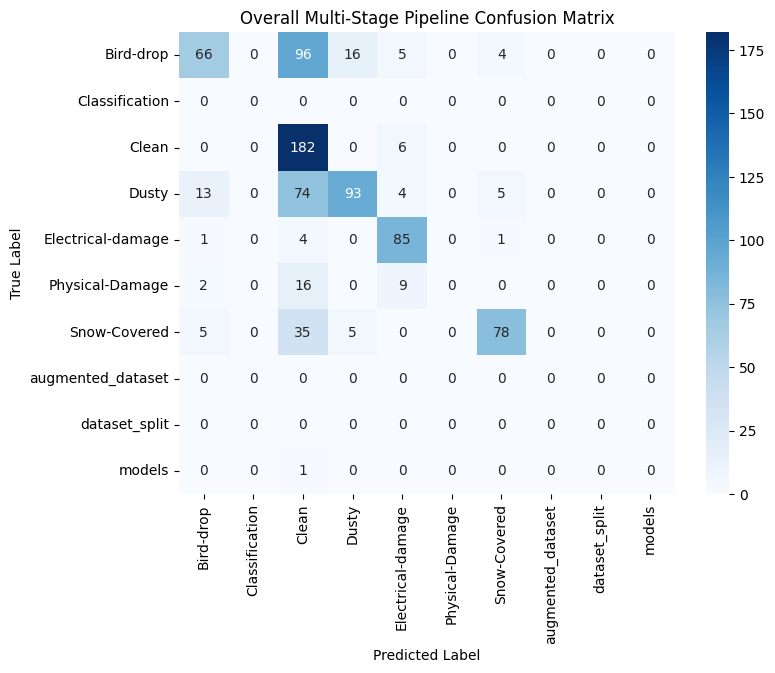

In [ ]:
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm  # progress bar
import pandas as pd

# ✅ Define your unified 6-class test set folder
# (Each subfolder = one true class name)
test_root = "/content/drive/MyDrive/Project/solarPanelDefectDetection"
# Example structure:
#  ├── Clean/
#  ├── Bird-drop/
#  ├── Dusty/
#  ├── Electrical-damage/
#  ├── Snow-Covered/
#  └── Physical-damage/

# If you don't yet have such a folder, create one by copying images from your other test dirs.

# ------------------------------------------------------------
# 1️⃣ Collect predictions and ground truth
# ------------------------------------------------------------
y_true, y_pred = [], []
class_names = sorted(os.listdir(test_root))

print("\n🔍 Evaluating full pipeline on all test images...\n")
for cls in class_names:
    cls_dir = os.path.join(test_root, cls)
    if not os.path.isdir(cls_dir):
        continue
    for fname in tqdm(os.listdir(cls_dir), desc=f"Testing {cls}", leave=False):
        if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        img_path = os.path.join(cls_dir, fname)
        try:
            pred_label = classify_image(img_path)
            y_true.append(cls)
            y_pred.append(pred_label.split("→")[-1].strip())  # last label part only
        except Exception as e:
            print(f"⚠️ Error on {fname}: {e}")

# ------------------------------------------------------------
# 2️⃣ Compute accuracy and print report
# ------------------------------------------------------------
acc = accuracy_score(y_true, y_pred)
print("\n✅ Overall Pipeline Accuracy: {:.2f}%".format(acc * 100))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=class_names, zero_division=0))

# ------------------------------------------------------------
# 3️⃣ Optional: Confusion matrix heatmap
# ------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=class_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Overall Multi-Stage Pipeline Confusion Matrix")
plt.show()
